### This is an old notebook with some of my early forrays into rotation and hyperfine structure, doesn't include kronig symmetry.

In [1]:
import numpy as np
import sympy as sp
sp.init_printing(use_latex=True)
from sympy.physics.quantum import Bra, Ket, qapply, Dagger as Dag
from sympy.physics.quantum.cg import CG
np.set_printoptions(precision=3,suppress=True,linewidth=100000, edgeitems=10000)
from sympy.physics.wigner import wigner_9j
from sympy.physics.secondquant import KroneckerDelta
import math
import time
import scipy.linalg
import IPython.display

In [2]:
import matplotlib.pyplot as plt
import MarksConstants as mc
import Miscellaneous as misc
import matplotlib.style
matplotlib.style.use('default')

In [3]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [4]:
from IPython.display import Latex

In [5]:
g = 0
u = 1

## some helper classes

In [6]:
# from stack exchange...
class OrthogonalKet(Ket):
    @classmethod
    def dual_class(self):
        return OrthogonalBra
    def _eval_innerproduct(self, bra, **hints):
        if len(self.args) != len(bra.args):
            raise ValueError('Cannot multiply a ket that has a different number of labels.')
        for i in range(len(self.args)):
            diff = self.args[i] - bra.args[i]
            diff.simplify()
            if diff.is_nonzero:
                return 0
            if not diff.is_zero:
                return None
        return 1

class OrthogonalBra(Bra):
    @classmethod
    def dual_class(self):
        return OrthogonalKet
OKet = OrthogonalKet
OBra = OrthogonalBra

In [7]:
class multiplyableDict(dict):
    # This class exists so that I can take a basis ref and use it in np.kron()
    # to programatically get the basis ref for multi-particle systems.
    def __mul__(self, other):
        assert(type(other) == type(self))
        newDict = multiplyableDict()
        for key, value in self.items():
            newDict.update({key+"_1": value})
        for key, value in other.items():
            newDict.update({key+"_2": value})
        return newDict

## some functions

In [8]:
def basisSize(J):
    return int(2*J+1)

In [9]:
def createBasisRefs(Lvals, Svals):
    jBasisRef = []
    Jvals = []
    for Lv in Lvals:
        for Sv in Svals:
            Jvals = set(np.arange(abs(Sv - Lv), Sv + Lv+1, 1))
            for Jv in Jvals:
                for mJ in np.arange(-Jv,Jv+1,1):
                    jBasisRef.append(multiplyableDict({"J":Jv, "mJ":mJ, "L":Lv, "S":Sv}))
    lsBasisRef = []
    for Lv in Lvals:
        for mL in np.arange(-Lv,Lv+1,1):
            for Sv in Svals:
                for mS in np.arange(-Sv, Sv+1,1):
                    lsBasisRef.append(multiplyableDict({"L":Lv, "mL":mL, "S":Sv, "mS":mS}))
    return lsBasisRef, jBasisRef, np.kron(lsBasisRef,lsBasisRef), np.kron(jBasisRef,jBasisRef)

In [10]:
def toSympy(state, basis, quiet=False):
    assert(len(state) == len(basis))
    if not quiet:
        print('Basis is: ')
        display(OKet(*basis[0].keys()))
    spState = sp.S(0)
    for stateE, basisE in zip(state, basis):
        if stateE[0] != 0:
            values = sp.S((np.array(list(basisE.values())) * 2).astype(int))
            spState += stateE[0] * OKet(*values / 2)
    return spState

In [11]:
def getColumnState(basis, quantumNums):
    assert(len(basis[0])==len(quantumNums))
    colState = [[0] for _ in range(len(basis))]
    for num, state in enumerate(basis):
        match = True
        for qnum, val in quantumNums.items():
            if val != state[qnum]:
                match = False
        if match:
            colState[num][0] = 1
            return colState
    raise ValueError("No Match! nums were" + str(quantumNums))

In [12]:
def lsToJ(lsBasis, jBasis):
    # expects single atom bases
    assert(len(lsBasis)==len(jBasis))
    op = np.zeros((len(lsBasis),len(jBasis)))
    for lsnum, lsState in enumerate(lsBasis):
        for jnum, jState in enumerate(jBasis):
            L, mL, S, mS = [lsState[key] for key in ['L','mL','S','mS']]
            J, mJ, JL, JS = [jState[key] for key in ['J','mJ', 'L', 'S']]
            # needing to handle this case makes me feel like the actual clebsh gordon coef should be written as
            # <L,mL,S,mS|J,mJ,L2,S2> or so instead of <L,mL,S,mS|J,mJ> as it usually is written. 
            if JL != L or JS != S:
                op[jnum,lsnum] = 0
            else:
                op[jnum,lsnum] += float(CG(L, mL, S, mS, J, mJ).doit())
    return op

In [13]:
def fsOp(basis):
    # expects a two-particle basis, so each element of the basis should 
    # have J_1, mJ_1, L_1, S_1, and J_2, mJ_2, L_2, S_2 values.
    op = np.zeros((len(basis),len(basis)))
    J1,mJ1,L1,S1,J2,mJ2,L2,S2 = [0 for _ in range(8)]
    names = ['J','mJ','L','S']
    for s1num, state1 in enumerate(basis):
        for s2num, state2 in enumerate(basis):
            val = 1
            qNums = [0 for _ in range(8)]
            for num, name in enumerate(names):
                if state2[name+"_1"] != state1[name+"_1"]:
                    # matrix is diagonal.
                    val = 0
                qNums[num] = state1[name+"_1"]
            for num, name in enumerate(names):
                if state2[name+"_2"] != state1[name+"_2"]:
                    # matrix is diagonal.
                    val = 0
                qNums[num+4] = state1[name+"_2"]
            J1,mJ1,L1,S1,J2,mJ2,L2,S2 = qNums
            # the matrix element is A/2 (L1 . S1 + L2 . S2), A=1
            val *= 0.5*(J1*(J1+1)-L1*(L1+1)-S1*(S1+1)+ J2*(J2+1)-L2*(L2+1)-S2*(S2+1) )
            op[s1num,s2num] = val            
    return op

In [14]:
def mpReflectionOp(basis):
    # expects the LSI basis
    # have J_1, mJ_1, L_1, S_1, and J_2, mJ_2, L_2, S_2 values.
    op = np.zeros((len(basis),len(basis)))
    J1,mJ1,L1,S1,J2,mJ2,L2,S2 = [0 for _ in range(8)]
    names = ['L', ]
    for s1num, state1 in enumerate(basis):
        for s2num, state2 in enumerate(basis):
            val = 1
            qNums = [0 for _ in range(8)]
            for num, name in enumerate(names):
                if state2[name+"_1"] != state1[name+"_1"]:
                    # matrix is diagonal.
                    val = 0
                qNums[num] = state1[name+"_1"]
            for num, name in enumerate(names):
                if state2[name+"_2"] != state1[name+"_2"]:
                    # matrix is diagonal.
                    val = 0
                qNums[num+4] = state1[name+"_2"]
            J1,mJ1,L1,S1,J2,mJ2,L2,S2 = qNums
            # the matrix element is A/2 (L1 . S1 + L2 . S2), A=1
            val *= 0.5*(J1*(J1+1)-L1*(L1+1)-S1*(S1+1)+ J2*(J2+1)-L2*(L2+1)-S2*(S2+1) )
            op[s1num,s2num] = val            
    return op

In [15]:
def createMovrePichlerMatrix(states, fsOperator, offset=-1/2):
    num = len(states)
    op = np.array([[0.0 for _ in states] for _ in states])
    for num, _ in enumerate(states):
        op[num,num] = offset
    for num1, state1 in enumerate(states):
        for num2, state2 in enumerate(states):
            op[num1,num2] += state2.T@fsOperator@state1
    return op    

In [16]:
def createBOMatrix(C3, R, *states):
    # expects states to be a list of lists where the low level list has the values of L, Lambda, S,Sigma, and sigma.
    matrix = np.array([[0.0 for _ in states] for _ in states])
    # the matrix is diagonal.
    for num, state in enumerate(states):
        L, Lambda, S, Sigma, sigma = state
        #print(L, Lambda, S, Sigma, sigma)
        p = (-1)**(S+sigma)
        matrix[num,num] = -p*(3*Lambda**2-L*(L+1))/R**3 * C3
        #print(-p*(3*Lambda**2-L*(L+1))/R**3 * C3)
    return matrix

In [17]:
def BohrOppenheimerToAtomic( oalNums, spinNums, sigma, 
                             lsBasis, jBasis, resInJBasis=True ):
    """
    L is the total molecular orbital angular momentum \vec{L} = \vec{l1}+\vec{l2}
    Lambda is the projection of L on the internuclear axis.
    l1 is the orbital angular momentum of atom 1.
    l2 is the orbital angular momentum of atom 2.
    
    S is the total molecular spin angular momentum \vec{s} = \vec{s1}+\vec{s2}
    Sigma is the projection of S on the internuclear axis.
    s1 is the spin angular momentum of atom 1.
    s2 is the spin angular momentum of atom 2.
    
    sigma is the spatial symmetry of the electronic wavefunctions, 
        either 0 for g ("gerude" or symmetric wavefunctions) 
        or 1 for u ("ungerude" or antisymmetric wavefunctions)
    """
    (L, Lambda, la, lb) = oalNums
    (S, Sigma, sa, sb) = spinNums
    state = 0
    p = (-1)**(S+sigma)
    for mla in np.arange(-la,la+1,1):
        for mlb in np.arange(-lb,lb+1,1):
            for msa in np.arange(-sa,sa+1,1):
                for msb in np.arange(-sb,sb+1,1):
                    # CG notation is <j1,mj1,j2,mj2|j3,mj3>
                    oalCoef = float(CG(la,mla,lb,mlb,L,Lambda).doit())
                    spinCoef = float(CG(sa,msa,sb,msb,S,Sigma).doit())
                    if oalCoef == 0 or spinCoef == 0:
                        continue
                    aState1 = getColumnState(lsBasis, {'L':la,'mL':mla,'S':sa,'mS':msa})
                    bState1 = getColumnState(lsBasis, {'L':lb,'mL':mlb,'S':sb,'mS':msb})
                    aState2 = getColumnState(lsBasis, {'L':lb,'mL':mlb,'S':sa,'mS':msa})
                    bState2 = getColumnState(lsBasis, {'L':la,'mL':mla,'S':sb,'mS':msb})
                    # print(oalCoef,spinCoef, np.linalg.norm(aState1), np.linalg.norm(bState1), np.linalg.norm(aState2), np.linalg.norm(bState2))
                    if resInJBasis:
                        lsToJop = lsToJ(lsBasis,jBasis)
                        aState1 = lsToJop@aState1
                        bState1 = lsToJop@bState1
                        aState2 = lsToJop@aState2
                        bState2 = lsToJop@bState2
                    state += oalCoef*spinCoef * (np.kron(aState1,bState1) + p * np.kron(aState2,bState2))
    if (np.linalg.norm(state) == 0):
        raise ValueError('Resulting State had zero norm!')
    state /= np.linalg.norm(state)
    return state

# Calculations

## S+P Alkali Calculations

In [18]:
lsBasis, jBasis, lsBasis2, jBasis2 = createBasisRefs([0,1], [1/2])
lsToJOp = lsToJ(lsBasis,jBasis)
fsOperator = fsOp(jBasis2)

In [19]:
# 0mg
sig_3mg_0mg = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 0, 1/2, 1/2), g, lsBasis, jBasis );
pi_3g_0mg   = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1/2, 1/2), g, lsBasis, jBasis )
                         +BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1/2, 1/2), g, lsBasis, jBasis ))
# order matters 
bo_0mg = [(1,0,1,0,g),(1,-1,1,1,g)]
# 0pg
pi_3g_0pg = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1/2, 1/2), g, lsBasis, jBasis )
                        -BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1/2, 1/2), g, lsBasis, jBasis ))
sig_1pg_0pg = BohrOppenheimerToAtomic( (1, 0, 1, 0), (0, 0, 1/2, 1/2), g, lsBasis, jBasis );
bo_0pg = [(1,0,0,0,g),(1,-1,1,1,g)]
#1g
sig_3pg_1g = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 1, 1/2, 1/2), g, lsBasis, jBasis );
pi_3g_1g = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 0, 1/2, 1/2), g, lsBasis, jBasis );
pi_1g_1g = BohrOppenheimerToAtomic( (1, 1, 1, 0), (0, 0, 1/2, 1/2), g, lsBasis, jBasis );
bo_1g = [(1,0,1,1,g), (1,1,1,0,g), (1,1,0,0,g)]
#2g
pi_3g_2g = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 1, 1/2, 1/2), g, lsBasis, jBasis );
bo_2g = [(1,1,1,1,g)]
# 0mu
sig_1mu_0mu = BohrOppenheimerToAtomic( (1, 0, 1, 0), (0, 0, 1/2, 1/2), u, lsBasis, jBasis );
pi_3u_0mu = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1/2, 1/2), u, lsBasis, jBasis )
                        -BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1/2, 1/2), u, lsBasis, jBasis ))
bo_0mu = [(1,0,0,0,u),(1,-1,1,1,u)]
# 0pu
sig_3pu_0pu = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 0, 1/2, 1/2), u, lsBasis, jBasis );
pi_3u_0pu = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1/2, 1/2), u, lsBasis, jBasis )
                        +BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1/2, 1/2), u, lsBasis, jBasis ))
bo_0pu = [(1,0,1,0,u), (1,-1,1,1,u)]
#1u
sig_3mg_1u = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 1, 1/2, 1/2), u, lsBasis, jBasis );
pi_3g_1u = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 0, 1/2, 1/2), u, lsBasis, jBasis );
pi_1g_1u = BohrOppenheimerToAtomic( (1, 1, 1, 0), (0, 0, 1/2, 1/2), u, lsBasis, jBasis );
bo_1u = [(1,0,1,1,u), (1,1,1,0,u), (1,1,0,0,u)]
#2u
pi_3g_2u = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 1, 1/2, 1/2), u, lsBasis, jBasis );
bo_2u = [(1,1,1,1,u)]

In [ ]:
print('ha')

In [25]:
V_0mg = createMovrePichlerMatrix((sig_3mg_0mg, pi_3g_0mg), fsOperator)
V_0pg = createMovrePichlerMatrix((sig_1pg_0pg, pi_3g_0pg), fsOperator)
V_1g = createMovrePichlerMatrix((sig_3pg_1g, pi_3g_1g, pi_1g_1g), fsOperator)
V_2g = createMovrePichlerMatrix(((pi_3g_2g,)), fsOperator)

V_0mu = createMovrePichlerMatrix((sig_1mu_0mu, pi_3u_0mu), fsOperator)
V_0pu = createMovrePichlerMatrix((sig_3pu_0pu, pi_3u_0pu), fsOperator)
V_1u = createMovrePichlerMatrix((sig_3mg_1u, pi_3g_1u, pi_1g_1u), fsOperator)
V_2u = createMovrePichlerMatrix(((pi_3g_2u,)), fsOperator)

bigMatrix = createMovrePichlerMatrix( ( pi_3g_0mg,sig_3mg_0mg, pi_3g_0pg, sig_1pg_0pg, sig_3pg_1g, pi_3g_1g, pi_1g_1g, pi_3g_2g,
                                        pi_3u_0mu, sig_1mu_0mu, pi_3u_0pu, sig_3pu_0pu, sig_3mg_1u, pi_3g_1u, pi_1g_1u, pi_3g_2u), 
                                        fsOperator )

bigMatrix.shape

### Rubidium 87 Calculation

In [26]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


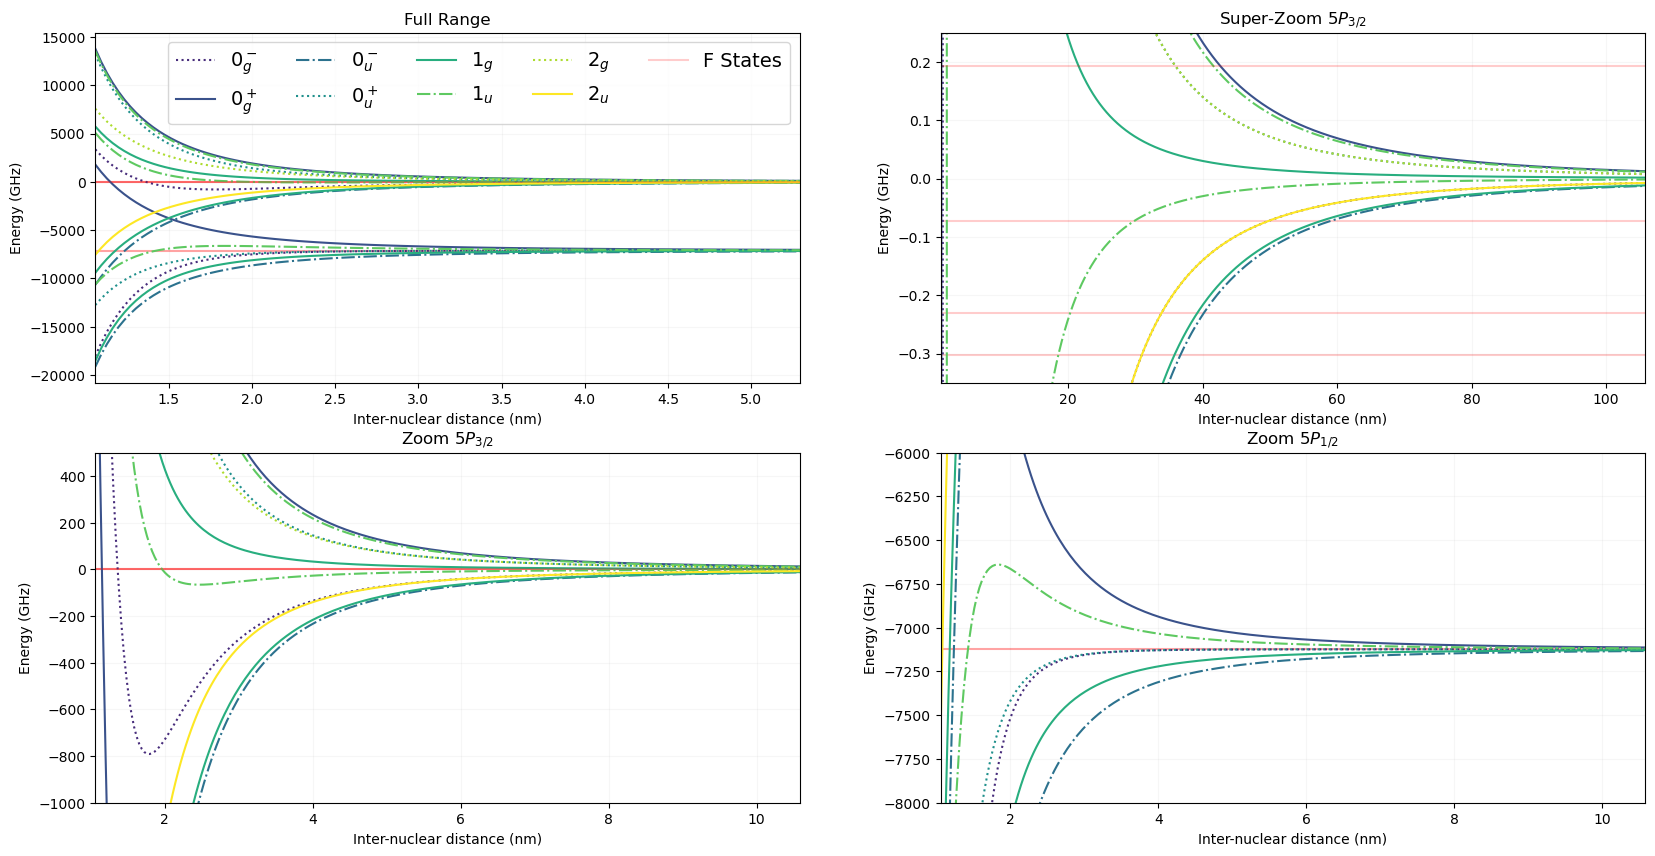

In [27]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
Rvals = np.linspace( 20*mc.a0, 2000*mc.a0, 3000 )
potentialList = [V_0mg, V_0pg, V_0mu, V_0pu, V_1g, V_1u, V_2g, V_2u]
BohrOppenheimerStates = [bo_0mg, bo_0pg, bo_0mu, bo_0pu, bo_1g, bo_1u, bo_2g, bo_2u]
names=[r'$0^-_g$',r'$0^+_g$',r'$0^-_u$',r'$0^+_u$',r'$1_g$',r'$1_u$', r'$2_g$', r'$2_u$']
linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
colors, _ = misc.getColors(len(potentialList), cmStr='viridis')
data = [[] for _ in range(len(potentialList)+2)]
for matrixnum, (name, potentialMatrix, c_, boStates) in enumerate(zip(names, potentialList, colors, BohrOppenheimerStates)):
    for rv in Rvals:
        rMatrix = createBOMatrix(C_3_val, rv, *boStates).astype(float) + potentialMatrix * 2 * DeltaVal / 3
        data[matrixnum].append(sorted(np.linalg.eigvals(rMatrix)))
for ax in axs.flatten():
    ax.axhline(-0.0729113, alpha=0.2,color='r')
    ax.axhline(-0.2298518, alpha=0.2,color='r')
    ax.axhline(-0.30207388, alpha=0.2,color='r')
    ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
    ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
    for name, mdata, c_, linestyle in zip(names, data, colors, linestyles):
        if len(np.array(mdata).shape) == 2 or len(np.array(mdata).shape) == 3:
            for lineNum, lineData in enumerate(misc.transpose(mdata)):
                ax.plot(Rvals*1e9, np.array(lineData) * 1e-9 / mc.h, 
                        label=name if lineNum == 0 else None, color=c_, linestyle=linestyle)
        else:
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, 
                    label=name, color=c_, linestyle=linestyle)
    ax.set_xlabel('Inter-nuclear distance (nm)')
    ax.set_ylabel('Energy (GHz)')
    ax.grid(alpha=0.1)
    ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

axs[0,0].set_title('Full Range')
axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
axs[0,0].legend(ncol=5,fontsize=14)
axs[1,0].set_title('Zoom $5P_{3/2}$')
axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,0].set_ylim(-1000, 500)
axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
axs[0,1].set_ylim(-0.35, 0.25)
axs[1,1].set_title('Zoom $5P_{1/2}$')
axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,1].set_ylim(-8000, -6000);
#plt.savefig('Movre-Pischler.png', dpi=200)

# rotation

The rotational energy in the hund's e case is given by  
$$
H_{\text{"rot"}} = \frac{\hbar^2}{2\mu R^2}\hat{N}^2 
$$

So I need to compare this to, say, the fine structure or hyperfine splitting to understand how important it is or isn't.  

In [28]:
def BohrOppenheimerToAtomic( oalNums, spinNums, sigma, 
                             lsBasis, jBasis, resInJBasis=True ):
    """
    oalNums = (L, Lambda, la, lb)
    L is the total molecular orbital angular momentum \vec{L} = \vec{l1}+\vec{l2}
    Lambda is the projection of L on the internuclear axis.
    l1 is the orbital angular momentum of atom 1.
    l2 is the orbital angular momentum of atom 2.
    
    spinNums = (S, Sigma, s1, s2)
    S is the total molecular spin angular momentum \vec{s} = \vec{s1}+\vec{s2}
    Sigma is the projection of S on the internuclear axis.
    s1 is the spin angular momentum of atom 1.
    s2 is the spin angular momentum of atom 2.
    
    sigma is the spatial symmetry of the electronic wavefunctions, 
        either 0 for g ("gerude" or symmetric wavefunctions) 
        or 1 for u ("ungerude" or antisymmetric wavefunctions)
    """
    (L, Lambda, la, lb) = oalNums
    (S, Sigma, sa, sb) = spinNums
    state = 0
    p = (-1)**(S+sigma)
    for mla in np.arange(-la,la+1,1):
        for mlb in np.arange(-lb,lb+1,1):
            for msa in np.arange(-sa,sa+1,1):
                for msb in np.arange(-sb,sb+1,1):
                    # CG notation is <j1,mj1,j2,mj2|j3,mj3>
                    oalCoef = float(CG(la,mla,lb,mlb,L,Lambda).doit())
                    spinCoef = float(CG(sa,msa,sb,msb,S,Sigma).doit())
                    aState1 = getColumnState(lsBasis, {'L':la,'mL':mla,'S':sa,'mS':msa})
                    bState1 = getColumnState(lsBasis, {'L':lb,'mL':mlb,'S':sb,'mS':msb})
                    aState2 = getColumnState(lsBasis, {'L':lb,'mL':mlb,'S':sa,'mS':msa})
                    bState2 = getColumnState(lsBasis, {'L':la,'mL':mla,'S':sb,'mS':msb})
                    if resInJBasis:
                        lsToJop = lsToJ(lsBasis,jBasis)
                        aState1 = lsToJop@aState1
                        bState1 = lsToJop@bState1
                        aState2 = lsToJop@aState2
                        bState2 = lsToJop@bState2
                    state += oalCoef*spinCoef * (np.kron(aState1,bState1) + p * np.kron(aState2,bState2))
    if np.linalg.norm(state) == 0:
        raise ValueError("State has zero norm!")
    state /= np.linalg.norm(state)
    
    return state

$$
|\Lambda S \Sigma I \iota p\rangle
$$

In [45]:
def createMovrePichlerMatrix(states, fsOperator, offset=-1/2):
    num = len(states)
    op = np.array([[0.0 for _ in states] for _ in states])
    for num, _ in enumerate(states):
        op[num,num] = offset
    for num1, state1 in enumerate(states):
        for num2, state2 in enumerate(states):
            op[num1,num2] += state2.T@fsOperator@state1
    return op    

In [46]:
def coef_fs(j_a, j_b, j, ell, L,
         #L, L_a, L_b,
         S, S_a, S_b,
         Lambda, Sigma, Omega, p, J):
    L_a = 0
    L_b = L
    #print(type(ell),type(Omega),type(J))
    sign = (-1)**(ell-Omega-J)
    frac = (1+(-1)**(L_b+ell+p)*(1-KroneckerDelta(Lambda,0)*KroneckerDelta(Sigma,0)))/sp.sqrt(2-KroneckerDelta(Lambda,0)*KroneckerDelta(Sigma,0))
    twoxm1Term = sp.sqrt(int((2*S+1)*(2*j_a+1)*(2*j_b+1)*(2*L+1)))
    cgcoeffs = CG(J,Omega,j,-Omega,ell,0).doit()*CG(L,Lambda,S,Sigma, j,Omega).doit()
    wig = wigner_9j(L_a,S_a,j_a,L_b,S_b,j_b,L,S,j)
    return sign*frac*twoxm1Term*cgcoeffs*wig

In [47]:
def createCaseE_Basis(singleAtomJvals, J):
    caseE_BasisRef = []
    for sigma in ["g","u"]:
        for ja in singleAtomJvals:
            for jb in singleAtomJvals:
                for j in np.arange(abs(ja-jb),ja+jb,1, dtype=float):
                    for ell in np.arange(max([J-2,0]),J+2,1, dtype=float):
                        state = multiplyableDict({"ja":ja, "jb": jb, "j": j, "ell":ell, "sigma":sigma, 'J':J})
                        if state not in caseE_BasisRef:
                            caseE_BasisRef.append(state)
    return caseE_BasisRef

In [48]:
def createRotationalCouplingMatrix(caseE_Basis):
    # creates the matrix in case E, needs to be transformed to case A basis to calculate properly.
    res = np.zeros((len(caseE_Basis),len(caseE_Basis)))
    for indE, stateE in enumerate(caseE_Basis):
        ell = stateE['ell']
        res[indE,indE] = ell*(ell+1)
    return res

In [60]:
def create_EtoA_Matrix(caseA_Basis, caseE_Basis):
    res = np.zeros((len(caseA_Basis), len(caseE_Basis)))
    for extraQN in [1,-1]:
        for aind, stateA in enumerate(caseA_Basis):
            for eind, stateE in enumerate(caseE_Basis):
                p = 0 if (-1)**(J+extraQN)>0 else 1
                res[aind, eind] = coef_fs(stateE['ja'], stateE['jb'], stateE['j'], stateE['ell'], stateA["L"], stateA["S"], 1/2, 1/2, stateA["Lambda"], abs(stateA["Omega"]-stateA["Lambda"]), abs(stateA["Omega"]), p, stateE["J"])
    return res

In [61]:
def createBornOppenheimerBasis(Lvals, Svals):
    # Normal Notaion is |L Lambda sigma S Sigma>, but I need to keep track of more than that for the splittings caused by other interactions.
    # Therefore this creates a very big basis which is probably unnecessary, but the size of the matrices isn't actually prohibitive in these 
    # calculations so it's okay to have degeneracies. 
    boBasisRef = []
    for sigma in ["g","u"]:
        for Lv in Lvals:
            for Lambda in np.arange(-Lv,Lv+1,1):
                for Sv in Svals:
                    for Sigma in np.arange(-Sv, Sv+1,1):
                        state = multiplyableDict({"L":Lv, "Lambda": Lambda, "sigma": sigma, "S":Sv, "Omega":Sigma+Lambda})
                        if state not in boBasisRef:
                            boBasisRef.append(state)
    boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"]) + 100 * ord(state["sigma"])))
    boBasisFancy = []
    for state in boBasisRef:
        spinT = 2*state["S"]+1
        omega = state["Omega"]
        parity = state["sigma"]
        LambdaSymbol = "\Sigma" if state["Lambda"]==0 else "\Pi"
        boBasisFancy.append(Latex(r"$^{"+str(spinT)+ "}" + LambdaSymbol + "_{"+ str(abs(omega)) + "," + parity + "}$"))        
    return boBasisRef, boBasisFancy

In [62]:
from IPython.display import Latex

In [63]:
boBasisDict, basisLatex = createBornOppenheimerBasis([1],[0,1])
for state in basisLatex:
    pass
    #display(state)

In [64]:
lsBasis, jBasis, lsBasis2, jBasis2 = createBasisRefs([0,1], [1/2])
lsToJOp = lsToJ(lsBasis,jBasis)
fsOperator = fsOp(jBasis2)

In [65]:
movrePischlerStates = []
basisDict, basisLatex = createBornOppenheimerBasis([1],[0,1])
for state in basisDict:
    sigma = g if state["sigma"] == "g" else u
    mpstate = BohrOppenheimerToAtomic( (state["L"], state["Lambda"], 1, 0), (state["S"], state["Omega"] - state["Lambda"], 1/2, 1/2), sigma, lsBasis, jBasis )
    if np.isnan(mpstate[0]):
        continue
    movrePischlerStates.append(mpstate)

In [66]:
bigMatrix = createMovrePichlerMatrix( movrePischlerStates, fsOperator )

In [67]:
def createBOMatrix2(C3, R, *states):
    # expects states to be a list of lists where the low level list has the values of L, Lambda, S,Sigma, and sigma.
    matrix = np.array([[0.0 for _ in states] for _ in states])
    # the matrix is diagonal.
    for num, state in enumerate(states):
        #L, Lambda, S, Sigma, sigma = state
        #print(L, Lambda, S, Sigma, sigma)
        sigma = g if state["sigma"]=="g" else u
        p = (-1)**(state["S"]+sigma)
        L = state["L"]
        matrix[num,num] = -p*(3*state["Lambda"]**2-L*(L+1))/R**3 * C3
        #print(-p*(3*Lambda**2-L*(L+1))/R**3 * C3)
    return matrix

In [68]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [69]:
1.33*20*mc.a0, 1.35*20*mc.a0

In [70]:
#Rvals = np.linspace( 1.33*20*mc.a0, 1.35*20*mc.a0, 2000 )
Rvals = np.linspace( 1*20*mc.a0, 200*20*mc.a0, 20000 )
colors = ['y','r','b','g']
jvals = [3,10,100,1000]
superdata = [[] for _ in jvals]
for jvalnum, (J, color) in enumerate(zip(jvals, colors)):
    data = superdata[jvalnum]
    #potentialList = [bigMatrix]
    #BohrOppenheimerStates = [bo_0mg, bo_0pg, bo_0mu, bo_0pu, bo_1g, bo_1u, bo_2g, bo_2u]
    #names=[r'$0^-_g$',r'$0^+_g$',r'$0^-_u$',r'$0^+_u$',r'$1_g$',r'$1_u$', r'$2_g$', r'$2_u$']
    #linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
    #data = []
    #J = 40
    caseE_basis = createCaseE_Basis([1/2,3/2], J)
    RCM = createRotationalCouplingMatrix(caseE_basis)#*mc.Rb87_M*1e-9**2/(mc.hbar**2)
    etoa = create_EtoA_Matrix(boBasisDict, caseE_basis)
    rotationalEnergy = etoa@RCM@etoa.conj().T
    for rv in Rvals:
        rMatrix = createBOMatrix2(C_3_val, rv, *basisDict).astype(float) + bigMatrix * 2 * DeltaVal / 3 + rotationalEnergy*mc.hbar**2/(mc.Rb87_M)*(1/rv**2)
        #rMatrix = bigMatrix * 2 * DeltaVal / 3 + rotationalEnergy.astype(float)*(1/rv**2)
        data.append(sorted(np.real(np.linalg.eigvals(rMatrix))))

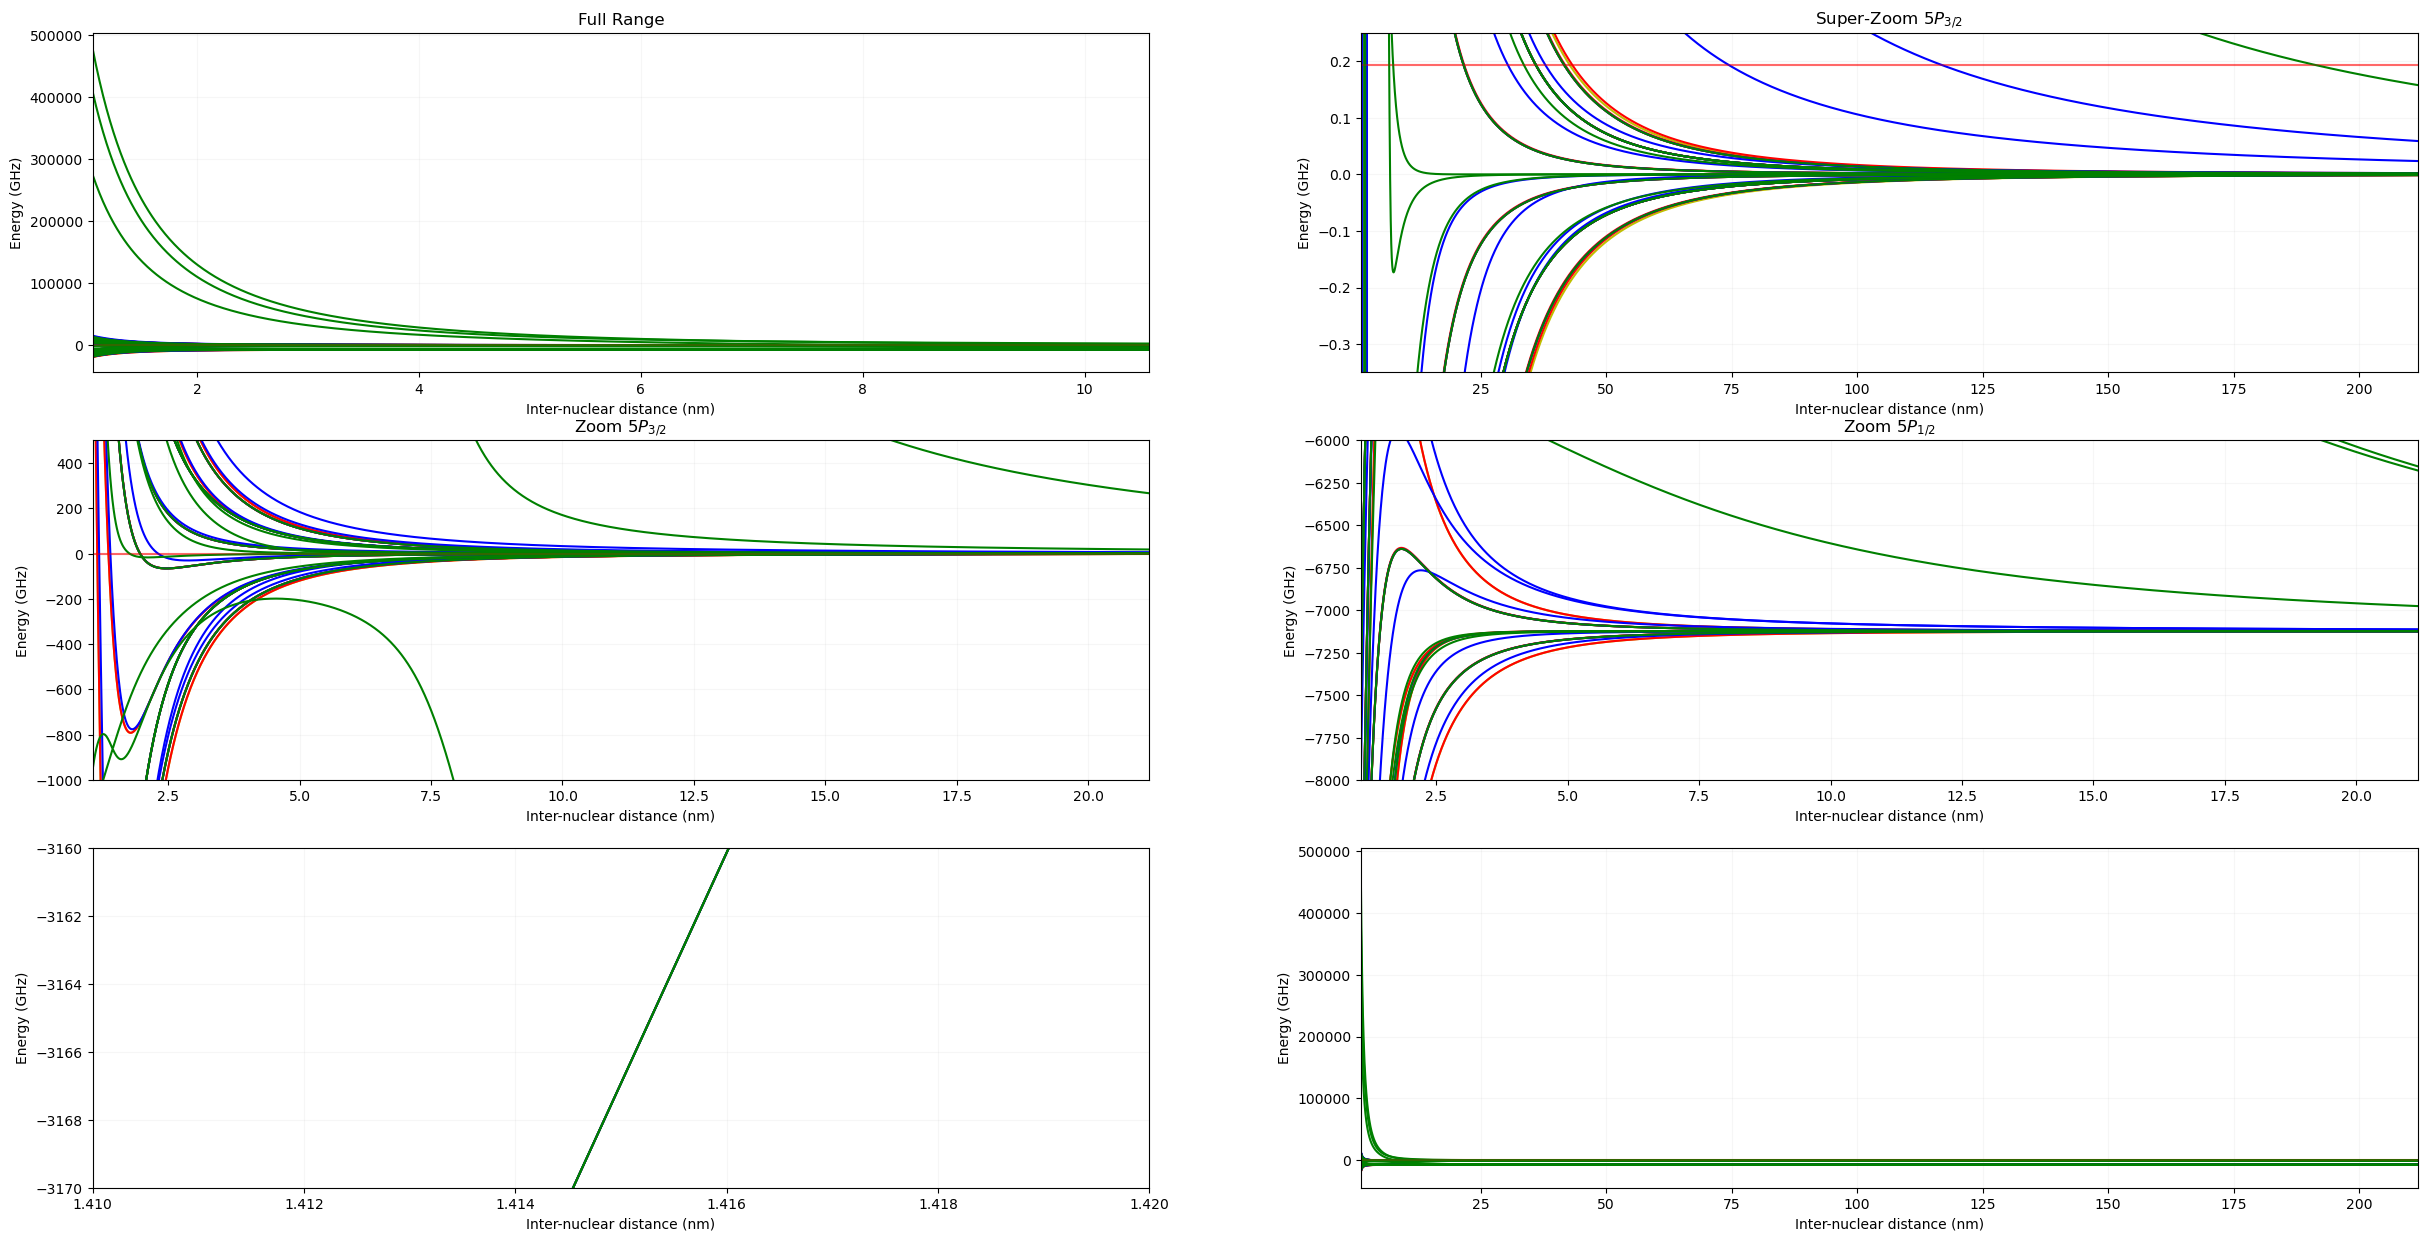

In [73]:
fig, axs = plt.subplots(3,2,figsize=(30,15))
for jvalnum, (J, color) in enumerate(zip(jvals, colors)):
    data = superdata[jvalnum]
    for ax in axs.flatten():
        #ax.axhline(-0.0729113, alpha=0.2,color='r')
        #ax.axhline(-0.2298518, alpha=0.2,color='r')
        #ax.axhline(-0.30207388, alpha=0.2,color='r')
        #ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        #ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
        for mdata in misc.transpose(data):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, color=color, linestyle='-')
        ax.set_xlabel('Inter-nuclear distance (nm)')
        ax.set_ylabel('Energy (GHz)')
        ax.grid(alpha=0.1)
        ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

    axs[0,0].set_title('Full Range')
    axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
    #axs[0,0].legend(ncol=5,fontsize=14)s
    axs[1,0].set_title('Zoom $5P_{3/2}$')
    axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
    axs[1,0].set_ylim(-1000, 500)
    axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
    axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
    axs[0,1].set_ylim(-0.35, 0.25)
    axs[1,1].set_title('Zoom $5P_{1/2}$')
    axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
    axs[1,1].set_ylim(-8000, -6000);
    axs[2,0].set_xlim(1.41,1.42)
    axs[2,0].set_ylim(-3170,-3160)
    axs[2,1].set_xlim(min(Rvals)*1e9, max(Rvals)*1e9)
    #plt.savefig('Movre-Pischler-Super-Rotating.png', dpi=200)

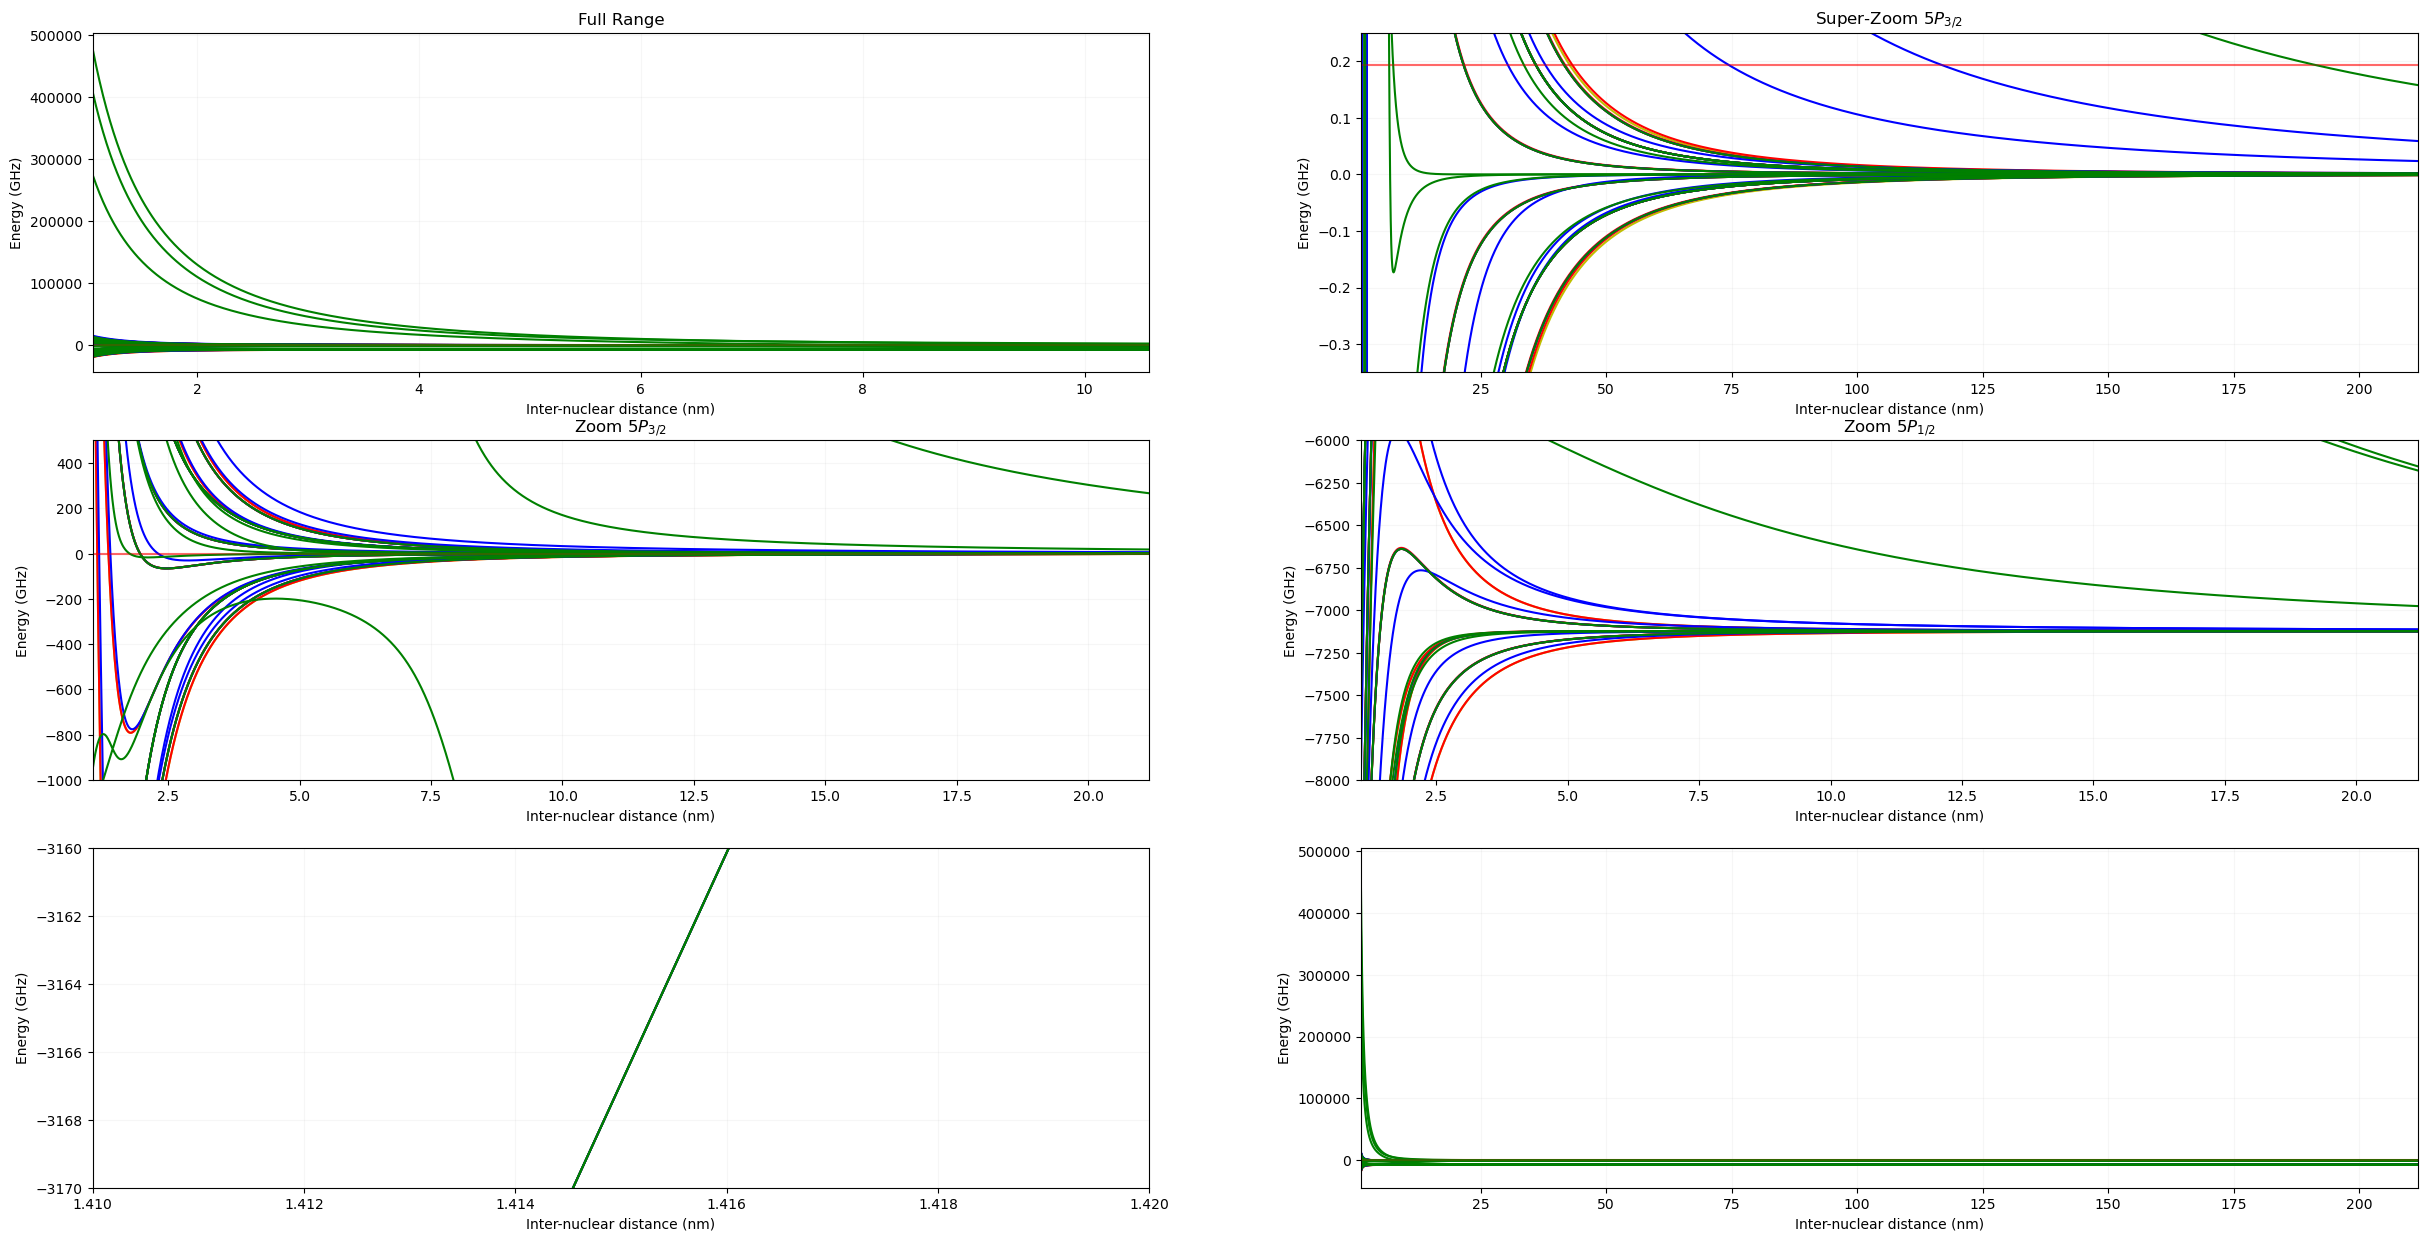

In [74]:
fig, axs = plt.subplots(3,2,figsize=(30,15))
for jvalnum, (J, color) in enumerate(zip(jvals, colors)):
    data = superdata[jvalnum]
    for ax in axs.flatten():
        #ax.axhline(-0.0729113, alpha=0.2,color='r')
        #ax.axhline(-0.2298518, alpha=0.2,color='r')
        #ax.axhline(-0.30207388, alpha=0.2,color='r')
        #ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        #ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
        for mdata in misc.transpose(data):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, color=color, linestyle='-')
        ax.set_xlabel('Inter-nuclear distance (nm)')
        ax.set_ylabel('Energy (GHz)')
        ax.grid(alpha=0.1)
        ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

    axs[0,0].set_title('Full Range')
    axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
    #axs[0,0].legend(ncol=5,fontsize=14)
    axs[1,0].set_title('Zoom $5P_{3/2}$')
    axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
    axs[1,0].set_ylim(-1000, 500)
    axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
    axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
    axs[0,1].set_ylim(-0.35, 0.25)
    axs[1,1].set_title('Zoom $5P_{1/2}$')
    axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
    axs[1,1].set_ylim(-8000, -6000);
    axs[2,0].set_xlim(1.41,1.42)
    axs[2,0].set_ylim(-3170,-3160)
    axs[2,1].set_xlim(min(Rvals)*1e9, max(Rvals)*1e9)
    #plt.savefig('Movre-Pischler-Super-Rotating.png', dpi=200)

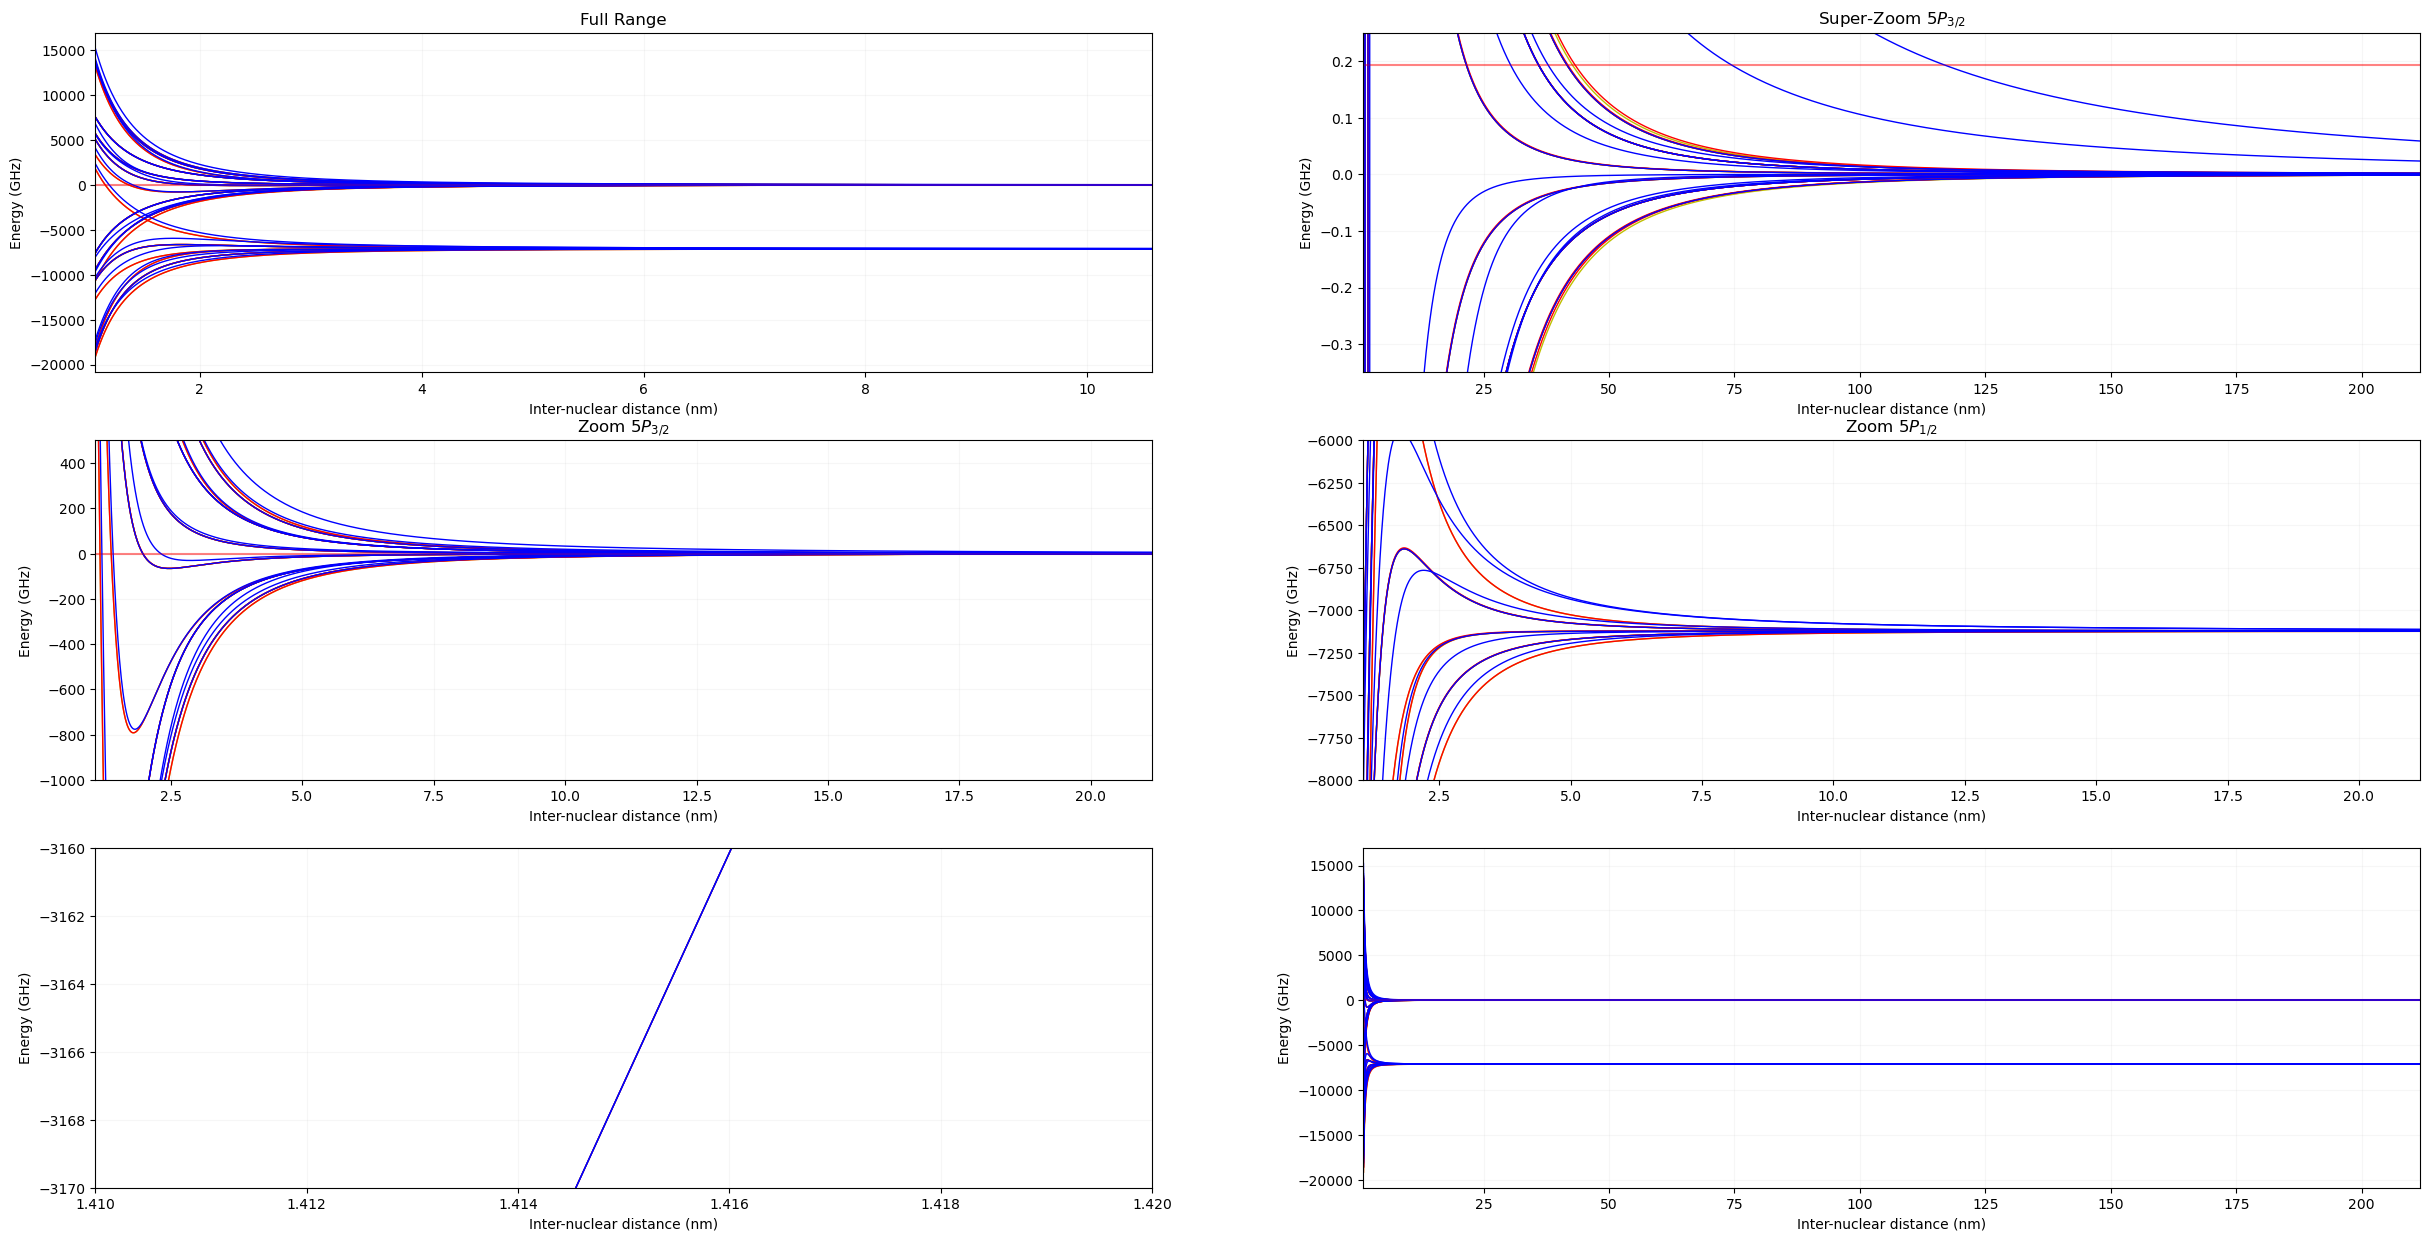

In [75]:
fig, axs = plt.subplots(3,2,figsize=(30,15))
for jvalnum, (J, color) in enumerate(zip(jvals[:-1], colors)):
    data = superdata[jvalnum]
    for ax in axs.flatten():
        #ax.axhline(-0.0729113, alpha=0.2,color='r')
        #ax.axhline(-0.2298518, alpha=0.2,color='r')
        #ax.axhline(-0.30207388, alpha=0.2,color='r')
        #ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        #ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
        for mdata in misc.transpose(data):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, color=color, linestyle='-', linewidth=1)
        ax.set_xlabel('Inter-nuclear distance (nm)')
        ax.set_ylabel('Energy (GHz)')
        ax.grid(alpha=0.1)
        ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

    axs[0,0].set_title('Full Range')
    axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
    #axs[0,0].legend(ncol=5,fontsize=14)
    axs[1,0].set_title('Zoom $5P_{3/2}$')
    axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
    axs[1,0].set_ylim(-1000, 500)
    axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
    axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
    axs[0,1].set_ylim(-0.35, 0.25)
    axs[1,1].set_title('Zoom $5P_{1/2}$')
    axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
    axs[1,1].set_ylim(-8000, -6000);
    axs[2,0].set_xlim(1.41,1.42)
    axs[2,0].set_ylim(-3170,-3160)
    axs[2,1].set_xlim(min(Rvals)*1e9, max(Rvals)*1e9)
    #plt.savefig('Movre-Pischler-W-Rotation.png', dpi=200)

### S+P Alkali Calculations

In [36]:
lsBasis, jBasis, lsBasis2, jBasis2 = createBasisRefs([0,1], [1/2])
lsToJOp = lsToJ(lsBasis,jBasis)
fsOperator = fsOp(jBasis2)

In [43]:
boBasis = ( pi_3g_0mg,sig_3mg_0mg, pi_3g_0pg, sig_1pg_0pg, sig_3pg_1g, pi_3g_1g, pi_1g_1g, pi_3g_2g,
            pi_3u_0mu, sig_1mu_0mu, pi_3u_0pu, sig_3pu_0pu, sig_3mg_1u, pi_3g_1u, pi_1g_1u, pi_3g_2u)

In [37]:
# 0mg
sig_3mg_0mg = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 0, 1/2, 1/2), g, lsBasis, jBasis );
pi_3g_0mg   = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1/2, 1/2), g, lsBasis, jBasis )
                         +BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1/2, 1/2), g, lsBasis, jBasis ))
# order matters 
bo_0mg = [(1,0,1,0,g),(1,-1,1,1,g)]
# 0pg
pi_3g_0pg = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1/2, 1/2), g, lsBasis, jBasis )
                        -BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1/2, 1/2), g, lsBasis, jBasis ))
sig_1pg_0pg = BohrOppenheimerToAtomic( (1, 0, 1, 0), (0, 0, 1/2, 1/2), g, lsBasis, jBasis );
bo_0pg = [(1,0,0,0,g),(1,-1,1,1,g)]
#1g
sig_3pg_1g = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 1, 1/2, 1/2), g, lsBasis, jBasis );
pi_3g_1g = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 0, 1/2, 1/2), g, lsBasis, jBasis );
pi_1g_1g = BohrOppenheimerToAtomic( (1, 1, 1, 0), (0, 0, 1/2, 1/2), g, lsBasis, jBasis );
bo_1g = [(1,0,1,1,g), (1,1,1,0,g), (1,1,0,0,g)]
#2g
pi_3g_2g = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 1, 1/2, 1/2), g, lsBasis, jBasis );
bo_2g = [(1,1,1,1,g)]
# 0mu
sig_1mu_0mu = BohrOppenheimerToAtomic( (1, 0, 1, 0), (0, 0, 1/2, 1/2), u, lsBasis, jBasis );
pi_3u_0mu = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1/2, 1/2), u, lsBasis, jBasis )
                        -BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1/2, 1/2), u, lsBasis, jBasis ))
bo_0mu = [(1,0,0,0,u),(1,-1,1,1,u)]
# 0pu
sig_3pu_0pu = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 0, 1/2, 1/2), u, lsBasis, jBasis );
pi_3u_0pu = 2**(-1/2)*( BohrOppenheimerToAtomic( (1, -1, 1, 0), (1, 1, 1/2, 1/2), u, lsBasis, jBasis )
                        +BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, -1, 1/2, 1/2), u, lsBasis, jBasis ))
bo_0pu = [(1,0,1,0,u), (1,-1,1,1,u)]
#1u
sig_3mg_1u = BohrOppenheimerToAtomic( (1, 0, 1, 0), (1, 1, 1/2, 1/2), u, lsBasis, jBasis );
pi_3g_1u = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 0, 1/2, 1/2), u, lsBasis, jBasis );
pi_1g_1u = BohrOppenheimerToAtomic( (1, 1, 1, 0), (0, 0, 1/2, 1/2), u, lsBasis, jBasis );
bo_1u = [(1,0,1,1,u), (1,1,1,0,u), (1,1,0,0,u)]
#2u
pi_3g_2u = BohrOppenheimerToAtomic( (1, 1, 1, 0), (1, 1, 1/2, 1/2), u, lsBasis, jBasis );
bo_2u = [(1,1,1,1,u)]

In [38]:
V_0mg = createMovrePichlerMatrix((sig_3mg_0mg, pi_3g_0mg), fsOperator)
V_0pg = createMovrePichlerMatrix((sig_1pg_0pg, pi_3g_0pg), fsOperator)
V_1g = createMovrePichlerMatrix((sig_3pg_1g, pi_3g_1g, pi_1g_1g), fsOperator)
V_2g = createMovrePichlerMatrix(((pi_3g_2g,)), fsOperator)

V_0mu = createMovrePichlerMatrix((sig_1mu_0mu, pi_3u_0mu), fsOperator)
V_0pu = createMovrePichlerMatrix((sig_3pu_0pu, pi_3u_0pu), fsOperator)
V_1u = createMovrePichlerMatrix((sig_3mg_1u, pi_3g_1u, pi_1g_1u), fsOperator)
V_2u = createMovrePichlerMatrix(((pi_3g_2u,)), fsOperator)

bigMatrix = createMovrePichlerMatrix( ( pi_3g_0mg,sig_3mg_0mg, pi_3g_0pg, sig_1pg_0pg, sig_3pg_1g, pi_3g_1g, pi_1g_1g, pi_3g_2g,
                                        pi_3u_0mu, sig_1mu_0mu, pi_3u_0pu, sig_3pu_0pu, sig_3mg_1u, pi_3g_1u, pi_1g_1u, pi_3g_2u), 
                                        fsOperator )
bigMatrix.shape

In [39]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [ ]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
Rvals = np.linspace( 20*mc.a0, 2000*mc.a0, 3000 )
potentialList = [V_0mg, V_0pg, V_0mu, V_0pu, V_1g, V_1u, V_2g, V_2u]
BohrOppenheimerStates = [bo_0mg, bo_0pg, bo_0mu, bo_0pu, bo_1g, bo_1u, bo_2g, bo_2u]
names=[r'$0^-_g$',r'$0^+_g$',r'$0^-_u$',r'$0^+_u$',r'$1_g$',r'$1_u$', r'$2_g$', r'$2_u$']
linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
colors, _ = misc.getColors(len(potentialList), cmStr='viridis')
data = [[] for _ in range(len(potentialList)+2)]
for matrixnum, (name, potentialMatrix, c_, boStates) in enumerate(zip(names, potentialList, colors, BohrOppenheimerStates)):
    for rv in Rvals:
        rMatrix = createBOMatrix(C_3_val, rv, *boStates).astype(float) + potentialMatrix * 2 * DeltaVal / 3
        data[matrixnum].append(sorted(np.linalg.eigvals(rMatrix)))
for ax in axs.flatten():
    ax.axhline(-0.0729113, alpha=0.2,color='r')
    ax.axhline(-0.2298518, alpha=0.2,color='r')
    ax.axhline(-0.30207388, alpha=0.2,color='r')
    ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
    ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
    for name, mdata, c_, linestyle in zip(names, data, colors, linestyles):
        if len(np.array(mdata).shape) == 2 or len(np.array(mdata).shape) == 3:
            for lineNum, lineData in enumerate(misc.transpose(mdata)):
                ax.plot(Rvals*1e9, np.array(lineData) * 1e-9 / mc.h, 
                        label=name if lineNum == 0 else None, color=c_, linestyle=linestyle)
        else:
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, 
                    label=name, color=c_, linestyle=linestyle)
    ax.set_xlabel('Inter-nuclear distance (nm)')
    ax.set_ylabel('Energy (GHz)')
    ax.grid(alpha=0.1)
    ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

axs[0,0].set_title('Full Range')
axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
axs[0,0].legend(ncol=5,fontsize=14)
axs[1,0].set_title('Zoom $5P_{3/2}$')
axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,0].set_ylim(-1000, 500)
axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
axs[0,1].set_ylim(-0.35, 0.25)
axs[1,1].set_title('Zoom $5P_{1/2}$')
axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,1].set_ylim(-8000, -6000);
plt.savefig('Movre-Pischler.png', dpi=200)

In [98]:
print(mc.hbar/(mc.Rb87_M*(1.4e-9)**2)*1e-6, "MHz")

372.82527330070377 MHz


# Symmetrized Hyperfine

In [18]:
def hfsOp(basis, A_12, A_gs, F3E, F2E, F1E, F0E):
    # expects a two-particle basis, so each element of the basis should 
    # have J_1, mJ_1, L_1, S_1, and J_2, mJ_2, L_2, S_2 values.
    op = np.zeros((len(basis),len(basis)))
    f1,mf1,j1,i1,f2,mf2,j2,i2 = [0 for _ in range(8)]
    names = ['F','mF','J','I']
    for s1num, state1 in enumerate(basis):
        qNums = [0 for _ in range(8)]
        for num, name in enumerate(names):
            qNums[num] = state1[name+"_1"]
        for num, name in enumerate(names):
            qNums[num+4] = state1[name+"_2"]
        f1,mf1,j1,i1,f2,mf2,j2,i2 = qNums
        A1 = A_12 if state1["L_1"] == 1 else A_gs
        E1 = A1/2 * (f1*(f1+1)-j1*(j1+1)-i1*(i1+1)) if state1["J_1"] != 3/2 else (F3E if f1==3 else (F2E if f1==2 else (F1E if f1==1 else F0E)))
        A2 = A_12 if state1["L_2"] == 1 else A_gs
        E2 = A2/2 * (f2*(f2+1)-j2*(j2+1)-i2*(i2+1)) if state1["J_2"] != 3/2 else (F3E if f2==3 else (F2E if f2==2 else (F1E if f2==1 else F0E)))
        op[s1num,s1num] = E1 + E2
    return op

In [19]:
def createBornOppenheimerBasisHFS_Sym(Lvals, Svals, Ivals, sigmavals=["g","u"]):
    # Good quantum numbers: |c Lambda S Sigma I iota p>
    # why does L enter in here?
    boBasisRef = []
    for sigma in sigmavals:
        for Lv in Lvals:
            for Lambda in np.arange(-Lv,Lv+1,1):
                for Sv in Svals:
                    for Sigma in np.arange(-Sv, Sv+1,1):
                        for i1 in Ivals:
                            for i2 in Ivals:
                                for I in np.arange(abs(i2-i1), i2+i1+1,1):
                                    for iota in np.arange(-I,I+1,1):
                                        #state = multiplyableDict({"L":Lv, "Lambda": Lambda, "S":Sv, "Sigma":Sigma, "i":I, "iota":iota, "i1":i1, "i2":i2,
                                        #                          "Omega":Sigma+Lambda, "phi": Sigma+Lambda+iota })
                                        Omega = Sigma+Lambda
                                        absPhi  = abs(Sigma+Lambda+iota)
                                        if Lambda != 0 and Omega==0:
                                            for sigmav in [-1,1]:
                                                state = multiplyableDict({"L":Lv, "|Lambda|": abs(Lambda), "sigma": sigma, "S":Sv, "|Sigma|":abs(Sigma), "i":I, "iota":iota, "i1":i1, "i2":i2,
                                                                          "Omega":Omega, "|phi|":absPhi , "sigma_vxz": sigmav })
                                                if state not in boBasisRef:
                                                    boBasisRef.append(state)
                                        else:
                                            state = multiplyableDict({"L":Lv, "|Lambda|": abs(Lambda), "sigma": sigma, "S":Sv, "|Sigma|":abs(Sigma), "i":I, "iota":iota, "i1":i1, "i2":i2,
                                                                      "Omega":Omega, "|phi|": absPhi, "sigma_vxz": (-1)**(Lv-Lambda+Sv-Sigma) })
                                            if state not in boBasisRef:
                                                boBasisRef.append(state)
    # sort by omega and sigma value. should probably change...
    #boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"]) + 100 * ord(state["sigma"])))
    boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"])))
    return boBasisRef

In [20]:
def createCouplingMatrix_sym(states, op, offset=-1/2, boBasis=None):
    num = len(states)
    coupleM = np.array([[0.0 for _ in states] for _ in states])
    for num, _ in enumerate(states):
        coupleM[num,num] = offset
    for num1, state1 in enumerate(states):
        misc.reportProgress(num1, len(states))
        for num2, state2 in enumerate(states):
            matElem = state2.T@op@state1
            if boBasis is not None:
                if boBasis[num1]['sigma'] != boBasis[num2]['sigma'] and not math.isclose(matElem, 0, abs_tol=0):# and boBasis[num1]['sigma_vxz'] != boBasis[num2]['sigma_vxz']:
                    continue
                    print(boBasis[num1], '\n', boBasis[num2],'\n', matElem, '\n')
            coupleM[num1,num2] += matElem
    return coupleM    

In [21]:
def createBOMatrix2_sym(C3, R, *states):
    # expects states to be a list of lists where the low level list has the values of L, Lambda, S,Sigma, and sigma.
    matrix = np.array([[0.0 for _ in states] for _ in states])
    # the matrix is diagonal.
    for num, state in enumerate(states):
        #L, Lambda, S, Sigma, sigma = state
        sigma = g if state["sigma"]=="g" else u
        p = (-1)**(state["S"]+sigma)
        L = state["L"]
        matrix[num,num] = -p*(3*state["|Lambda|"]**2-L*(L+1))/R**3 * C3
    return matrix

In [22]:
def BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsBasis, basisChange=None ):
    state = 0
    indvCont = []
    lsiBasisStates = []
    otherBasisStates = []
    (L, Lambda, la, lb) = oalNums
    (S, Sigma, sa, sb) = spinNums
    (I, iota, ia, ib) = nuclearNums
    p_ = (-1)**(S+sigma)
    for mla in np.arange(-la,la+1,1):
        mlb = Lambda-mla
        if abs(mlb) > lb:
            continue
        for msa in np.arange(-sa,sa+1,1):
            msb = Sigma-msa
            if abs(msb) > sb:
                continue
            for mia in np.arange(-ia, ia+1, 1):
                mib = iota-mia
                if abs(mib) > ib:
                    continue
                # for mib in np.arange(-ib,ib+1,1):
                # CG notation is <j1,mj1,j2,mj2|j3,mj3>
                oalCoef = float(CG(la,mla,lb,mlb,L,Lambda).doit())
                spinCoef = float(CG(sa,msa,sb,msb,S,Sigma).doit())
                nuclearCoef = float(CG(ia,mia,ib,mib,I,iota).doit())
                aState1 = getColumnState(lsiBasis, {'L':la,'mL':mla,'S':sa,'mS':msa, 'I':ia,'mI':mia})
                bState1 = getColumnState(lsiBasis, {'L':lb,'mL':mlb,'S':sb,'mS':msb, 'I':ib,'mI':mib})
                aState2 = getColumnState(lsiBasis, {'L':lb,'mL':mlb,'S':sa,'mS':msa, 'I':ia,'mI':mia})
                bState2 = getColumnState(lsiBasis, {'L':la,'mL':mla,'S':sb,'mS':msb, 'I':ib,'mI':mib})
                if oalCoef != 0 and nuclearCoef != 0 and spinCoef != 0:
                    lsiBasisStates.append([aState1, bState1, aState2, bState2])
                if basisChange is not None:
                    aState1 = basisChange@aState1
                    bState1 = basisChange@bState1
                    aState2 = basisChange@aState2
                    bState2 = basisChange@bState2
                newpart = nuclearCoef*oalCoef*spinCoef * (np.kron(aState1,bState1) + p_ * np.kron(aState2,bState2))
                state += newpart
                if oalCoef != 0 and nuclearCoef != 0 and spinCoef != 0:
                    indvCont.append(newpart)
                    otherBasisStates.append([aState1, bState1, aState2, bState2])
    if np.linalg.norm(state) == 0:
        raise ValueError("State has zero norm!")
    state /= np.linalg.norm(state)
    return state, np.array(indvCont), np.array(lsiBasisStates), np.array(otherBasisStates)

In [23]:
def createBornOppenheimerBasisHFS_SuperSym(Lvals, Svals, Ivals, sigmavals=["g","u"]):
    # Good quantum numbers: |c Lambda S Sigma I iota p>
    # why does L enter in here?
    boBasisRef = []
    for sigma in sigmavals:
        for Lv in Lvals:
            for Lambda in np.arange(-Lv,Lv+1,1):
                for Sv in Svals:
                    for Sigma in np.arange(-Sv, Sv+1,1):
                        for i1 in Ivals:
                            for i2 in Ivals:
                                for Iv in np.arange(abs(i2-i1), i2+i1+1,1):
                                    for iota in np.arange(-Iv,Iv+1,1):
                                        #state = multiplyableDict({"L":Lv, "Lambda": Lambda, "S":Sv, "Sigma":Sigma, "i":I, "iota":iota, "i1":i1, "i2":i2,
                                        #                          "Omega":Sigma+Lambda, "phi": Sigma+Lambda+iota })
                                        Omega = Sigma+Lambda
                                        phi  = Sigma+Lambda+iota
                                        if Lambda != 0 and Omega==0:
                                            for sigmav in [-1,1]:
                                                state = multiplyableDict({"L":Lv, "|Lambda|": abs(Lambda), "sigma": sigma, "S":Sv, "|Sigma|":abs(Sigma), "i":Iv, "|iota|":abs(iota), "i1":i1, "i2":i2,
                                                                          "|Omega|":abs(Omega), "phi":phi , "sigma_vxz": sigmav, 'sigma_v2xz':sigmav*(-1)**(Iv-iota)})
                                                if state not in boBasisRef:
                                                    boBasisRef.append(state)
                                        elif Omega != 0 and phi == 0:
                                                for sigmav2 in [-1,1]:
                                                    state = multiplyableDict({"L":Lv, "|Lambda|": abs(Lambda), "sigma": sigma, "S":Sv, "|Sigma|":abs(Sigma), "i":Iv, "|iota|":abs(iota), "i1":i1, "i2":i2,
                                                                              "|Omega|":abs(Omega), "phi":phi , "sigma_vxz": (-1)**(Lv-Lambda+Sv-Sigma), 'sigma_v2xz':sigmav2})
                                                    if state not in boBasisRef:
                                                        boBasisRef.append(state)
                                        else:
                                            state = multiplyableDict({"L":Lv, "|Lambda|": abs(Lambda), "sigma": sigma, "S":Sv, "|Sigma|":abs(Sigma), "i":Iv, "|iota|":abs(iota), "i1":i1, "i2":i2,
                                                                      "|Omega|":abs(Omega), "phi": phi, "sigma_vxz": (-1)**(Lv-Lambda+Sv-Sigma), "sigma_v2xz":(-1)**(Lv-Lambda+Sv-Sigma+Iv-iota) })
                                            if state not in boBasisRef:
                                                boBasisRef.append(state)
    # sort by omega and sigma value. should probably change...
    #boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"]) + 100 * ord(state["sigma"])))
    boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["|Omega|"])))
    return boBasisRef

In [24]:
def mpReflectionOp(basis):
    # expects the 2-atom LSI basis
    op = np.zeros((len(basis),len(basis)))
    names = ['L', 'mL', 'S', 'mS', 'I', 'mI']
    for s1num, state1 in enumerate(basis):
        for s2num, state2 in enumerate(basis):
            val = 1
            for num, name in enumerate(['mL','mS']):
                if state2[name+"_1"] != -state1[name+"_1"] or state2[name+"_2"] != -state1[name+"_2"]:
                    val = 0
            for num, name in enumerate(['L','S','I','mI']):
                if state2[name+"_1"] != state1[name+"_1"] or state2[name+"_2"] != state1[name+"_2"]:
                    val = 0
            op[s1num,s2num] = val                        
    return op

In [25]:
def hfsReflectionOp(basis):
    # expects the 2-atom LSI basis
    op = np.zeros((len(basis),len(basis)))
    for s1num, state1 in enumerate(basis):
        for s2num, state2 in enumerate(basis):
            val = 1
            for num, name in enumerate(['mL','mS', 'mI']):
                if state2[name+"_1"] != -state1[name+"_1"] or state2[name+"_2"] != -state1[name+"_2"]:
                    val = 0
            for num, name in enumerate(['L','S','I']):
                if state2[name+"_1"] != state1[name+"_1"] or state2[name+"_2"] != state1[name+"_2"]:
                    val = 0
            op[s1num,s2num] = val                        
    return op

In [26]:
def createCouplingMatrix(states, op, offset=-1/2, boBasis=None):
    num = len(states)
    coupleM = np.array([[0.0 for _ in states] for _ in states])
    for num, _ in enumerate(states):
        coupleM[num,num] = offset
    for num1, state1 in enumerate(states):
        misc.reportProgress(num1, len(states))
        for num2, state2 in enumerate(states):
            matElem = state2.T@op@state1
            if boBasis is not None:
                if boBasis[num1]['sigma'] != boBasis[num2]['sigma'] and not math.isclose(matElem, 0, abs_tol=0):
                    continue
                    print(boBasis[num1], '\n', boBasis[num2],'\n', matElem, '\n')
            coupleM[num1,num2] += matElem
    return coupleM    

In [145]:
def BohrOppenheimerToAtomic_goodOmega(state, Omega):
    if Omega == 0 and state['|Lambda|'] != 0:
        #print('if')
        iota = state['phi'] - Omega
        sigma = g if state["sigma"] == "g" else u
        nuclearNums = [state['i'],iota,state['i1'],state['i2'],]
        LambdaVal = state["|Lambda|"]
        SigmaVal = -LambdaVal
        oalNums = (state["L"], LambdaVal, 1, 0)
        spinNums = (state["S"], SigmaVal, 1/2, 1/2)
        #if not LambdaVal+SigmaVal==Omega:
        #    print(LambdaVal,SigmaVal,Omega)
        assert(LambdaVal+SigmaVal==Omega)
        assert(LambdaVal+SigmaVal+iota==state['phi'])
        print(oalNums, spinNums, nuclearNums)
        mpstate1, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsiToJiop )
        hfsState1, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )

        LambdaVal = -state["|Lambda|"]
        SigmaVal = -LambdaVal
        assert(LambdaVal+SigmaVal==Omega)
        assert(LambdaVal+SigmaVal+iota==state['phi'])
        nuclearNums = [state['i'],-iota,state['i1'],state['i2'],]
        oalNums = (state["L"], LambdaVal, 1, 0)
        spinNums = (state["S"], SigmaVal, 1/2, 1/2)
        #print(oalNums, spinNums, nuclearNums)
        mpstate2, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsiToJiop )
        hfsState2, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )

        sumsign = 1 if state['sigma_vxz'] == 1 else -1
        newMp = (mpstate1 + sumsign*mpstate2)/np.sqrt(2)
        newHfs = (hfsState1 + sumsign*hfsState2)/np.sqrt(2)
    elif Omega != 0 and state['|Lambda|'] == 0:
        #print('elif')
        sigma = g if state["sigma"] == "g" else u
        LambdaVal = 0
        SigmaVal = state['|Sigma|']
        iota = state['phi'] - SigmaVal
        nuclearNums = [state['i'],iota,state['i1'],state['i2'],]
        oalNums = (state["L"], LambdaVal, 1, 0)
        spinNums = (state["S"], SigmaVal, 1/2, 1/2)
        #if not LambdaVal+SigmaVal==Omega:
        #    print(LambdaVal,SigmaVal,Omega)
        assert(abs(LambdaVal+SigmaVal)==abs(Omega))
        #if not abs(LambdaVal+SigmaVal+iota)==abs(state['phi']):
        #    print(LambdaVal,+SigmaVal,+iota,state['phi'])
        assert(abs(LambdaVal+SigmaVal+iota)==abs(state['phi']))
        mpstate1, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsiToJiop )
        hfsState1, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )

        LambdaVal = 0#-state["|Lambda|"]
        SigmaVal = -state['|Sigma|']
        iota = -iota
        assert(abs(LambdaVal+SigmaVal)==abs(Omega))
        #if not abs(LambdaVal+SigmaVal+iota)==abs(state['phi']):
            #print(LambdaVal,+SigmaVal,+iota,state['phi'])
        assert(abs(LambdaVal+SigmaVal+iota)==abs(state['phi']))
        nuclearNums = [state['i'],-iota,state['i1'],state['i2'],]
        oalNums = (state["L"], LambdaVal, 1, 0)
        spinNums = (state["S"], SigmaVal, 1/2, 1/2)
        mpstate2, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsiToJiop )
        hfsState2, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )

        sumsign = 1 if state['sigma_vxz'] == 1 else -1
        newMp = (mpstate1 + sumsign*mpstate2)/np.sqrt(2)
        newHfs = (hfsState1 + sumsign*hfsState2)/np.sqrt(2)        
    else:
        #print('else')
        iota = state['phi'] - Omega
        #print('else')
        sigma = g if state["sigma"] == "g" else u
        LambdaVal = np.sign(Omega) * state["|Lambda|"]
        SigmaVal = Omega - LambdaVal
        nuclearNums = [state['i'], iota, state['i1'],state['i2'],]
        oalNums = (state["L"], LambdaVal, 1, 0)
        spinNums = (state["S"], SigmaVal, 1/2, 1/2)
        assert(LambdaVal+SigmaVal==Omega)
        assert(LambdaVal+SigmaVal+iota==state['phi'])
        newMp, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsiToJiop )
        newHfs, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )
    return newMp, newHfs

In [28]:
A_gs = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
A_12 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
A_32 = (mc.Rb87_5P32_ToF3-mc.Rb87_5P32_ToF0)/6

In [95]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [ ]:
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = createLargerBasisRefs([0,1], [1/2], [0])
fsOperator = fsOp(jiBasis2Atom)
hfsOperator = hfsOp(fBasis2Atom, A_12, A_gs, mc.Rb87_5P32_ToF3, mc.Rb87_5P32_ToF2,mc.Rb87_5P32_ToF1,mc.Rb87_5P32_ToF0)
lsiToJiop = lsiToJi(lsiBasis,jiBasis)
jiToFOp = jiTof(jiBasis, fBasis)
#boBasisDict_g = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['g'])
#boBasisDict_u = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['u'])
#boBasisDict_full = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['g', 'u'])
boBasisDict_full = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g', 'u'])
#boBasisDict=boBasisDict_full

In [ ]:
boBasisDict_fullSuperSym = createBornOppenheimerBasisHFS_SuperSym([1],[0,1], [0], sigmavals=['g', 'u'])
boBasisDict_fullSym = createBornOppenheimerBasisHFS_Sym([1],[0,1], [3/2], sigmavals=['g', 'u'])
boBasisDict = boBasisDict_fullSym
boBasisDict_full = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['g', 'u'])

In [434]:
# Full basis, fully symmetrized
phiIncluded=np.arange(1)
totalSpatialParityIncluded = ['a', 'b']
reflectionParityIncluded = [1, 2]
symmetrizedBases = {}

for phi in phiIncluded:
    for parity in totalSpatialParityIncluded:
        for rParity in reflectionParityIncluded:
            parityVal = 1 if parity == 'a' else -1
            for state in boBasisDict_fullSuperSym:
                sigmav = g if state['sigma'] == 'g' else u
                if math.isclose(abs(state['phi']),phi): # if phi match
                    if (-1)**(state['i']+sigmav) == parityVal: # if inversion parity match
                        if (state['sigma_v2xz'] == 1 and rParity == 1) or (state['sigma_v2xz'] == -1 and rParity == 2): # if reflection parity match:
                            label = str(phi) + parity + str(rParity)
                            if label not in symmetrizedBases:
                                symmetrizedBases[label] = []
                            symmetrizedBases[label].append(state)

In [435]:
hfsRflSymOp = hfsReflectionOp(lsiBasis2Atom);
mpRflSymOp = mpReflectionOp(lsiBasis2Atom);

In [436]:
state = base[:][0]
print(state)
newMp1, newHfs1 = BohrOppenheimerToAtomic_goodOmega(state, state['|Omega|'])
#print(mpRflSymOp.shape)
for num, (rs, s) in enumerate(zip(mpRflSymOp@newMp1,newMp1)):
    #if rs != 0 or s != 0:
        #print( lsiBasis2Atom[num], rs, s )
    if s != 0:
        print(lsiBasis2Atom[num], rs, s)

{'L': 1, 'Lambda': -1, 'sigma': 'g', 'S': 1, 'Sigma': -1, 'i': 3.0, 'iota': -3.0, 'i1': 1.5, 'i2': 1.5, 'Omega': -2, 'phi': -5.0}


KeyError: '|Omega|'

In [ ]:
for num, co in enumerate(newMp1):
    if co != 0:
        print(co, lsiBasis2Atom[num])

In [ ]:
BohrOppenheimerToAtomic_goodOmega(state, state['|Omega|'])

In [317]:
state = base[:][0]
print(state)
newMp1, newHfs1 = BohrOppenheimerToAtomic_goodOmega(state, state['|Omega|'])
for num, (rs, s) in enumerate(zip(mpRflSymOp@newMp1,newMp1)):
    if rs != 0 or s != 0:
        print(rs,s)
        #print( lsiBasis2Atom[num], rs, s )

{'L': 1, '|Lambda|': 1, 'sigma': 'u', 'S': 1, '|Sigma|': 1, 'i': 0, '|iota|': 0, 'i1': 0, 'i2': 0, '|Omega|': 0, 'phi': 0, 'sigma_vxz': -1, 'sigma_v2xz': -1}
[0.] [0.408]
[-0.289] [0.]
[0.] [0.289]
[0.408] [0.]
[0.] [0.408]
[0.289] [0.]
[0.] [-0.289]
[0.408] [0.]
[0.] [0.408]
[0.] [0.408]
[0.289] [0.]
[-0.289] [0.]
[0.] [-0.289]
[0.] [0.289]
[0.408] [0.]
[0.408] [0.]


In [ ]:
state = base[:][2]
print(state)
newMp1, newHfs1 = BohrOppenheimerToAtomic_goodOmega(state, state['|Omega|'])
for num, (rs, s) in enumerate(zip(mpRflSymOp@newMp1,newMp1)):
    if rs != 0 or s != 0:
        print( lsiBasis2Atom[num], rs, s )

In [314]:
H_fs_phi = {}
H_hfs_phi = {}
for label, base in symmetrizedBases.items():
    IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates = []
    hfsStates = []
    print('Converting BO states to FS and HFS bases')
    for num, state in enumerate(base[:]):
        print(state)
        misc.reportProgress(num, len(base))
        try:
            if phi == 0 and state['|Omega|'] != 0:
                newMp1, newHfs1 = BohrOppenheimerToAtomic_goodOmega(state, state['|Omega|'])
                newMp2, newHfs2 = BohrOppenheimerToAtomic_goodOmega(state, -state['|Omega|'])
                sumsignMp = -state['sigma_vxz'] # fs wrnog
                sumsignHfs = -state['sigma_v2xz'] # fs wrnog
                #sumsign = state['sigma_v2xz'] # fs wrnog
                #sumsign = state['sigma_v2xz']*state['sigma_vxz'] # mids and splits
                #sumsign = -state['sigma_v2xz']*state['sigma_vxz'] # mids
                #sumsign = state['sigma_vxz'] # mids and no hfs
                #sumsign = -state['sigma_vxz'] # mids and no hfs
                newMp = (newMp1 + sumsignMp*newMp2)/np.sqrt(2)
                newHfs = (newHfs1 + sumsignHfs*newHfs2)/np.sqrt(2)
                mp2 = newMp
            else:
                newMp, newHfs = BohrOppenheimerToAtomic_goodOmega(state, state['|Omega|'])
                otherMp = newMp
            #newMp, newHfs = BohrOppenheimerToAtomic_goodOmega(state, state['|Omega|'])
        except ValueError as err:
            print("ValueError: {0}".format(err))
            print(state)
            raise
        newMp /= np.linalg.norm(newMp)
        newHfs /= np.linalg.norm(newHfs)
        fsStates.append(newMp);
        hfsStates.append(newHfs)
    print('Complete\nCalcualting FS Energies')
    H_fs_phi[label] = createCouplingMatrix( fsStates, fsOperator, offset=-1/2)#, boBasis=boBasisDict )
    print('Complete\nCalcualting HFS Energies')
    H_hfs_phi[label] = createCouplingMatrix( hfsStates, hfsOperator, offset=0)#, boBasis=boBasisDict )
    print('Complete')
    time.sleep(1)

Working on states of symmetry 0b2. 2 states
Converting BO states to FS and HFS bases
{'L': 1, '|Lambda|': 1, 'sigma': 'u', 'S': 1, '|Sigma|': 1, 'i': 0, '|iota|': 0, 'i1': 0, 'i2': 0, '|Omega|': 0, 'phi': 0, 'sigma_vxz': -1, 'sigma_v2xz': -1}
{'L': 1, '|Lambda|': 0, 'sigma': 'u', 'S': 0, '|Sigma|': 0, 'i': 0, '|iota|': 0, 'i1': 0, 'i2': 0, '|Omega|': 0, 'phi': 0, 'sigma_vxz': -1, 'sigma_v2xz': -1}
Complete                  
Calcualting FS Energies
Complete                  
Calcualting HFS Energies
Complete                  


In [ ]:
Rvals = np.linspace( 1*20*mc.a0, 100*20*mc.a0, 1000 )
energies = {}
for label, base in symmetrizedBases.items():
    IPython.display.clear_output(wait=True)
    print('\nLabel:', label)
    print('Calcualting Eigenvalues at every R')    
    energies[label] = np.zeros((len(Rvals), len(base)))
    for num, rv in enumerate(Rvals):
        misc.reportProgress(num, len(Rvals))
        rmatrix = createBOMatrix2_sym(C_3_val, rv, *base).astype(float) + H_fs_phi[label] * 2 * DeltaVal / 3# + H_hfs_phi[label] * mc.h
        eigVals, eigVectors = np.linalg.eigh(rmatrix)
        energies[label][num] = eigVals

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
gs = fig.add_gridspec(6,2)
yoffset = DeltaVal/mc.h
inc=1
#phiColors, _ = misc.getColors(len(phiBases)+1)#, cmStr='gnuplot')
phiColors=['#009000','c','b','purple', 'orange','r','k']
plotByGuCharacter=False
for num, (label, base) in enumerate(symmetrizedBases.items()):
    #if label not in ['0b1', '0b2']:
    #if label not in ['0a1', '0a2']:
    #    continue
    #color = phiColors[int(label[0])]
    color = phiColors[num%2]
    linestyle = '-' if label[-2] == 'a' else '-.'
    for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
        ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoffset/1e9 , 
                color=color, linestyle=linestyle, linewidth=1, 
                label=label +'('+ str(len(base)) +')' if datanum==0 else None)
        
leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
for text in leg.get_texts():
    text.set_color("k")
ax.axhline(0,color='k',alpha=0.5)
ax.text(80,-0.8, "D1 Line $(5P_{1/2})$\nDissociation Limit", fontsize=20, color='k')
ax.set_ylim((-10,10))
ax.set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
#ax.set_xlim(min(Rvals)*1e9,max(Rvals)*1e8)
#ax.grid(alpha=0.5)
ax.set_xlabel('Internuclear Distance (nm)',fontsize=24)
#ax.set_xticks(fontsize=20)
ax.set_ylabel('Energy (GHz)',fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
#plt.savefig("Hyperfine_Splitting_Big_Picture.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

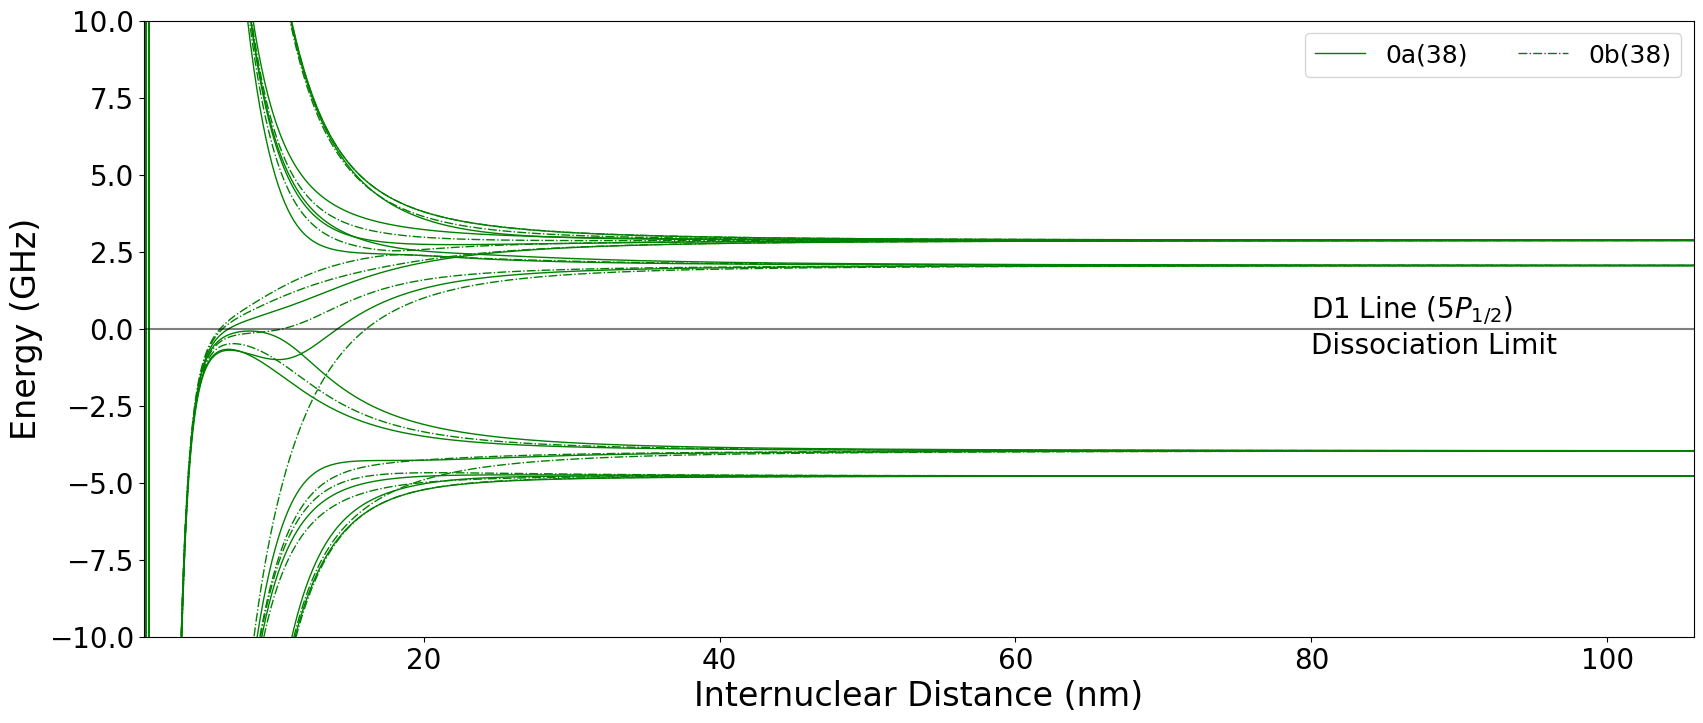

In [ ]:
def createCouplingMatrix(states, op, offset=-1/2, boBasis=None):
    num = len(states)
    coupleM = np.array([[0.0 for _ in states] for _ in states])
    for num, _ in enumerate(states):
        coupleM[num,num] = offset
    for num1, state1 in enumerate(states):
        misc.reportProgress(num1, len(states))
        for num2, state2 in enumerate(states):
            matElem = state2.T@op@state1
            if boBasis is not None:
                if boBasis[num1]['sigma'] != boBasis[num2]['sigma'] and not math.isclose(matElem, 0, abs_tol=0):
                    continue
                    print(boBasis[num1], '\n', boBasis[num2],'\n', matElem, '\n')
            coupleM[num1,num2] += matElem
    return coupleM    

In [826]:
# Full basis
phiIncluded=np.arange(1)
totalSpatialParityIncluded = ['a']
symmetrizedBases = {}

for phi in phiIncluded:
    for parity in totalSpatialParityIncluded:
        parityVal = 1 if parity == 'a' else -1
        for state in boBasisDict_fullSym:
            sigmav = g if state['sigma'] == 'g' else u
            if math.isclose(abs(state['|phi|']),phi):
                if (-1)**(state['i']+sigmav) == parityVal:
                    label = str(phi) + parity
                    if label not in symmetrizedBases:
                        symmetrizedBases[label] = []
                    symmetrizedBases[label].append(state)

In [ ]:
H_fs_phi = {}
H_hfs_phi = {}
for label, base in symmetrizedBases.items():
    IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates = []
    hfsStates = []
    print('Converting BO states to FS and HFS bases')
    for num, state in enumerate(base):
        print(state)
        misc.reportProgress(num, len(base))
        try:
            if state['Omega'] == 0 and state['|Lambda|'] != 0:
            #if True:
                sigma = g if state["sigma"] == "g" else u
                nuclearNums = [state['i'],state['iota'],state['i1'],state['i2'],]
                oalNums = (state["L"], state["|Lambda|"], 1, 0)
                spinNums = (state["S"], - state["|Lambda|"], 1/2, 1/2)
                mpstate1, _,_,_ = BohrOppenheimerToAtomic( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsiToJiop )
                hfsState1, _,_,_ = BohrOppenheimerToAtomic( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )
               
                nuclearNums = [state['i'],-state['iota'],state['i1'],state['i2'],]
                oalNums = (state["L"], - state["|Lambda|"], 1, 0)
                spinNums = (state["S"], state["|Lambda|"], 1/2, 1/2)
                mpstate2, _,_,_ = BohrOppenheimerToAtomic( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsiToJiop )
                hfsState2, _,_,_ = BohrOppenheimerToAtomic( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )

                sumsign = 1 if state['sigma_vxz'] == 1 else -1
                newMp = (mpstate1 + sumsign*mpstate2)/np.sqrt(2)
                newHfs = (hfsState1 + sumsign*hfsState2)/np.sqrt(2)
                #print(np.linalg.norm(newMp), np.linalg.norm(newHfs))
            else:
                sigma = g if state["sigma"] == "g" else u
                lambdaVal = np.sign(state['Omega']) * state["|Lambda|"]
                nuclearNums = [state['i'],state['iota'],state['i1'],state['i2'],]
                oalNums = (state["L"], lambdaVal, 1, 0)
                spinNums = (state["S"], state["Omega"] - lambdaVal, 1/2, 1/2)
                
                newMp, _,_,_ = BohrOppenheimerToAtomic( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsiToJiop )
                newHfs, _,_,_ = BohrOppenheimerToAtomic( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )
        except ValueError as err:
            print("ValueError: {0}".format(err))
            print(state)
            raise
        newMp /= np.linalg.norm(newMp)
        newHfs /= np.linalg.norm(newHfs)
        fsStates.append(newMp);
        hfsStates.append(newHfs)
    print('Complete\nCalcualting FS Energies')
    H_fs_phi[label] = createCouplingMatrix( fsStates, fsOperator, offset=-1/2)#, boBasis=boBasisDict )
    print('Complete\nCalcualting HFS Energies')
    H_hfs_phi[label] = createCouplingMatrix( hfsStates, hfsOperator, offset=0)#, boBasis=boBasisDict )
    print('Complete')
    time.sleep(1)

In [819]:
Rvals = np.linspace( 1*20*mc.a0, 100*20*mc.a0, 1000 )
energies = {}
for label, base in symmetrizedBases.items():
    IPython.display.clear_output(wait=True)
    print('\nLabel:', label)
    print('Calcualting Eigenvalues at every R')    
    energies[label] = np.zeros((len(Rvals), len(base)))
    for num, rv in enumerate(Rvals):
        misc.reportProgress(num, len(Rvals))
        rmatrix = createBOMatrix2_sym(C_3_val, rv, *base).astype(float) + H_fs_phi[label] * 2 * DeltaVal / 3 + H_hfs_phi[label] * mc.h
        eigVals, eigVectors = np.linalg.eigh(rmatrix)
        energies[label][num] = eigVals


Label: 1b
Calcualting Eigenvalues at every R


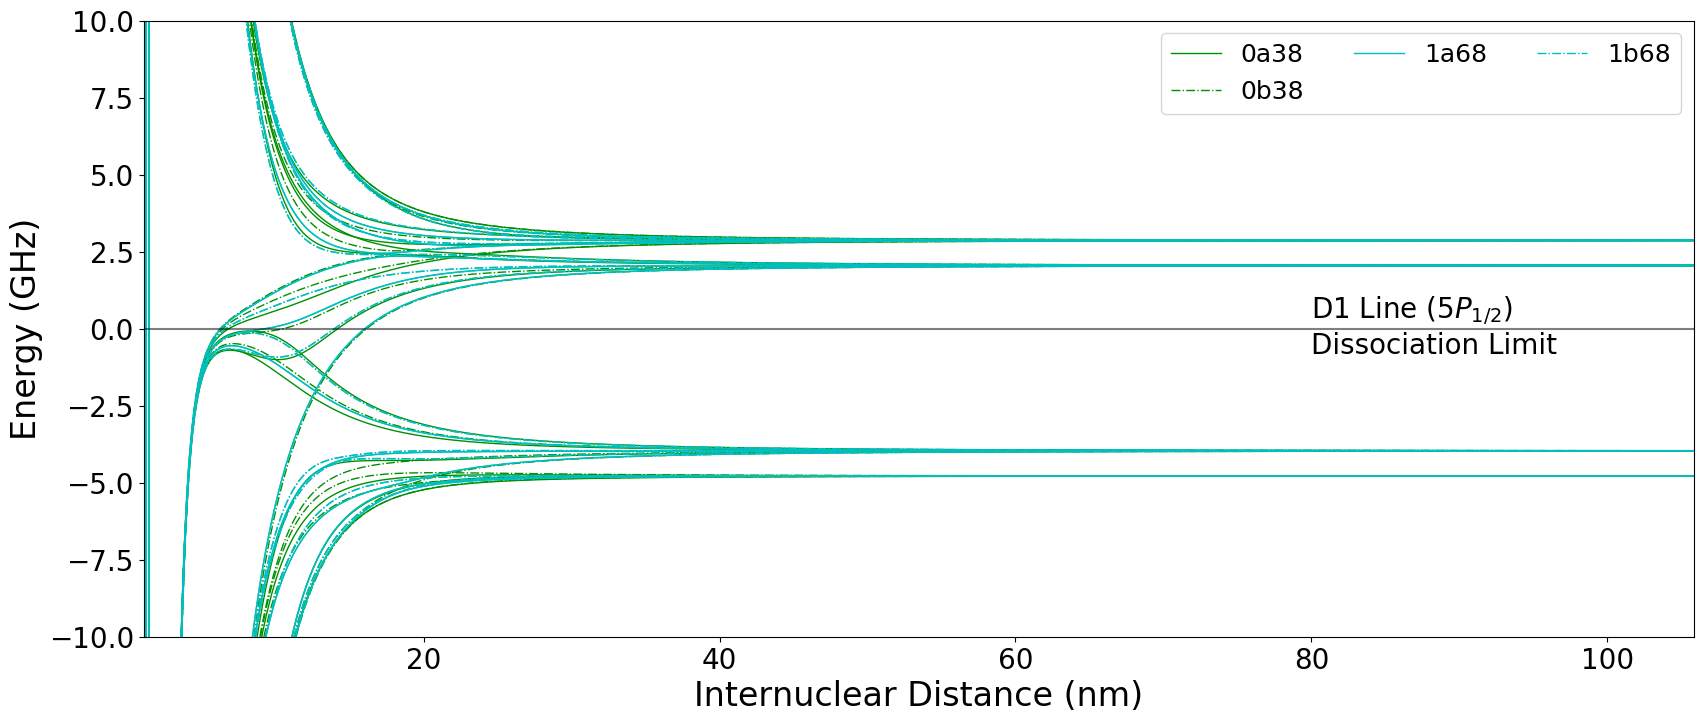

In [820]:
fig, ax = plt.subplots(figsize=(20,8))
gs = fig.add_gridspec(6,2)
yoffset = DeltaVal/mc.h
inc=1
#phiColors, _ = misc.getColors(len(phiBases)+1)#, cmStr='gnuplot')
phiColors=['#009000','c','b','purple', 'orange','r','k']
plotByGuCharacter=False
for label, base in symmetrizedBases.items():
    #if label not in ['0a', '0b']:
    #    continue
    color = phiColors[int(label[0])]
    linestyle = '-' if label[-1] == 'a' else '-.'
    for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
        ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoffset/1e9 , 
                color=color, linestyle=linestyle, linewidth=1, 
                label=label + str(len(base)) if datanum==0 else None)
        
leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
for text in leg.get_texts():
    text.set_color("k")
ax.axhline(0,color='k',alpha=0.5)
ax.text(80,-0.8, "D1 Line $(5P_{1/2})$\nDissociation Limit", fontsize=20, color='k')
ax.set_ylim((-10,10))
ax.set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
#ax.grid(alpha=0.5)
ax.set_xlabel('Internuclear Distance (nm)',fontsize=24)
#ax.set_xticks(fontsize=20)
ax.set_ylabel('Energy (GHz)',fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
#plt.savefig("Hyperfine_Splitting_Big_Picture.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

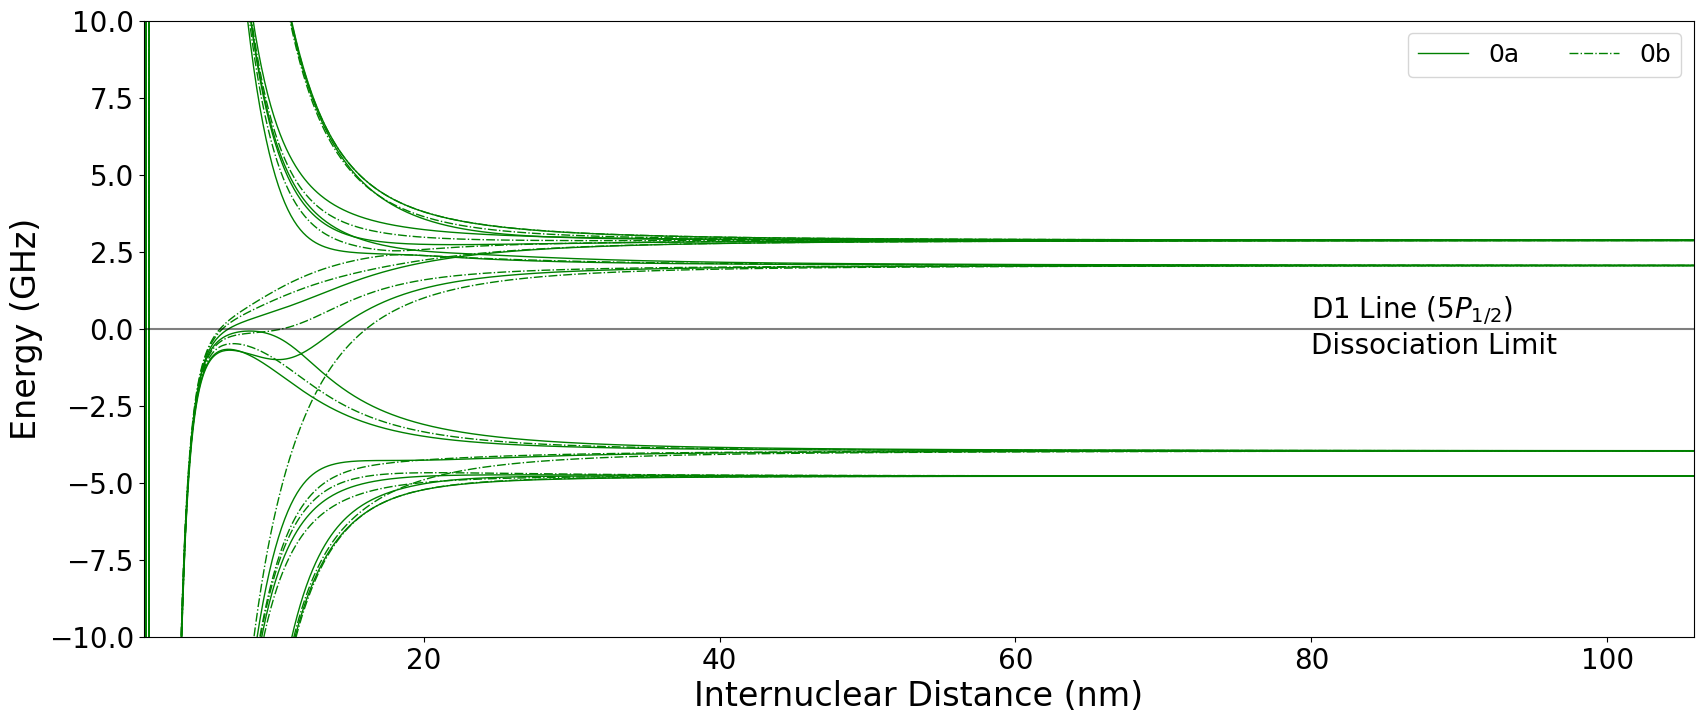

# Hyperfine structure

In [29]:
def lsiToJi(lsiBasis, jiBasis):
    # expects single atom bases
    assert(len(lsiBasis)==len(jiBasis))
    op = np.zeros((len(lsiBasis),len(jiBasis)))
    for lsnum, lsiState in enumerate(lsiBasis):
        for jnum, jiState in enumerate(jiBasis):
            # there should be some repeats because of the i values in each basis
            L, mL, S, mS, I_lsi, mI_lsi = [lsiState[key] for key in ['L','mL','S','mS', 'I', 'mI']]
            J, mJ, JL, JS, I_ji, mI_ji = [jiState[key] for key in ['J','mJ', 'L', 'S', 'I', 'mI']]
            # needing to handle this case makes me feel like the actual clebsh gordon coef should be written as
            # <L,mL,S,mS|J,mJ,L2,S2> or so instead of <L,mL,S,mS|J,mJ> as it usually is written. 
            if JL != L or JS != S or I_lsi != I_ji or mI_lsi != mI_ji:
                op[jnum,lsnum] = 0
            else:
                op[jnum,lsnum] += float(CG(L, mL, S, mS, J, mJ).doit())
    return op

In [30]:
def createBOMatrix2(C3, R, *states):
    # expects states to be a list of lists where the low level list has the values of L, Lambda, S,Sigma, and sigma.
    matrix = np.array([[0.0 for _ in states] for _ in states])
    # the matrix is diagonal.
    for num, state in enumerate(states):
        #L, Lambda, S, Sigma, sigma = state
        sigma = g if state["sigma"]=="g" else u
        p = (-1)**(state["S"]+sigma)
        L = state["L"]
        matrix[num,num] = -p*(3*state["Lambda"]**2-L*(L+1))/R**3 * C3
    return matrix

In [31]:
def createBOMatrix3(C3, R, *states):
    # expects states to be a list of lists where the low level list has the values of L, Lambda, S,Sigma, and sigma.
    matrix = np.array([[0.0 for _ in states] for _ in states])
    # the matrix is diagonal.
    for num, state in enumerate(states):
        #L, Lambda, S, Sigma, sigma = state
        sigma = g if state["sigma"]=="g" else u
        p = (-1)**(state["S"]+sigma)
        L = state["L"]
        matrix[num,num] = -p*(3*state["|Lambda|"]**2-L*(L+1))/R**3 * C3
    return matrix

In [32]:
def createLargerBasisRefs(Lvals, Svals, Ivals):
    fBasisRef = []
    for Lv in Lvals:
        for Sv in Svals:
            Jvals = set(np.arange(abs(Sv - Lv), Sv + Lv+1, 1))
            for Jv in Jvals:
                for Iv in Ivals:
                    FVals = set(np.arange(abs(Jv - Iv), Jv + Iv+1, 1))
                    for Fv in FVals:
                        for mf in np.arange(-Fv,Fv+1,1):
                            fBasisRef.append(multiplyableDict({"F":Fv, "mF": mf, "J":Jv, "L":Lv, "S":Sv, "I":Iv}))
    jiBasisRef = []
    for Lv in Lvals:
        for Sv in Svals:
            Jvals = set(np.arange(abs(Sv - Lv), Sv + Lv+1, 1))
            for Jv in Jvals:
                for mJ in np.arange(-Jv,Jv+1,1):
                    for Iv in Ivals:
                        for mi in np.arange(-Iv,Iv+1,1):
                            jiBasisRef.append(multiplyableDict({"J":Jv, "mJ":mJ, "L":Lv, "S":Sv, "I":Iv, "mI":mi}))
    lsiBasisRef = []
    for Lv in Lvals:
        for mL in np.arange(-Lv,Lv+1,1):
            for Sv in Svals:
                for mS in np.arange(-Sv, Sv+1,1):
                    for Iv in Ivals:
                        for mi in np.arange(-Iv,Iv+1,1):
                            lsiBasisRef.append(multiplyableDict({"L":Lv, "mL":mL, "S":Sv, "mS":mS, "I":Iv, "mI":mi}))
    return lsiBasisRef, jiBasisRef, fBasisRef, np.kron(lsiBasisRef,lsiBasisRef), np.kron(jiBasisRef,jiBasisRef), np.kron(fBasisRef,fBasisRef)

In [33]:
def createBornOppenheimerBasisFin():
    # Good quantum numbers: |c Lambda S Sigma I iota p>
    # why does L enter in here?
    Lv = 1
    iv = 3/2
    Svals = [0,1]
    boBasisRef = []
    for Sv in Svals:
        for Lambda in np.arange(0,Lv+1,1):
            for Sigma in np.arange(0,Sv+1,1):
                for Iv in np.arange(0,2*iv+1,1):
                    for iota in np.arange(0,Iv+1,1):
                        for parity in [-1,1]:
                            state = multiplyableDict({"Lambda": Lambda, "S":Sv, "Sigma":Sigma, "I":Iv, "iota":iota, 
                                                      "Omega":Sigma+Lambda, "phi": Sigma+Lambda+iota, "parity":parity })
                            if state not in boBasisRef:
                                boBasisRef.append(state)
    # sort by omega and sigma value. should probably change...
    #boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"]) + 100 * ord(state["sigma"])))
    boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"])))
    return boBasisRef

In [34]:
def createBornOppenheimerBasisHFS(Lvals, Svals, Ivals, sigmavals=["g","u"]):
    # Good quantum numbers: |c Lambda S Sigma I iota p>
    # why does L enter in here?
    boBasisRef = []
    for sigma in sigmavals:
        for Lv in Lvals:
            for Lambda in np.arange(-Lv,Lv+1,1):
                for Sv in Svals:
                    for Sigma in np.arange(-Sv, Sv+1,1):
                        for i1 in Ivals:
                            for i2 in Ivals:
                                for I in np.arange(abs(i2-i1), i2+i1+1,1):
                                    for iota in np.arange(-I,I+1,1):
                                        #state = multiplyableDict({"L":Lv, "Lambda": Lambda, "S":Sv, "Sigma":Sigma, "i":I, "iota":iota, "i1":i1, "i2":i2,
                                        #                          "Omega":Sigma+Lambda, "phi": Sigma+Lambda+iota })
                                        state = multiplyableDict({"L":Lv, "Lambda": Lambda, "sigma": sigma, "S":Sv, "Sigma":Sigma, "i":I, "iota":iota, "i1":i1, "i2":i2,
                                                                  "Omega":Sigma+Lambda, "phi": Sigma+Lambda+iota })
                                        if state not in boBasisRef:
                                            boBasisRef.append(state)
    # sort by omega and sigma value. should probably change...
    #boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"]) + 100 * ord(state["sigma"])))
    boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"])))
    return boBasisRef

In [35]:
def BornOppenheimerToAtomic( oalNums, spinNums, nuclearNums, sigma, 
                             lsBasis, basisChange=None ):
    """
    oalNums = (L, Lambda, la, lb)
    L is the total molecular orbital angular momentum \vec{L} = \vec{l1}+\vec{l2}
    Lambda is the projection of L on the internuclear axis.
    l1 is the orbital angular momentum of atom 1.
    l2 is the orbital angular momentum of atom 2.
    
    spinNums = (S, Sigma, sa, sb)
    S is the total molecular spin angular momentum \vec{s} = \vec{s1}+\vec{s2}
    Sigma is the projection of S on the internuclear axis.
    s1 is the spin angular momentum of atom 1.
    s2 is the spin angular momentum of atom 2.
    
    nuclearNums = (I, iota, ia, ib)
    
    sigma is the spatial symmetry of the electronic wavefunctions, 
        either 0 for g ("gerude" or symmetric wavefunctions) 
        or 1 for u ("ungerude" or antisymmetric wavefunctions)
    """
    (L, Lambda, la, lb) = oalNums
    (S, Sigma, sa, sb) = spinNums
    (I, iota, ia, ib) = nuclearNums
    state = 0
    p = (-1)**(S+sigma)
    indvCont = []
    lsiBasisStates = []
    otherBasisStates = []
    for mla in np.arange(-la,la+1,1):
        mlb = Lambda-mla
        if abs(mlb) > lb:
            continue
        #for mlb in np.arange(-lb,lb+1,1):
        for msa in np.arange(-sa,sa+1,1):
            msb = Sigma-msa
            if abs(msb) > sb:
                continue
            #        for msb in np.arange(-sb,sb+1,1):
            for mia in np.arange(-ia, ia+1, 1):
                mib = iota-mia
                if abs(mib) > ib:
                    continue
                # for mib in np.arange(-ib,ib+1,1):
                # CG notation is <j1,mj1,j2,mj2|j3,mj3>
                oalCoef = float(CG(la,mla,lb,mlb,L,Lambda).doit())
                spinCoef = float(CG(sa,msa,sb,msb,S,Sigma).doit())
                nuclearCoef = float(CG(ia,mia,ib,mib,I,iota).doit())
                aState1 = getColumnState(lsiBasis, {'L':la,'mL':mla,'S':sa,'mS':msa, 'I':ia,'mI':mia})
                bState1 = getColumnState(lsiBasis, {'L':lb,'mL':mlb,'S':sb,'mS':msb, 'I':ib,'mI':mib})
                aState2 = getColumnState(lsiBasis, {'L':lb,'mL':mlb,'S':sa,'mS':msa, 'I':ia,'mI':mia})
                bState2 = getColumnState(lsiBasis, {'L':la,'mL':mla,'S':sb,'mS':msb, 'I':ib,'mI':mib})
                if oalCoef != 0 and nuclearCoef != 0 and spinCoef != 0:
                    lsiBasisStates.append([aState1, bState1, aState2, bState2])
                if basisChange is not None:
                    aState1 = basisChange@aState1
                    bState1 = basisChange@bState1
                    aState2 = basisChange@aState2
                    bState2 = basisChange@bState2
                newpart = nuclearCoef*oalCoef*spinCoef * (np.kron(aState1,bState1) + p * np.kron(aState2,bState2))
                state += newpart
                if oalCoef != 0 and nuclearCoef != 0 and spinCoef != 0:
                    indvCont.append(newpart)
                    otherBasisStates.append([aState1, bState1, aState2, bState2])

    if np.linalg.norm(state) == 0:
        raise ValueError("State has zero norm!")
    state /= np.linalg.norm(state)
    return state, np.array(indvCont), np.array(lsiBasisStates), np.array(otherBasisStates)

In [36]:
def fsOp(basis):
    # expects a two-particle basis, so each element of the basis should 
    # have J_1, mJ_1, L_1, S_1, and J_2, mJ_2, L_2, S_2 values.
    op = np.zeros((len(basis),len(basis)))
    J1,mJ1,L1,S1,J2,mJ2,L2,S2 = [0 for _ in range(8)]
    names = ['J','mJ','L','S']
    for s1num, state1 in enumerate(basis):
        qNums = [0 for _ in range(8)]
        for num, name in enumerate(names):
            qNums[num] = state1[name+"_1"]
        for num, name in enumerate(names):
            qNums[num+4] = state1[name+"_2"]
        J1,mJ1,L1,S1,J2,mJ2,L2,S2 = qNums
        # the matrix element is A/2 (L1 . S1 + L2 . S2), A=1
        val = 0.5*(J1*(J1+1)-L1*(L1+1)-S1*(S1+1)+ J2*(J2+1)-L2*(L2+1)-S2*(S2+1) )
        op[s1num,s1num] = val
    assert(np.count_nonzero(op - np.diag(np.diagonal(op)))==0)
    return op

In [37]:
def hfsOp(basis, A_12, A_gs, F3E, F2E, F1E, F0E):
    # expects a two-particle basis, so each element of the basis should 
    # have J_1, mJ_1, L_1, S_1, and J_2, mJ_2, L_2, S_2 values.
    op = np.zeros((len(basis),len(basis)))
    f1,mf1,j1,i1,f2,mf2,j2,i2 = [0 for _ in range(8)]
    names = ['F','mF','J','I']
    for s1num, state1 in enumerate(basis):
        qNums = [0 for _ in range(8)]
        for num, name in enumerate(names):
            qNums[num] = state1[name+"_1"]
        for num, name in enumerate(names):
            qNums[num+4] = state1[name+"_2"]
        f1,mf1,j1,i1,f2,mf2,j2,i2 = qNums
        A1 = A_12 if state1["L_1"] == 1 else A_gs
        E1 = A1/2 * (f1*(f1+1)-j1*(j1+1)-i1*(i1+1)) if state1["J_1"] != 3/2 else (F3E if f1==3 else (F2E if f1==2 else (F1E if f1==1 else F0E)))
        A2 = A_12 if state1["L_2"] == 1 else A_gs
        E2 = A2/2 * (f2*(f2+1)-j2*(j2+1)-i2*(i2+1)) if state1["J_2"] != 3/2 else (F3E if f2==3 else (F2E if f2==2 else (F1E if f2==1 else F0E)))
        op[s1num,s1num] = E1 + E2
    return op

In [38]:
def getColumnState(basis, quantumNums):
    assert(len(basis[0])==len(quantumNums))
    colState = [[0] for _ in range(len(basis))]
    for num, state in enumerate(basis):
        match = True
        for qnum, val in quantumNums.items():
            if val != state[qnum]:
                match = False
        if match:
            colState[num][0] = 1
            return colState
    raise ValueError("No Match! nums were" + str(quantumNums))

In [39]:
def createMovrePichlerMatrix(states, fsOperator, offset=-1/2):
    num = len(states)
    op = np.array([[0.0 for _ in states] for _ in states])
    for num, _ in enumerate(states):
        op[num,num] = offset
    for num1, state1 in enumerate(states):
        for num2, state2 in enumerate(states):
            op[num1,num2] += state2.T@fsOperator@state1
    return op    

In [40]:
def jiTof(jiBasis, fBasis):
    # expects single atom bases
    assert(len(jiBasis)==len(fBasis))
    op = np.zeros((len(jiBasis),len(fBasis)))
    for jnum, jiState in enumerate(jiBasis):
        for fnum, fState in enumerate(fBasis):
            J, mJ, L, S, I, mI = [jiState[key] for key in ['J','mJ', 'L', 'S', 'I', 'mI']]
            F, mF, Jf, If, Lf, Sf = [fState[key] for key in ['F','mF','J','I', 'L', 'S']]
            # needing to handle this case makes me feel like the actual clebsh gordon coef should be written as
            # <L,mL,S,mS|J,mJ,L2,S2> or so instead of <L,mL,S,mS|J,mJ> as it usually is written. 
            if Jf != J or If != I or Lf != L or Sf != S:
                op[fnum, jnum] = 0
            else:
                res = float(CG(J, mJ, I, mI, F, mF).doit())
                op[fnum, jnum] += float(CG(J, mJ, I, mI, F, mF).doit())
    return op

In [41]:
def createCouplingMatrix(states, op, offset=-1/2, boBasis=None):
    num = len(states)
    coupleM = np.array([[0.0 for _ in states] for _ in states])
    for num, _ in enumerate(states):
        coupleM[num,num] = offset
    for num1, state1 in enumerate(states):
        misc.reportProgress(num1, len(states))
        for num2, state2 in enumerate(states):
            matElem = state2.T@op@state1
            if boBasis is not None:
                if boBasis[num1]['sigma'] != boBasis[num2]['sigma'] and not math.isclose(matElem, 0, abs_tol=0):
                    continue
                    print(boBasis[num1], '\n', boBasis[num2],'\n', matElem, '\n')
            coupleM[num1,num2] += matElem
    return coupleM    

In [42]:
A_gs = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
A_12 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
A_32 = (mc.Rb87_5P32_ToF3-mc.Rb87_5P32_ToF0)/6

In [43]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [44]:
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = createLargerBasisRefs([0,1], [1/2], [3/2])
fsOperator = fsOp(jiBasis2Atom)
hfsOperator = hfsOp(fBasis2Atom, A_12, A_gs, mc.Rb87_5P32_ToF3,mc.Rb87_5P32_ToF2,mc.Rb87_5P32_ToF1,mc.Rb87_5P32_ToF0)
lsiToJiop = lsiToJi(lsiBasis,jiBasis)
jiToFOp = jiTof(jiBasis, fBasis)
boBasisDict_g = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['g'])
boBasisDict_u = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['u'])
boBasisDict_full = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g', 'u'])

In [45]:
def createBornOppenheimerBasisHFS_SuperSym(Lvals, Svals, Ivals, sigmavals=["g","u"]):
    # Good quantum numbers: |c Lambda S Sigma I iota p>
    # why does L enter in here?
    boBasisRef = []
    for sigma in sigmavals:
        for Lv in Lvals:
            for Lambda in np.arange(-Lv,Lv+1,1):
                for Sv in Svals:
                    for Sigma in np.arange(-Sv, Sv+1,1):
                        for i1 in Ivals:
                            for i2 in Ivals:
                                for Iv in np.arange(abs(i2-i1), i2+i1+1,1):
                                    for iota in np.arange(-Iv,Iv+1,1):
                                        #state = multiplyableDict({"L":Lv, "Lambda": Lambda, "S":Sv, "Sigma":Sigma, "i":I, "iota":iota, "i1":i1, "i2":i2,
                                        #                          "Omega":Sigma+Lambda, "phi": Sigma+Lambda+iota })
                                        Omega = Sigma+Lambda
                                        phi  = Sigma+Lambda+iota
                                        if Lambda != 0 and Omega==0:
                                            for sigmav in [-1,1]:
                                                state = multiplyableDict({"L":Lv, "|Lambda|": abs(Lambda), "sigma": sigma, "S":Sv, "|Sigma|":abs(Sigma), "i":Iv, "|iota|":abs(iota), "i1":i1, "i2":i2,
                                                                          "|Omega|":abs(Omega), "phi":phi , "sigma_vxz": sigmav, 'sigma_v2xz':sigmav*(-1)**(Iv-iota)})
                                                if state not in boBasisRef:
                                                    boBasisRef.append(state)
                                        elif Omega != 0 and phi == 0:
                                                for sigmav2 in [-1,1]:
                                                    state = multiplyableDict({"L":Lv, "|Lambda|": abs(Lambda), "sigma": sigma, "S":Sv, "|Sigma|":abs(Sigma), "i":Iv, "|iota|":abs(iota), "i1":i1, "i2":i2,
                                                                              "|Omega|":abs(Omega), "phi":phi , "sigma_vxz": (-1)**(Lv-Lambda+Sv-Sigma), 'sigma_v2xz':sigmav2})
                                                    if state not in boBasisRef:
                                                        boBasisRef.append(state)
                                        else:
                                            state = multiplyableDict({"L":Lv, "|Lambda|": abs(Lambda), "sigma": sigma, "S":Sv, "|Sigma|":abs(Sigma), "i":Iv, "|iota|":abs(iota), "i1":i1, "i2":i2,
                                                                      "|Omega|":abs(Omega), "phi": phi, "sigma_vxz": (-1)**(Lv-Lambda+Sv-Sigma), "sigma_v2xz":(-1)**(Lv-Lambda+Sv-Sigma+Iv-iota) })
                                            if state not in boBasisRef:
                                                boBasisRef.append(state)
    # sort by omega and sigma value. should probably change...
    #boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"]) + 100 * ord(state["sigma"])))
    boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["|Omega|"])))
    return boBasisRef

In [46]:
def createBornOppenheimerBasisHFS_Sym2(Lvals, Svals, Ivals, sigmavals=["g","u"]):
    # Good quantum numbers: |c Lambda S Sigma I iota p>
    # why does L enter in here?
    boBasisRef = []
    for sigma in sigmavals:
        for Lv in Lvals:
            for Lambda in np.arange(-Lv,Lv+1,1):
                for Sv in Svals:
                    for Sigma in np.arange(-Sv, Sv+1,1):
                        for i1 in Ivals:
                            for i2 in Ivals:
                                for I in np.arange(abs(i2-i1), i2+i1+1,1):
                                    for iota in np.arange(-I,I+1,1):
                                        Omega = Sigma+Lambda
                                        absPhi  = abs(Sigma+Lambda+iota)
                                        if Lambda != 0 or Sigma != 0:
                                            for sigmav in [-1,1]:
                                                state = multiplyableDict({"L":Lv, "|Lambda|": abs(Lambda), "sigma": sigma, "S":Sv, "|Sigma|":abs(Sigma), "i":I, "|iota|":abs(iota), "i1":i1, "i2":i2,
                                                                          "|Omega|":abs(Omega), "|phi|":absPhi , "sigma_vxz": sigmav })
                                                if state not in boBasisRef:
                                                    boBasisRef.append(state)
                                        else:
                                            state = multiplyableDict({"L":Lv, "|Lambda|": abs(Lambda), "sigma": sigma, "S":Sv, "|Sigma|":abs(Sigma), "i":I, "|iota|":abs(iota), "i1":i1, "i2":i2,
                                                                      "|Omega|":abs(Omega), "|phi|": absPhi, "sigma_vxz": (-1)**(Lv-Lambda+Sv-Sigma) })
                                            if state not in boBasisRef:
                                                boBasisRef.append(state)
    # sort by omega and sigma value. should probably change...
    boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["|Omega|"])))
    return boBasisRef

### think can remove...

In [ ]:
print(len(caseASymFs))
for state in caseASymFs:
    if state['|Lambda|'] == 0 and state['|Sigma|'] == 0:
        # only one blind state contributes
        stateBlind = {}
        for key in state.keys():
            if key[0] != "|":
                stateBlind[key] = state[key]
            else:
                stateBlind[key[1:-1]] = 0
    else:
        # else two state contribute
        stateBlind1 = {}
        stateBlind2 = {}
        for key in state.keys():
            if key[0] != "|":
                stateBlind1[key] = state[key]
                stateBlind2[key] = state[key]
            else:
                if key == "|Lambda|":
                    stateBlind1[key[1:-1]] = state[key]
                    stateBlind2[key[1:-1]] = -state[key]
                elif key == "|Sigma|":
                    stateBlind1[key[1:-1]] = state["|Omega|"] - stateBlind1['Lambda']
                    stateBlind2[key[1:-1]] = -state["|Omega|"] - stateBlind2['Lambda']
                elif key == "|Omega|":
                    stateBlind1["Omega"] = state["|Omega|"]
                    stateBlind2["Omega"] = -state["|Omega|"]
        pass    

In [430]:
print(caseABlind[0].keys())
caseAGoodSigmaV = {}
for state in caseABlind:
    label = '|' + ''.join(str(val) for _,val in state.items()) + '>'
    if state['Omega'] == 0 and state['Lambda'] == 0:
        pass
        #print('sigma_v =',(-1)**(state['L']-state['Lambda']+state['S']-state['Sigma']), ':', label)    
    elif state['Omega'] == 0 and state['Lambda'] != 0:
        state1 = state
        state2 = state
        state2['Lambda'] *= -1
        state2['Sigma'] *= -1
        label2 = '|' + ''.join(str(val) for _,val in state2.items()) + '>'
        for parity in [-1,1]:
            print('sigma_v =', parity, ':', label, '+' if parity==1 else '-', label2)            
    elif state['Omega'] == 1:
        pass
        #print((-1)**(state['L']-state['Lambda']+state['S']-state['Sigma']),label)    
    else:
        print('...')

dict_keys(['L', 'Lambda', 'sigma', 'S', 'Sigma', 'i', 'iota', 'i1', 'i2', 'Omega', 'phi'])
sigma_v = -1 : |1-1g11000000> - |11g1-1000000>
sigma_v = 1 : |1-1g11000000> + |11g1-1000000>
sigma_v = -1 : |11g1-1000000> - |1-1g11000000>
sigma_v = 1 : |11g1-1000000> + |1-1g11000000>
sigma_v = -1 : |1-1u11000000> - |11u1-1000000>
sigma_v = 1 : |1-1u11000000> + |11u1-1000000>
sigma_v = -1 : |11u1-1000000> - |1-1u11000000>
sigma_v = 1 : |11u1-1000000> + |1-1u11000000>
...
...
...
...
...
...
...
...
...
...


In [ ]:
caseAGoodSigmav1

finBasis:
phi, i, i1, i2, L, S, 

In [368]:
boBasisDict_full[0]

{'L': 1,
 'Lambda': -1,
 'sigma': 'g',
 'S': 1,
 'Sigma': 1,
 'i': 0.0,
 'iota': -0.0,
 'i1': 1.5,
 'i2': 1.5,
 'Omega': 0,
 'phi': 0.0}

In [866]:
state = caseABlindHfs[0] #
sigma = g if state["sigma"] == "g" else u
nuclearNums = [state['i'],state['iota'],state['i1'],state['i2'],]
LambdaVal = state["Lambda"]
SigmaVal = state["Sigma"]
oalNums = (state["L"], LambdaVal, 1, 0)
spinNums = (state["S"], SigmaVal, 1/2, 1/2)
#print(spin)
hfsState1, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis )

state = caseABlindHfs[48] #
sigma = g if state["sigma"] == "g" else u
nuclearNums = [state['i'],state['iota'],state['i1'],state['i2'],]
LambdaVal = state["Lambda"]
SigmaVal = state["Sigma"]
oalNums = (state["L"], LambdaVal, 1, 0)
spinNums = (state["S"], SigmaVal, 1/2, 1/2)
hfsState2, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis )

symState = hfsState1 - hfsState2

print((hfsRflSymOp@symState==-symState).all(),(hfsRflSymOp@symState==symState).all())

False True


In [ ]:
#state = base[:][0]
#print(state)
#newMp1, newHfs1 = BohrOppenheimerToAtomic_goodOmega(state, state['|Omega|'])
#print(mpRflSymOp.shape)
for num, (rs, s) in enumerate(zip(hfsRflSymOp@hfsState1,hfsState1)):
    #if rs != 0 or s != 0:
        #print( lsiBasis2Atom[num], rs, s )
    if s != 0:
        print(lsiBasis2Atom[num], rs, s)

In [ ]:
state = base[:][0]
print(state)
newMp1, newHfs1 = BohrOppenheimerToAtomic_goodOmega(state, state['Omega'])
#print(mpRflSymOp.shape)
for num, (rs, s) in enumerate(zip(mpRflSymOp@newMp1,newMp1)):
    #if rs != 0 or s != 0:
        #print( lsiBasis2Atom[num], rs, s )
    if s != 0:
        print(lsiBasis2Atom[num], rs, s)

### current work...

In [48]:
def BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsBasis, basisChange=None ):
    state = 0
    indvCont = []
    lsiBasisStates = []
    otherBasisStates = []
    (L, Lambda, la, lb) = oalNums
    (S, Sigma, sa, sb) = spinNums
    (I, iota, ia, ib) = nuclearNums
    p_ = (-1)**(S+sigma)
    for mla in np.arange(-la,la+1,1):
        mlb = Lambda-mla
        if abs(mlb) > lb:
            continue
        for msa in np.arange(-sa,sa+1,1):
            msb = Sigma-msa
            if abs(msb) > sb:
                continue
            for mia in np.arange(-ia, ia+1, 1):
                mib = iota-mia
                if abs(mib) > ib:
                    continue
                # for mib in np.arange(-ib,ib+1,1):
                # CG notation is <j1,mj1,j2,mj2|j3,mj3>
                oalCoef = float(CG(la,mla,lb,mlb,L,Lambda).doit())
                spinCoef = float(CG(sa,msa,sb,msb,S,Sigma).doit())
                nuclearCoef = float(CG(ia,mia,ib,mib,I,iota).doit())
                aState1 = getColumnState(lsiBasis, {'L':la,'mL':mla,'S':sa,'mS':msa, 'I':ia,'mI':mia})
                bState1 = getColumnState(lsiBasis, {'L':lb,'mL':mlb,'S':sb,'mS':msb, 'I':ib,'mI':mib})
                aState2 = getColumnState(lsiBasis, {'L':lb,'mL':mlb,'S':sa,'mS':msa, 'I':ia,'mI':mia})
                bState2 = getColumnState(lsiBasis, {'L':la,'mL':mla,'S':sb,'mS':msb, 'I':ib,'mI':mib})
                if oalCoef != 0 and nuclearCoef != 0 and spinCoef != 0:
                    lsiBasisStates.append([aState1, bState1, aState2, bState2])
                if basisChange is not None:
                    aState1 = basisChange@aState1
                    bState1 = basisChange@bState1
                    aState2 = basisChange@aState2
                    bState2 = basisChange@bState2
                newpart = nuclearCoef*oalCoef*spinCoef * (np.kron(aState1,bState1) + p_ * np.kron(aState2,bState2))
                state += newpart
                if oalCoef != 0 and nuclearCoef != 0 and spinCoef != 0:
                    indvCont.append(newpart)
                    otherBasisStates.append([aState1, bState1, aState2, bState2])
    if np.linalg.norm(state) == 0:
        raise ValueError("State has zero norm!")
    state /= np.linalg.norm(state)
    return state, np.array(indvCont), np.array(lsiBasisStates), np.array(otherBasisStates)

In [49]:
def caseASymFsToBlind(state, blindBasis, indexes=False):
    if state['|Lambda|'] == 0 and state['|Sigma|'] == 0:
        stateBlind = {}
        for key in state.keys():
            if key == "sigma_vxz" or key == "sigma_v2xz":
                pass
            elif key == '|iota|':
                stateBlind['iota'] = state['phi']
            elif key[0] != "|":
                stateBlind[key] = state[key]
            else:
                stateBlind[key[1:-1]] = 0
        #print(state)
        if indexes:
            return [blindBasis.index(stateBlind)], [1]
        return '|'+''.join([str(val) for key, val in stateBlind.items()])+'>'
    else:
        # else two state contribute
        stateBlind1 = {}
        stateBlind2 = {} 
        for key in state.keys():
            if key == "sigma_vxz" or key == "sigma_v2xz":
                pass
            elif key[0] != "|":
                stateBlind1[key] = state[key]
                stateBlind2[key] = state[key]
            elif key == "|Lambda|":
                stateBlind1[key[1:-1]] = state[key]
                stateBlind2[key[1:-1]] = -state[key]
            elif key == "|Sigma|":
                stateBlind1[key[1:-1]] = state["|Omega|"] - stateBlind1['Lambda']
                stateBlind2[key[1:-1]] = -state["|Omega|"] - stateBlind2['Lambda']
            elif key == "|Omega|":
                stateBlind1["Omega"] = state["|Omega|"]
                stateBlind2["Omega"] = -state["|Omega|"]
            elif key == "phi":
                stateBlind1["phi"] = state["phi"]
                stateBlind2["phi"] = -state["phi"]
            elif key == "|iota|":
                stateBlind1["iota"] = state["phi"]-state["|Omega|"]
                stateBlind2["iota"] = state["phi"]-(-state["|Omega|"])
        sign = '+' if state['sigma_vxz'] == 1 else '-'
        if indexes:
            return [blindBasis.index(stateBlind1), blindBasis.index(stateBlind2)], [1,1 if sign == "+" else -1]
            #return str(blindBasis.index(stateBlind1)) + sign + str(blindBasis.index(stateBlind2))
        return '|'+''.join([str(val) for key, val in stateBlind1.items()])+'>'+sign+'|'+''.join([str(val) for key, val in stateBlind2.items()])+'>'

In [50]:
boBasisDict_fullSuperSym = createBornOppenheimerBasisHFS_SuperSym([1],[0,1], [3/2], sigmavals=['g', 'u'])
boBasisDict_fullSym = createBornOppenheimerBasisHFS_Sym([1],[0,1], [3/2], sigmavals=['g', 'u'])
boBasisDict = boBasisDict_fullSym
boBasisDict_full = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['g', 'u'])

In [51]:
# Full basis, fully symmetrized
phiIncluded=np.arange(1)
totalSpatialParityIncluded = ['a', 'b']
reflectionParityIncluded = [1, 2]
symmetrizedBases = {}

for phi in phiIncluded:
    for parity in totalSpatialParityIncluded:
        for rParity in reflectionParityIncluded:
            parityVal = 1 if parity == 'a' else -1
            for state in boBasisDict_fullSuperSym:
                sigmav = g if state['sigma'] == 'g' else u
                if math.isclose(abs(state['phi']),phi): # if phi match
                    if (-1)**(state['i']+sigmav) == parityVal: # if inversion parity match
                        if (state['sigma_v2xz'] == 1 and rParity == 1) or (state['sigma_v2xz'] == -1 and rParity == 2): # if reflection parity match:
                            label = str(phi) + parity + str(rParity)
                            if label not in symmetrizedBases:
                                symmetrizedBases[label] = []
                            symmetrizedBases[label].append(state)

In [52]:
H_fs_phi = {}
H_hfs_phi = {}
for label, base in symmetrizedBases.items():
    IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates = []
    hfsStates = []
    print('Converting BO states to FS and HFS bases')
    for num, state in enumerate(base[:]):
        misc.reportProgress(num, len(base))
        sigma = g if state["sigma"] == "g" else u
        I, iota, i1, i2 = [state[k] for k in ["i","|iota|","i1","i2"]]
        mpstate, indvCont, lsiBasisStates, jiBasisStates = BornOppenheimerToAtomic( (state["L"], state["|Lambda|"], 1, 0), 
                                                                                   (state["S"], state["|Omega|"] - state["|Lambda|"], 1/2, 1/2), 
                                                                                   (I, iota, i1, i2), sigma, lsiBasis, basisChange=lsiToJiop )
        hfsState, indvCont, lsiBasisStates, fBasisStates = BornOppenheimerToAtomic( (state["L"], state["|Lambda|"], 1, 0), 
                                                                                   (state["S"], state["|Omega|"] - state["|Lambda|"], 1/2, 1/2), 
                                                                                   (I, iota, i1, i2), sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )
        if np.isnan(mpstate[0]):
            continue
        fsStates.append(mpstate);
        hfsStates.append(hfsState)
    print('Complete\nCalcualting FS Energies')
    H_fs_phi[label] = createCouplingMatrix( fsStates, fsOperator, offset=-1/2)#, boBasis=boBasisDict )
    print('Complete\nCalcualting HFS Energies')
    H_hfs_phi[label] = createCouplingMatrix( hfsStates, hfsOperator, offset=0)#, boBasis=boBasisDict )
    print('Complete')
    time.sleep(1)

Working on states of symmetry 0b2. 19 states
Converting BO states to FS and HFS bases
Complete                  
Calcualting FS Energies
Complete                  
Calcualting HFS Energies
Complete                  


In [53]:
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = createLargerBasisRefs([0,1], [1/2], [3/2])
fsOperator = fsOp(jiBasis2Atom)
hfsOperator = hfsOp(fBasis2Atom, A_12, A_gs, mc.Rb87_5P32_ToF3, mc.Rb87_5P32_ToF2,mc.Rb87_5P32_ToF1,mc.Rb87_5P32_ToF0)
lsiToJiop = lsiToJi(lsiBasis,jiBasis)
jiToFOp = jiTof(jiBasis, fBasis)
#boBasisDict_g = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['g'])
#boBasisDict_u = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['u'])
#boBasisDict_full = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['g', 'u'])
boBasisDict_full = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['g', 'u'])
#boBasisDict=boBasisDict_full

In [54]:
caseABlindFs = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g', 'u'])
caseASymFs = createBornOppenheimerBasisHFS_Sym2([1],[0,1],[0], sigmavals=['g','u'])
caseABlindHfs = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['g', 'u'])
caseASymHfs = createBornOppenheimerBasisHFS_SuperSym([1],[0,1],[3/2], sigmavals=['g','u'])

In [55]:
hfsRflSymOp = hfsReflectionOp(lsiBasis2Atom);
mpRflSymOp = mpReflectionOp(lsiBasis2Atom);

In [56]:
def caseASymHfsToBlind(state, blindBasis, indexes=False):
    if state['|Omega|'] == 0 and state['|iota|'] == 0:
        return caseASymFsToBlind(state, blindBasis, indexes=indexes)
    else:
        stateBlind1, stateBlind2 = {},{}        
        for key in state.keys():
            if key == "sigma_vxz" or key == "sigma_v2xz":
                pass
            elif key[0] != "|":
                stateBlind1[key] = state[key]
                stateBlind2[key] = state[key]
            elif key == "|Lambda|":
                pass
            elif key == "|Sigma|":
                pass
            elif key == "|Omega|":
                pass
            elif key == "phi":
                stateBlind1["phi"] = state["phi"]
                stateBlind2["phi"] = -state["phi"]
            elif key == "|iota|":
                stateBlind1["iota"] = state["|iota|"]
                stateBlind2["iota"] = -state["|iota|"]
        stateBlind1['Omega'] = stateBlind1['phi'] - stateBlind1['iota']
        stateBlind1['Lambda'] = (1 if stateBlind1['Omega']>0 else -1)*state['|Lambda|']
        stateBlind1['Sigma'] = stateBlind1['Omega'] - stateBlind1['Lambda']
        
        stateBlind2['Omega'] = stateBlind2['phi'] - stateBlind2['iota']
        stateBlind2['Lambda'] = (1 if stateBlind2['Omega']>0 else -1)*state['|Lambda|']
        stateBlind2['Sigma'] = stateBlind2['Omega'] - stateBlind2['Lambda']
        # Im confused about why this seems to need to involve sigma_vxz to work.
        #sign = '+' if state['sigma_v2xz']*state['sigma_vxz']*(-1)**(state['i']-state['|iota|'])==1 else '-'
        #sign = '+' if state['sigma_v2xz']*(-1)**(state['i']-state['|iota|'])==1 else '-'
        sign = '+' if state['sigma_v2xz'] == 1 else '-'
        if indexes:
            return [blindBasis.index(stateBlind1), blindBasis.index(stateBlind2)], [1,1 if sign == "+" else -1]
            #return str() + sign + str(blindBasis.index(stateBlind2))
        return '|'+''.join([str(val) for key, val in stateBlind1.items()])+'>'+sign+'|'+''.join([str(val) for key, val in stateBlind2.items()])+'>'

In [57]:
for stateCaseA_Sym in caseASymHfs:
    if stateCaseA_Sym['phi'] == 0 and stateCaseA_Sym['sigma_v2xz']==-1:
        indexes, signs = caseASymHfsToBlind(stateCaseA_Sym, caseABlindHfs, indexes=True)
        resultStr = ""
        symState = 0
        for index, sign in zip(indexes,signs):
            signStr = '+' if sign == 1 else '-'
            resultStr += signStr + str(index)
            state = caseABlindHfs[index] #
            sigma = g if state["sigma"] == "g" else u
            nuclearNums = [state['i'],state['iota'],state['i1'],state['i2'],]
            oalNums = (state["L"], state["Lambda"], 1, 0)
            spinNums = (state["S"], state["Sigma"], 1/2, 1/2)
            hfsState1, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis )
            symState += sign * hfsState1
        antiSym = (hfsRflSymOp@symState==-symState).all()
        sym = (hfsRflSymOp@symState==symState).all()
        assert(antiSym or sym)
        assert(not (antiSym and sym))
        if sym:
            print(stateCaseA_Sym,resultStr,': Symmetric')
        else:
            print(stateCaseA_Sym,resultStr,': AntiSymmetric')
        resultString = resultStr[:-1]

{'L': 1, '|Lambda|': 1, 'sigma': 'g', 'S': 1, '|Sigma|': 1, 'i': 0.0, '|iota|': 0.0, 'i1': 1.5, 'i2': 1.5, '|Omega|': 0, 'phi': 0.0, 'sigma_vxz': -1, 'sigma_v2xz': -1.0} +48-0 : Symmetric
{'L': 1, '|Lambda|': 1, 'sigma': 'g', 'S': 1, '|Sigma|': 1, 'i': 1.0, '|iota|': 0.0, 'i1': 1.5, 'i2': 1.5, '|Omega|': 0, 'phi': 0.0, 'sigma_vxz': 1, 'sigma_v2xz': -1.0} +50+2 : Symmetric
{'L': 1, '|Lambda|': 1, 'sigma': 'g', 'S': 1, '|Sigma|': 1, 'i': 2.0, '|iota|': 0.0, 'i1': 1.5, 'i2': 1.5, '|Omega|': 0, 'phi': 0.0, 'sigma_vxz': -1, 'sigma_v2xz': -1.0} +54-6 : Symmetric
{'L': 1, '|Lambda|': 1, 'sigma': 'g', 'S': 1, '|Sigma|': 1, 'i': 3.0, '|iota|': 0.0, 'i1': 1.5, 'i2': 1.5, '|Omega|': 0, 'phi': 0.0, 'sigma_vxz': 1, 'sigma_v2xz': -1.0} +60+12 : Symmetric
{'L': 1, '|Lambda|': 0, 'sigma': 'g', 'S': 0, '|Sigma|': 0, 'i': 0.0, '|iota|': 0.0, 'i1': 1.5, 'i2': 1.5, '|Omega|': 0, 'phi': 0.0, 'sigma_vxz': -1, 'sigma_v2xz': -1.0} +16 : Symmetric
{'L': 1, '|Lambda|': 0, 'sigma': 'g', 'S': 0, '|Sigma|': 0, 'i'

In [58]:
for stateCaseA_Sym in caseASymHfs:
    if stateCaseA_Sym['phi'] == 0 and stateCaseA_Sym['sigma_v2xz']==1:
        indexes, signs = caseASymHfsToBlind(stateCaseA_Sym, caseABlindHfs, indexes=True)
        resultStr = ""
        symState = 0
        for index, sign in zip(indexes,signs):
            resultStr += str(sign*index) + "+"
            state = caseABlindHfs[index] #
            sigma = g if state["sigma"] == "g" else u
            nuclearNums = [state['i'],state['iota'],state['i1'],state['i2'],]
            oalNums = (state["L"], state["Lambda"], 1, 0)
            spinNums = (state["S"], state["Sigma"], 1/2, 1/2)
            hfsState1, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis )
            symState += sign * hfsState1
        antiSym = (hfsRflSymOp@symState==-symState).all()
        sym = (hfsRflSymOp@symState==symState).all()
        assert(antiSym or sym)
        assert(not (antiSym and sym))
        #print((stateCaseA_Sym['sigma_v2xz']==1 and sym) or (stateCaseA_Sym['sigma_v2xz']==-1 and antiSym))
        if sym:
            print(stateCaseA_Sym,resultString,': Symmetric')
        else:
            print(stateCaseA_Sym,resultString,': AntiSymmetric')
        resultString = resultStr[:-1]
        
        #print(state,'  \t=', resultString,)

{'L': 1, '|Lambda|': 1, 'sigma': 'g', 'S': 1, '|Sigma|': 1, 'i': 0.0, '|iota|': 0.0, 'i1': 1.5, 'i2': 1.5, '|Omega|': 0, 'phi': 0.0, 'sigma_vxz': 1, 'sigma_v2xz': 1.0} +366-37 : AntiSymmetric
{'L': 1, '|Lambda|': 1, 'sigma': 'g', 'S': 1, '|Sigma|': 1, 'i': 1.0, '|iota|': 0.0, 'i1': 1.5, 'i2': 1.5, '|Omega|': 0, 'phi': 0.0, 'sigma_vxz': -1, 'sigma_v2xz': 1.0} 48+0 : AntiSymmetric
{'L': 1, '|Lambda|': 1, 'sigma': 'g', 'S': 1, '|Sigma|': 1, 'i': 2.0, '|iota|': 0.0, 'i1': 1.5, 'i2': 1.5, '|Omega|': 0, 'phi': 0.0, 'sigma_vxz': 1, 'sigma_v2xz': 1.0} 50+-2 : AntiSymmetric
{'L': 1, '|Lambda|': 1, 'sigma': 'g', 'S': 1, '|Sigma|': 1, 'i': 3.0, '|iota|': 0.0, 'i1': 1.5, 'i2': 1.5, '|Omega|': 0, 'phi': 0.0, 'sigma_vxz': -1, 'sigma_v2xz': 1.0} 54+6 : AntiSymmetric
{'L': 1, '|Lambda|': 0, 'sigma': 'g', 'S': 0, '|Sigma|': 0, 'i': 1.0, '|iota|': 0.0, 'i1': 1.5, 'i2': 1.5, '|Omega|': 0, 'phi': 0.0, 'sigma_vxz': -1, 'sigma_v2xz': 1.0} 60+-12 : AntiSymmetric
{'L': 1, '|Lambda|': 0, 'sigma': 'g', 'S': 0, 

In [59]:
# Full basis
phiIncluded=np.arange(1)
totalSpatialParityIncluded = ['a','b']
symmetrizedBases = {}

for phi in phiIncluded:
    for parity in totalSpatialParityIncluded:
        parityVal = 1 if parity == 'a' else -1
        for state in caseASymHfs:
            sigmaval = g if state['sigma'] == 'g' else u
            if math.isclose(abs(state['phi']),phi):
                if (-1)**(state['i']+sigmaval) == parityVal:
                    sigmaV2ParityStr = '1' if state['sigma_v2xz'] == 1 else '2'
                    #label = str(phi) + parity + sigmaV2ParityStr
                    #label = str(phi)+parity
                    label = str(phi)
                    if label not in symmetrizedBases:
                        symmetrizedBases[label] = []
                    symmetrizedBases[label].append(state)

In [60]:
symmetrizedBases.keys()

dict_keys(['0'])

print(len(symmetrizedBases['0a']),len(symmetrizedBases['0b']))

print(len(symmetrizedBases['0a1']),len(symmetrizedBases['0a2']),len(symmetrizedBases['0b1']),len(symmetrizedBases['0b2']))

In [61]:
H_fs_phi = {}
H_hfs_phi = {}
for label, base in symmetrizedBases.items():
    IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates = []
    hfsStates = []
    print('Converting BO states to FS and HFS bases')
    for num, state in enumerate(base[:]):
        #misc.reportProgress(num, len(base))
        indexes, signs = caseASymHfsToBlind(state, caseABlindHfs, indexes=True)
        symHfsState, symFsState = 0, 0
        resultStr = ''
        for index, sign in zip(indexes,signs):
            signStr = "+" if sign==1 else "-"
            resultStr += signStr+str(index)
            state = caseABlindHfs[index]
            sigma = g if state["sigma"] == "g" else u
            nuclearNums = [state['i'], state['iota'],state['i1'],state['i2'],]
            oalNums = (state["L"], state["Lambda"], 1, 0)
            spinNums = (state["S"], state["Sigma"], 1/2, 1/2)
            hfsState1, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )
            fsState1, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsiToJiop )
            symHfsState += sign * hfsState1
            symFsState += sign * fsState1
        fsStates.append(symFsState);
        hfsStates.append(symHfsState)
        #print(resultStr[:])
    print('Complete\nCalcualting FS Energies')
    H_fs_phi[label] = createCouplingMatrix( fsStates, fsOperator, offset=-1/2)
    print('Complete\nCalcualting HFS Energies')
    H_hfs_phi[label] = createCouplingMatrix( hfsStates, hfsOperator, offset=0)
    print('Complete')
    time.sleep(1)

Working on states of symmetry 0. 76 states
Converting BO states to FS and HFS bases
Complete
Calcualting FS Energies
Complete                  
Calcualting HFS Energies
Complete                  


In [62]:
H_fs_phi['0'].shape

In [63]:
Rvals = np.linspace( 2*20*mc.a0, 100*20*mc.a0, 500 )

energies = {}

for label, base in symmetrizedBases.items():
    if len(base) == 0:
        continue
    IPython.display.clear_output(wait=True)
    print('\nLabel:', label)
    print('Calcualting Eigenvalues at every R')    
    energies[label] = np.zeros((len(Rvals), len(base)))
    for num, rv in enumerate(Rvals):
        misc.reportProgress(num, len(Rvals))
        rmatrix = createBOMatrix3(C_3_val, rv, *base).astype(float) + H_fs_phi[label] * 2 * DeltaVal / 3 + H_hfs_phi[label] * mc.h
        #rmatrix = H_fs_phi[label] * 2 * DeltaVal / 3# + H_hfs_phi[label] * mc.h
        eigVals, eigVectors = np.linalg.eigh(rmatrix)
        energies[label][num] = eigVals


Label: 0
Calcualting Eigenvalues at every R


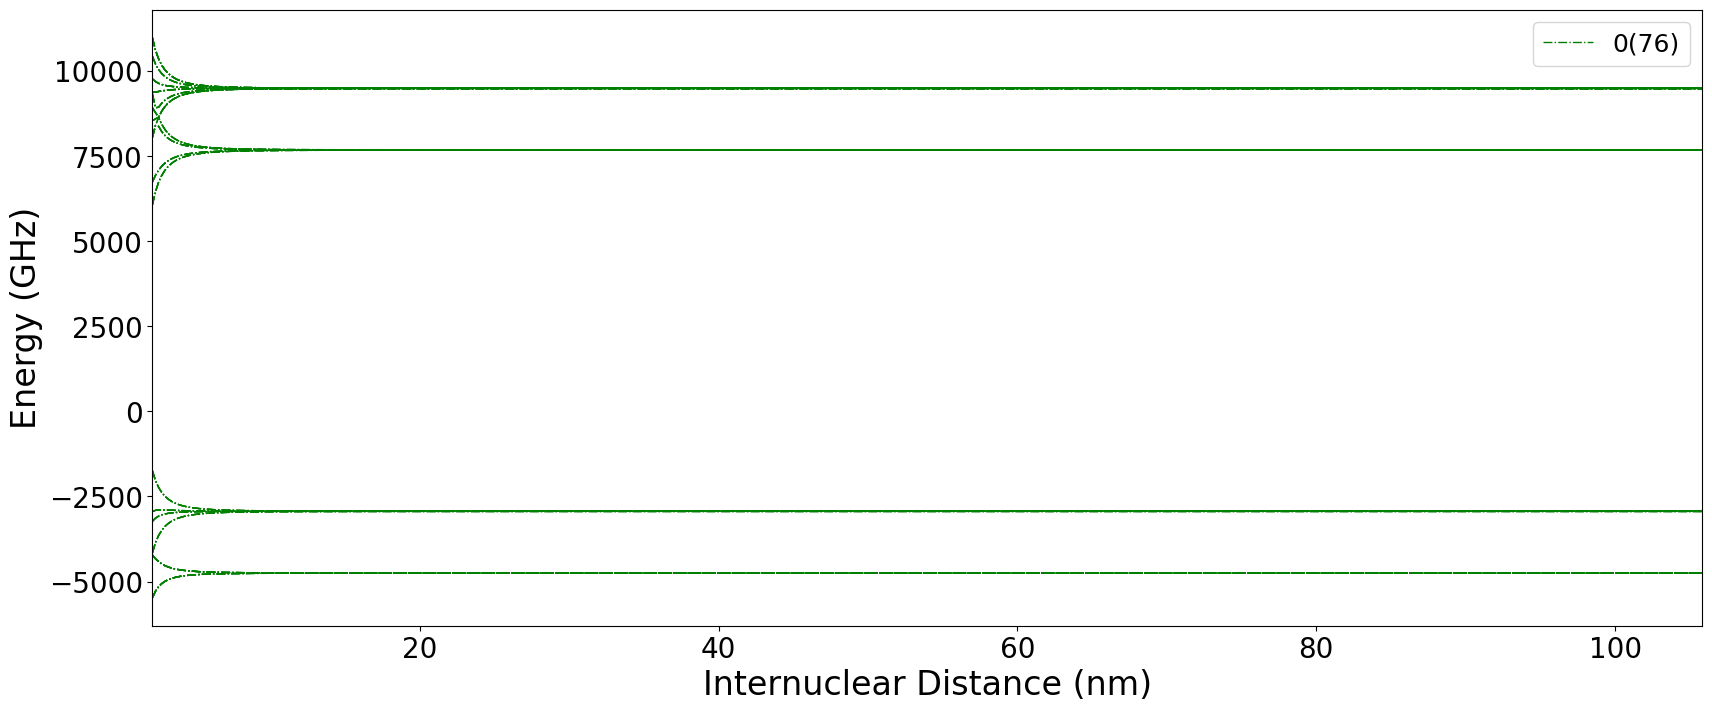

In [67]:
fig, ax = plt.subplots(figsize=(20,8))
gs = fig.add_gridspec(6,2)
yoffset = DeltaVal/mc.h
inc=1
#phiColors, _ = misc.getColors(len(phiBases)+1)#, cmStr='gnuplot')
phiColors=['g','c','b','purple', 'orange','r','k']
plotByGuCharacter=False
for label, base in symmetrizedBases.items():
    #if label not in ['0a', '0b']:
    #    continue
    color = phiColors[int(label[0])]
    linestyle = '-' if label[-1] == 'a' else '-.'
    for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
        ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoffset/1e9 , 
                color=color, linestyle=linestyle, linewidth=1, 
                label=label +"("+ str(len(base))+')' if datanum==0 else None)
        
leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
for text in leg.get_texts():
    text.set_color("k")
#ax.axhline(0,color='k',alpha=0.5)
#ax.text(80,-0.8, "D1 Line $(5P_{1/2})$\nDissociation Limit", fontsize=20, color='k')
#ax.set_ylim((-600,-540))
#ax.set_ylim(500,600)
ax.set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
#ax.grid(alpha=0.5)
ax.set_xlabel('Internuclear Distance (nm)',fontsize=24)
#ax.set_xticks(fontsize=20)
ax.set_ylabel('Energy (GHz)',fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
#plt.savefig("Hyperfine_Splitting_Big_Picture.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

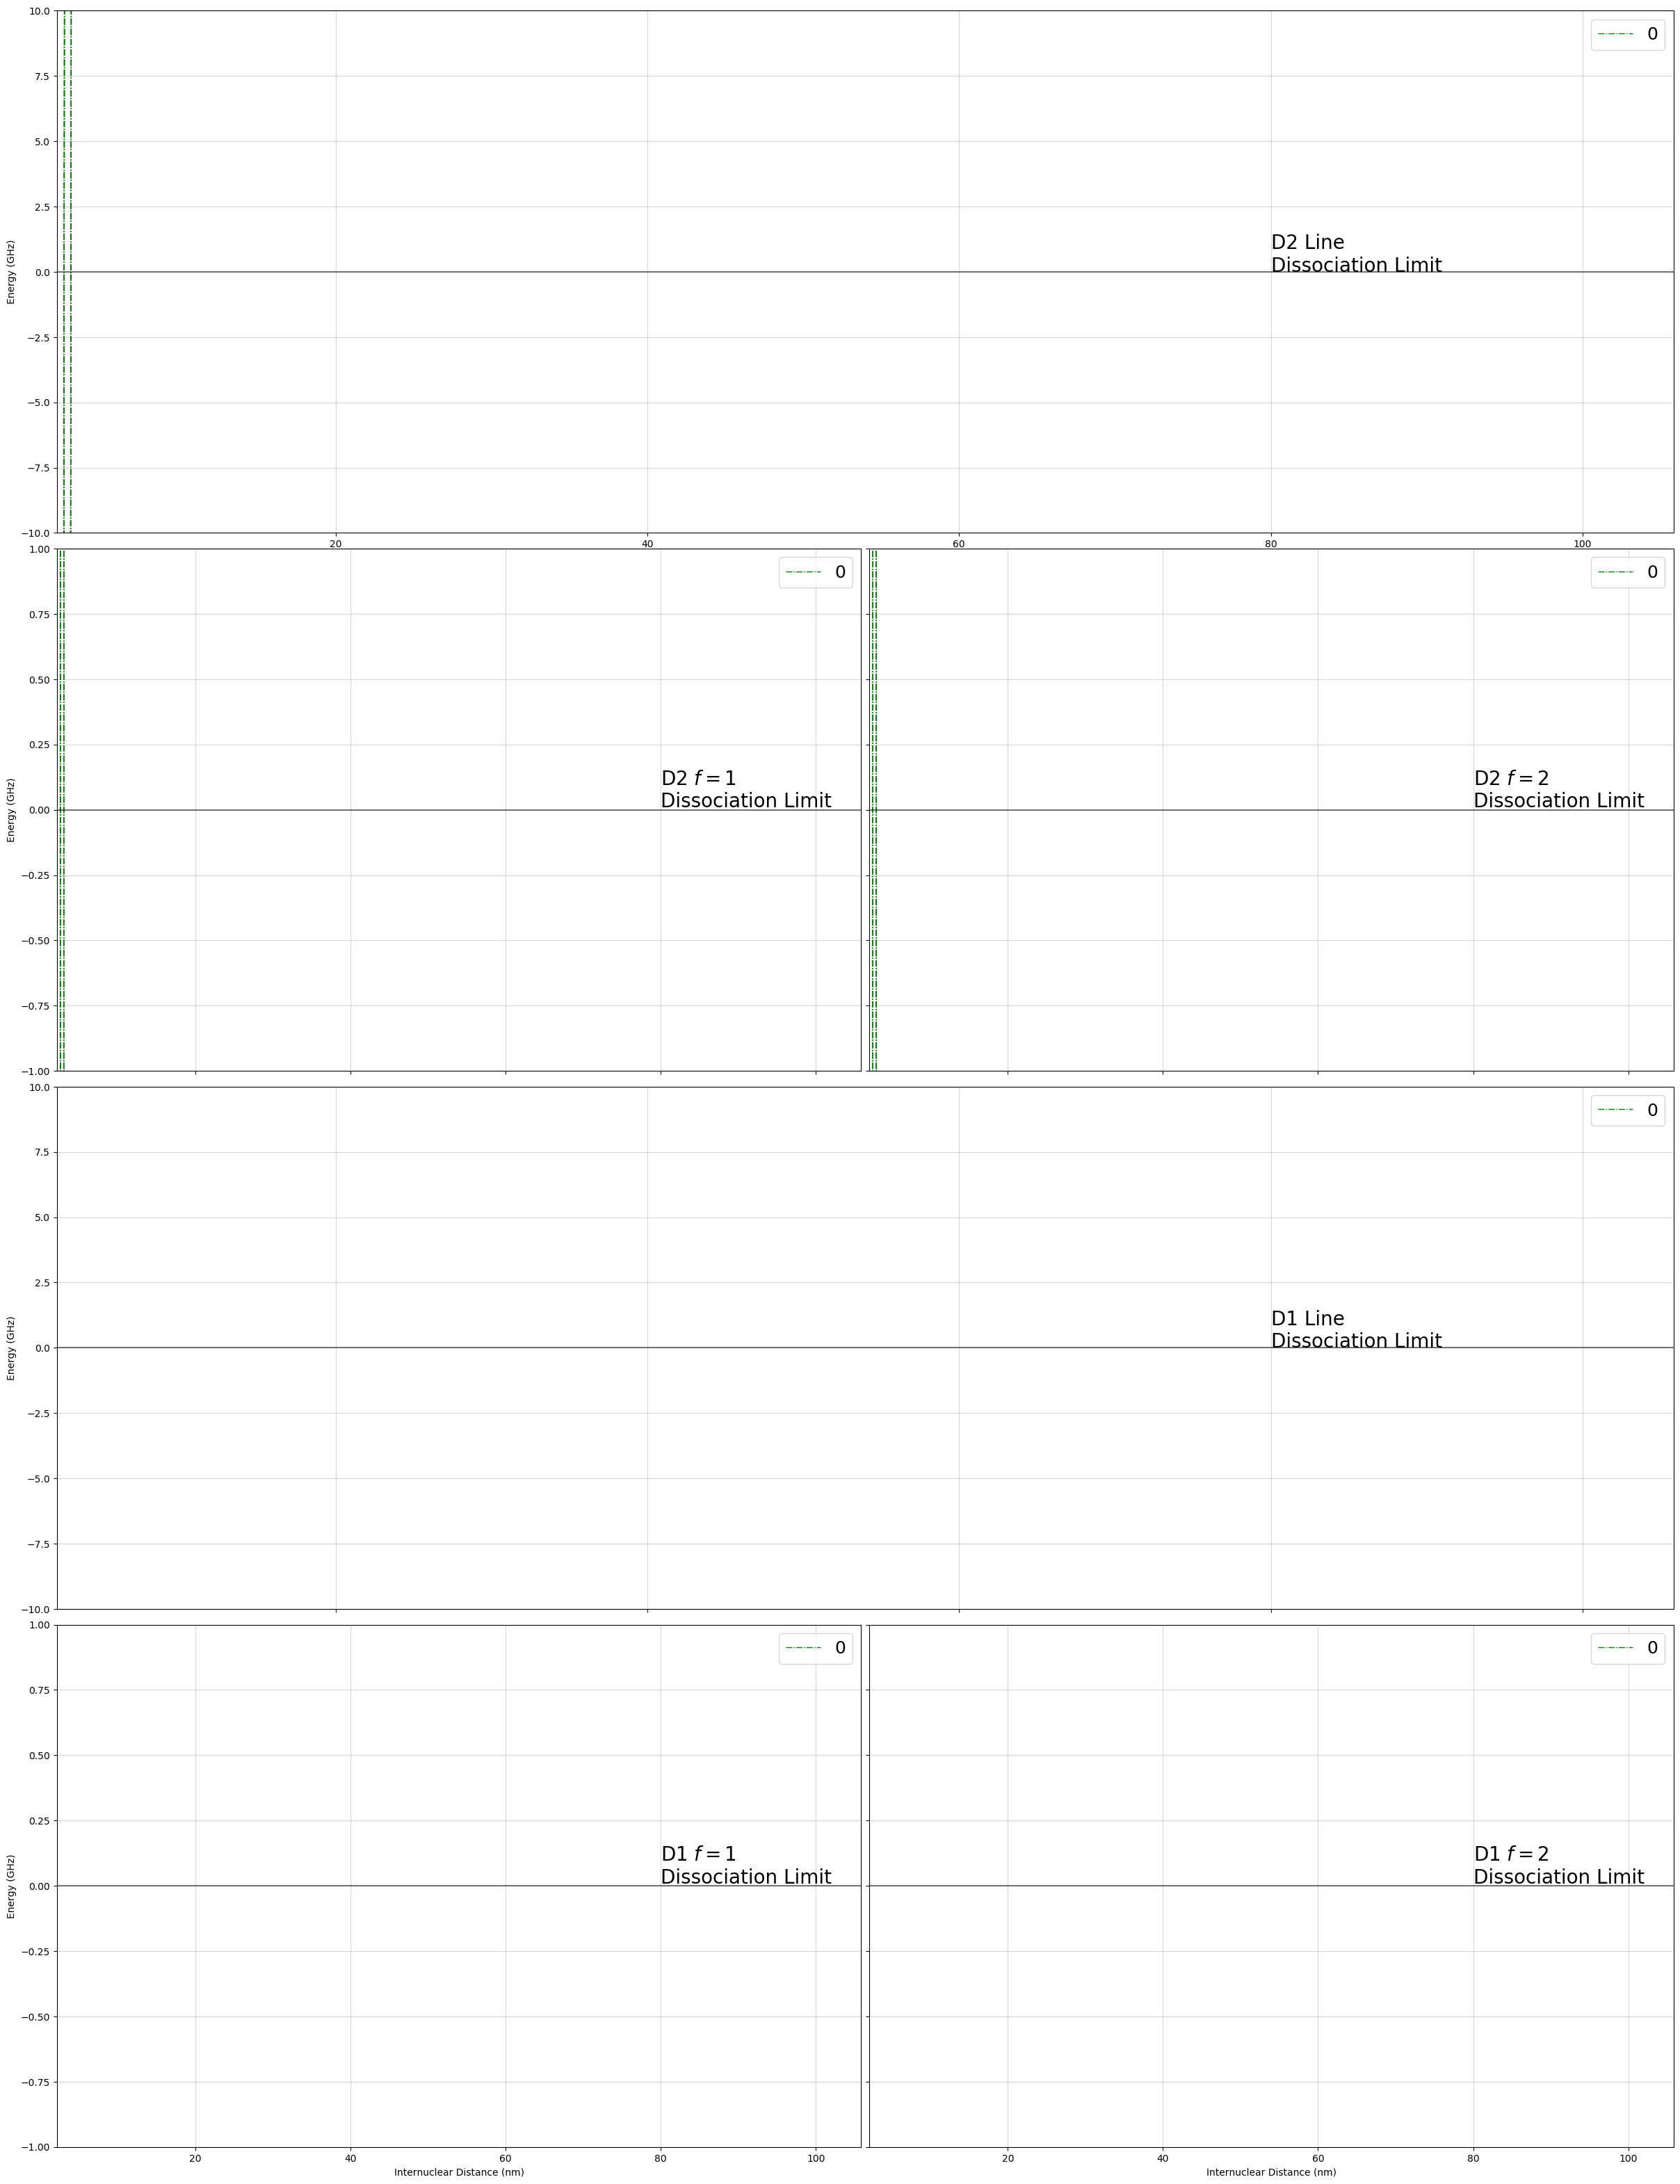

In [65]:
fig = plt.figure(figsize=(30,60))
gs = fig.add_gridspec(6,2)
axs = []
axs.append(fig.add_subplot(gs[0, :]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))
axs.append(fig.add_subplot(gs[2, :]))
axs.append(fig.add_subplot(gs[3, 0]))
axs.append(fig.add_subplot(gs[3, 1]))

fig.subplots_adjust(hspace=0.03, wspace=0.01)

titles = ["D2 Line",  
          r"D2 $f=1$",     r"D2 $f=2$",
          "D1 Line",  
          r"D1 $f=1$",     r"D1 $f=2$"]

allYlims = [(-10,10), 
            (-1,1),    (-1,1),
            (-10,10), 
            (-1,1),    (-1,1)]
yoffsets = np.array(
            [0,
            -mc.Rb87_Ground_ToF1,-mc.Rb87_Ground_ToF2,
            DeltaVal/mc.h,
            DeltaVal/mc.h-mc.Rb87_Ground_ToF1,DeltaVal/mc.h-mc.Rb87_Ground_ToF2])/1e9
inc=1
#phiColors, _ = misc.getColors(len(phiBases)+1)#, cmStr='gnuplot')
phiColors=['g','c','b','purple', 'orange','r']
plotByGuCharacter=False
for num, (ax, title, ylims, yoff) in enumerate(zip(axs[:], titles, allYlims, yoffsets)):
    for label, base in symmetrizedBases.items():
        color = phiColors[int(label[0])]
        linestyle = '-' if label[-1] == 'a' else '-.'
        for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff , color=color, linestyle=linestyle, linewidth=1, 
                    label=label if datanum==0 else None)
    leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
    for text in leg.get_texts():
        text.set_color("k")
    ax.axhline(0,color='k',alpha=0.5)
    ax.text(80,0.01, title + "\nDissociation Limit", fontsize=20, color='k')
    ax.set_ylim(*ylims)
    ax.set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
    ax.grid(alpha=0.5)
    if num != len(axs)-1 and num != len(axs)-2 and num != 0:
        ax.set_xticklabels([]);
    elif num != 0:
        ax.set_xlabel('Internuclear Distance (nm)')
    if num not in [0,1, 3,4]:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Energy (GHz)')
plt.savefig("Symmetrized_Hyperfine_Splitting_Big_Picture.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

#### Zoomed out D1 & D2

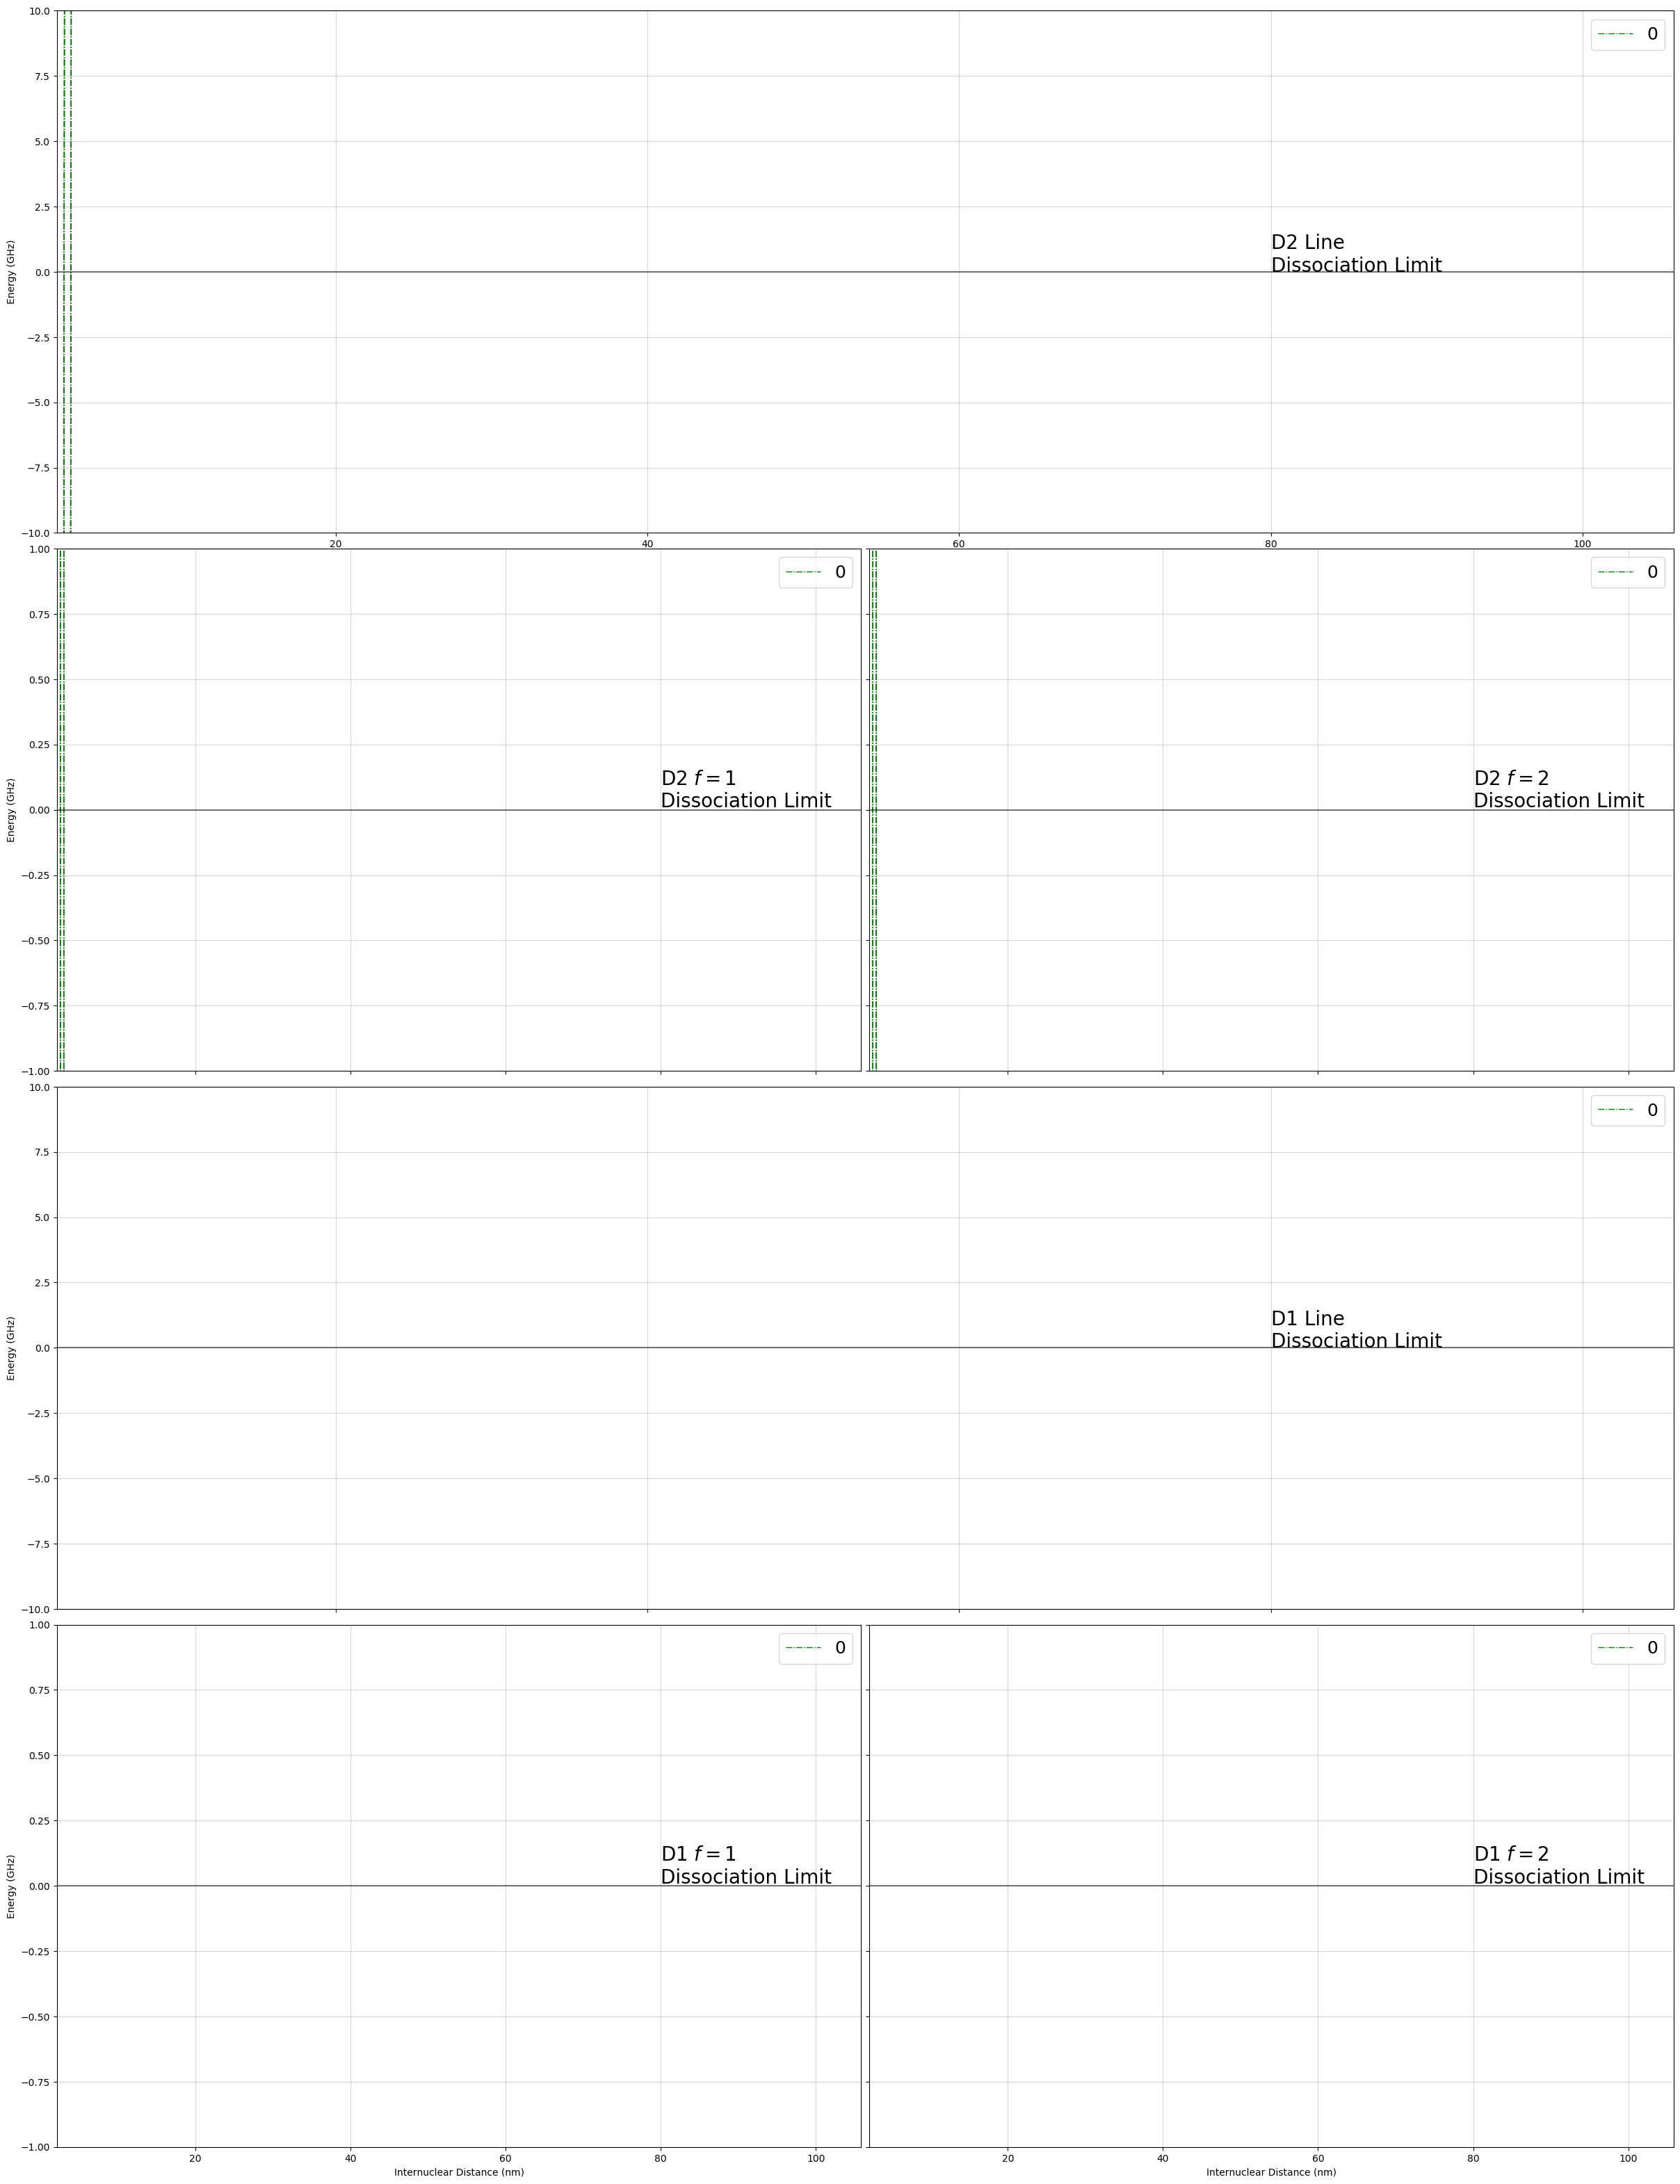

In [66]:
fig = plt.figure(figsize=(30,60))
gs = fig.add_gridspec(6,2)
axs = []
axs.append(fig.add_subplot(gs[0, :]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))
axs.append(fig.add_subplot(gs[2, :]))
axs.append(fig.add_subplot(gs[3, 0]))
axs.append(fig.add_subplot(gs[3, 1]))

fig.subplots_adjust(hspace=0.03, wspace=0.01)

titles = ["D2 Line",  
          r"D2 $f=1$",     r"D2 $f=2$",
          "D1 Line",  
          r"D1 $f=1$",     r"D1 $f=2$"]

allYlims = [(-10,10), 
            (-1,1),    (-1,1),
            (-10,10), 
            (-1,1),    (-1,1)]
yoffsets = np.array(
            [0,
            -mc.Rb87_Ground_ToF1,-mc.Rb87_Ground_ToF2,
            DeltaVal/mc.h,
            DeltaVal/mc.h-mc.Rb87_Ground_ToF1,DeltaVal/mc.h-mc.Rb87_Ground_ToF2])/1e9
inc=1
#phiColors, _ = misc.getColors(len(phiBases)+1)#, cmStr='gnuplot')
phiColors=['g','c','b','purple', 'orange','r']
plotByGuCharacter=False
for num, (ax, title, ylims, yoff) in enumerate(zip(axs[:], titles, allYlims, yoffsets)):
    for label, base in symmetrizedBases.items():
        color = phiColors[int(label[0])]
        linestyle = '-' if label[-1] == 'a' else '-.'
        for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff , color=color, linestyle=linestyle, linewidth=1, 
                    label=label if datanum==0 else None)
    leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
    for text in leg.get_texts():
        text.set_color("k")
    ax.axhline(0,color='k',alpha=0.5)
    ax.text(80,0.01, title + "\nDissociation Limit", fontsize=20, color='k')
    ax.set_ylim(*ylims)
    ax.set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
    ax.grid(alpha=0.5)
    if num != len(axs)-1 and num != len(axs)-2 and num != 0:
        ax.set_xticklabels([]);
    elif num != 0:
        ax.set_xlabel('Internuclear Distance (nm)')
    if num not in [0,1, 3,4]:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Energy (GHz)')
plt.savefig("Symmetrized_Hyperfine_Splitting_Big_Picture.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

#### D1 Zoomed In

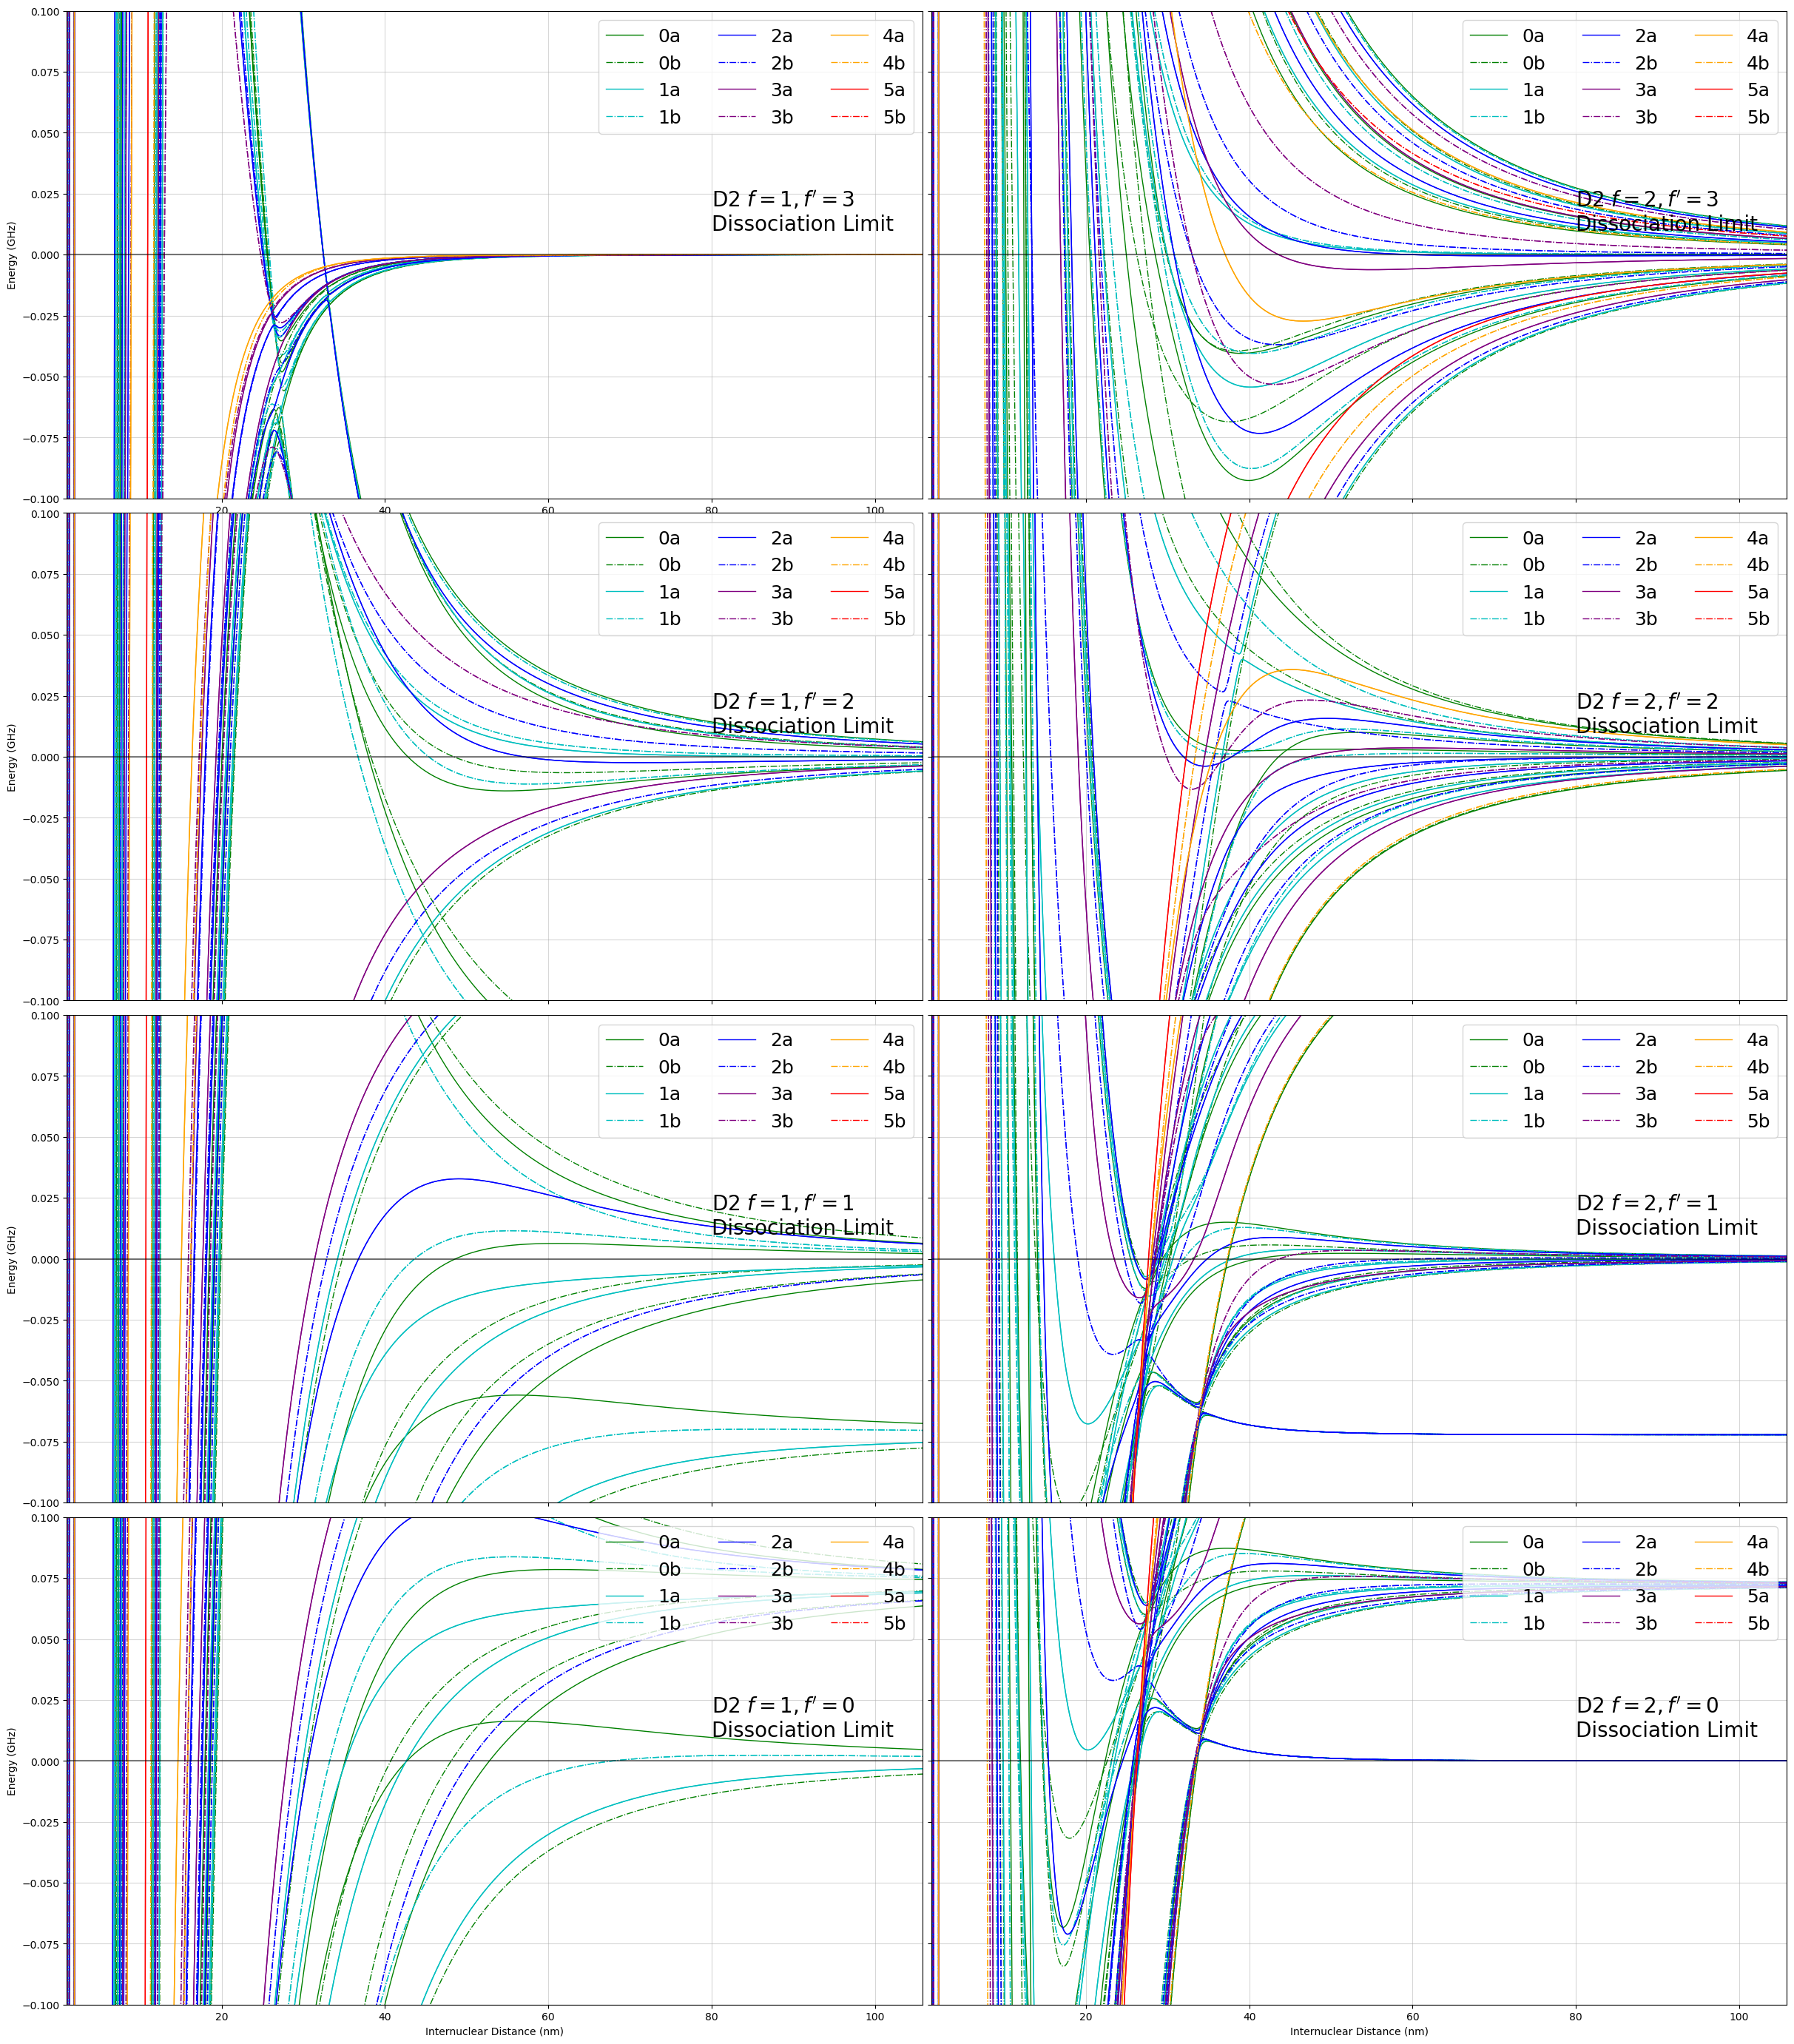

In [365]:
fig = plt.figure(figsize=(30,35))
gs = fig.add_gridspec(4,2)
axs = []
for i1, i2 in zip([0,0,1,1,2,2,3,3], [0,1,0,1,0,1,0,1]):
    axs.append(fig.add_subplot(gs[i1,i2]))
fig.subplots_adjust(hspace=0.03, wspace=0.01)

titles = [
          r"D2 $f=1,f'=3$",r"D2 $f=2,f'=3$",
          r"D2 $f=1,f'=2$",r"D2 $f=2,f'=2$",
          r"D2 $f=1,f'=1$",r"D2 $f=2,f'=1$",
          r"D2 $f=1,f'=0$",r"D2 $f=2,f'=0$"]

allYlims = [
            (-0.1,0.1), (-0.1,0.1),
            (-0.1,0.1), (-0.1,0.1),
            (-0.1,0.1), (-0.1,0.1),
            (-0.1,0.1), (-0.1,0.1),]
gColor = 'r'
uColor = 'orange'
yoffsets = np.array(
            [-mc.Rb87_Ground_ToF1-mc.Rb87_5P32_ToF3,-mc.Rb87_Ground_ToF2-mc.Rb87_5P32_ToF3,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P32_ToF2,-mc.Rb87_Ground_ToF2-mc.Rb87_5P32_ToF2,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P32_ToF1,-mc.Rb87_Ground_ToF2-mc.Rb87_5P32_ToF1,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P32_ToF0,-mc.Rb87_Ground_ToF2-mc.Rb87_5P32_ToF0])/1e9

inc=1
#phiColors, _ = misc.getColors(len(phiBases)+1)#, cmStr='gnuplot')
phiColors=['g','c','b','purple', 'orange','r']
plotByGuCharacter=False
for num, (ax, title, ylims, yoff) in enumerate(zip(axs[:], titles, allYlims, yoffsets)):
    for label, base in symmetrizedBases.items():
        color = phiColors[int(label[0])]
        linestyle = '-' if label[-1] == 'a' else '-.'
        for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff , color=color, linestyle=linestyle, linewidth=1, 
                    label=label if datanum==0 else None)
        leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
    for text in leg.get_texts():
        text.set_color("k")
    ax.axhline(0,color='k',alpha=0.5)
    ax.text(80,0.01, title + "\nDissociation Limit", fontsize=20, color='k')
    ax.set_ylim(*ylims)
    ax.set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
    ax.grid(alpha=0.5)
    if num != len(axs)-1 and num != len(axs)-2 and num != 0:
        ax.set_xticklabels([]);
    elif num != 0:
        ax.set_xlabel('Internuclear Distance (nm)')
    if num % 2 == 1:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Energy (GHz)')
plt.savefig("Symmetrized_Hyperfine_Splitting_D2_Zoom.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

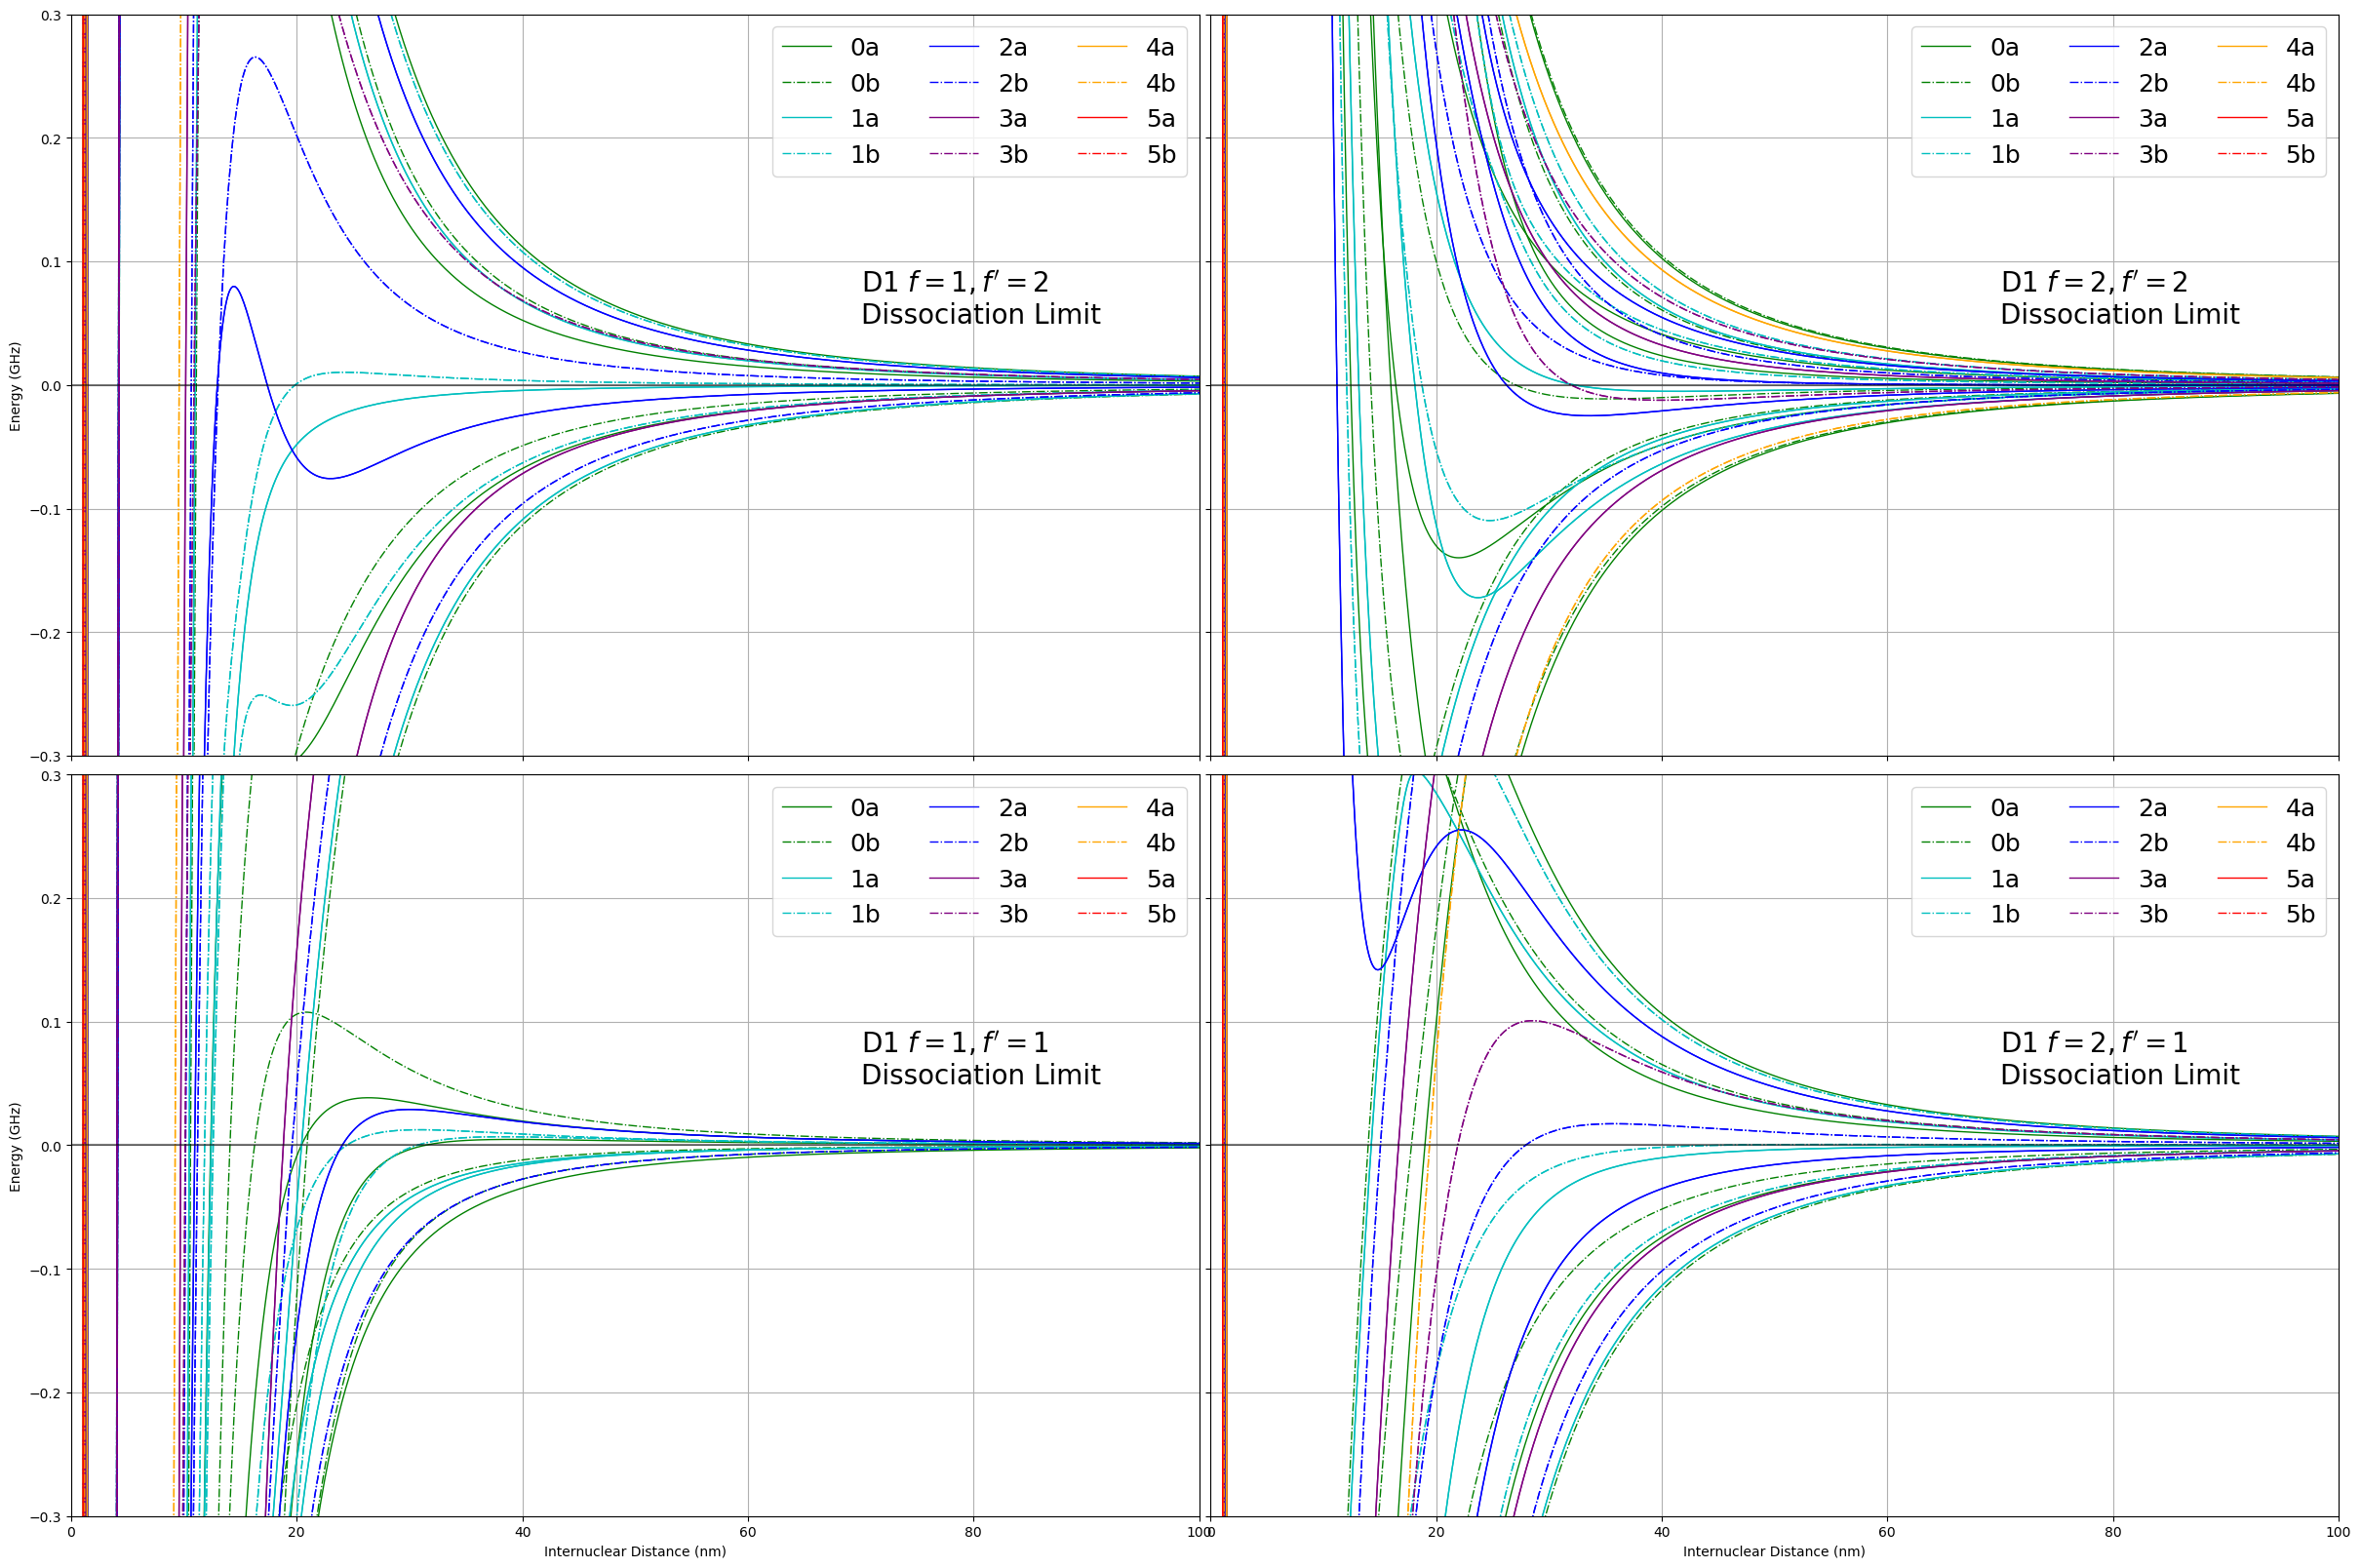

In [366]:
fig = plt.figure(figsize=(30,20))
gs = fig.add_gridspec(2,2)
axs = []
for i1, i2 in zip([0,0,1,1], [0,1,0,1]):
    axs.append(fig.add_subplot(gs[i1,i2]))
fig.subplots_adjust(hspace=0.025, wspace=0.01)

titles = [r"D1 $f=1,f'=2$",r"D1 $f=2,f'=2$",
          r"D1 $f=1,f'=1$",r"D1 $f=2,f'=1$"]

allYlims = np.array(
           [(-0.3,0.3),  (-0.3,0.3),
            (-0.3,0.3),  (-0.3,0.3)])
yoffsets = np.array(         
            [-mc.Rb87_Ground_ToF1-mc.Rb87_5P12_ToF2,-mc.Rb87_Ground_ToF2-mc.Rb87_5P12_ToF2,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P12_ToF1,-mc.Rb87_Ground_ToF2-mc.Rb87_5P12_ToF1])/1e9
yoffsets += DeltaVal/mc.h/1e9
inc=1
for num, (ax, title, ylims, yoff) in enumerate(zip(axs, titles, allYlims, yoffsets)):
    for label, base in symmetrizedBases.items():
        color = phiColors[int(label[0])]
        linestyle = '-' if label[-1] == 'a' else '-.'
        for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff , color=color, linestyle=linestyle, linewidth=1, 
                    label=label if datanum==0 else None)
    leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
    for text in leg.get_texts():
        text.set_color("k")

    ax.axhline(0,color='k',alpha=0.5)
    ax.text(70,0.05, title + "\nDissociation Limit", fontsize=20, color='k')
    ax.set_ylim(*ylims)
    ax.set_xlim(0,100)
    ax.grid(alpha=1)
    if num != len(axs)-1 and num != len(axs)-2:
        ax.set_xticklabels([]);
    elif num != 0:
        ax.set_xlabel('Internuclear Distance (nm)')
    if num % 2 == 1:
        ax.set_yticklabels([]);
    else:
        ax.set_ylabel('Energy (GHz)')
plt.savefig("Symmetrized_Hyperfine_Splitting_D1_Zoom.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

# ordinary hyperfine orig

accidentally killed this earlier.

In [196]:
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = createLargerBasisRefs([0,1], [1/2], [3/2])
fsOperator = fsOp(jiBasis2Atom)
hfsOperator = hfsOp(fBasis2Atom, A_12, A_gs, mc.Rb87_5P32_ToF3, mc.Rb87_5P32_ToF2,mc.Rb87_5P32_ToF1,mc.Rb87_5P32_ToF0)
lsiToJiop = lsiToJi(lsiBasis,jiBasis)
jiToFOp = jiTof(jiBasis, fBasis)
boBasisDict_full = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['g', 'u'])

In [197]:
caseABlindFs = createBornOppenheimerBasisHFS([1],[0,1], [0], sigmavals=['g', 'u'])
caseASymFs = createBornOppenheimerBasisHFS_Sym2([1],[0,1],[0], sigmavals=['g','u'])
caseABlindHfs = createBornOppenheimerBasisHFS([1],[0,1], [3/2], sigmavals=['g', 'u'])
caseASymHfs = createBornOppenheimerBasisHFS_SuperSym([1],[0,1],[3/2], sigmavals=['g','u'])

In [203]:
# Full basis
phiIncluded=np.arange(1)
totalSpatialParityIncluded = ['a','b']
mostlySymmetrizedBases = {}

for phi in phiIncluded:
    for parity in totalSpatialParityIncluded:
        parityVal = 1 if parity == 'a' else -1
        for state in boBasisDict_full:
            sigmaval = g if state['sigma'] == 'g' else u
            if math.isclose(abs(state['phi']),phi):
                if (-1)**(state['i']+sigmaval) == parityVal:
                    #label = str(phi)+parity
                    label = str(phi)
                    if label not in mostlySymmetrizedBases:
                        mostlySymmetrizedBases[label] = []
                    mostlySymmetrizedBases[label].append(state)

In [255]:
def stateLabel(state):
    label = "|"
    for key, val in state.items():
        if key != 'L' and key != 'phi' and key != 'i1' and key != 'i2':
            label += key + ":" + str(val) + ", "
    return label + ">"

In [256]:
print(len(mostlySymmetrizedBases['0a']))
for snum, state in enumerate(mostlySymmetrizedBases['0a']):
    print(snum, stateLabel(state))

KeyError: '0a'

In [257]:
# Full basis
phiIncluded=np.arange(1)
totalSpatialParityIncluded = ['a','b']
symmetrizedBases = {}

for phi in phiIncluded:
    for parity in totalSpatialParityIncluded:
        parityVal = 1 if parity == 'a' else -1
        for state in caseASymHfs:
            sigmaval = g if state['sigma'] == 'g' else u
            if math.isclose(abs(state['phi']),phi):
                if (-1)**(state['i']+sigmaval) == parityVal:
                    #label = str(phi)+parity
                    label = str(phi)
                    if label not in symmetrizedBases:
                        symmetrizedBases[label] = []
                    symmetrizedBases[label].append(state)

In [260]:
H_fs_phi = {}
H_hfs_phi = {}
for label, base in symmetrizedBases.items():
    IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates = []
    hfsStates = []
    print('Converting BO states to FS and HFS bases')
    for num, state in enumerate(base[:]):
        if abs(state['|Omega|']) != 2:
            continue
        misc.reportProgress(num, len(base))
        indexes, signs = caseASymHfsToBlind(state, caseABlindHfs, indexes=True)
        symHfsState, symFsState = 0, 0
        resultStr = ''
        for index, sign in zip(indexes,signs):
            signStr = "+" if sign==1 else "-"
            #resultStr += signStr+str(index)
            state = caseABlindHfs[index]
            resultStr += signStr + str(stateLabel(state))
            sigma = g if state["sigma"] == "g" else u
            nuclearNums = [state['i'], state['iota'],state['i1'],state['i2'],]
            oalNums = (state["L"], state["Lambda"], 1, 0)
            spinNums = (state["S"], state["Sigma"], 1/2, 1/2)
            hfsState1, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )
            fsState1, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsiToJiop )
            symHfsState += sign * hfsState1
            symFsState += sign * fsState1
        fsStates.append(symFsState);
        hfsStates.append(symHfsState)
        print(resultStr[:])
    print('Complete\nCalcualting FS Energies')
    H_fs_phi[label] = createCouplingMatrix( fsStates, fsOperator, offset=-1/2)
    print('Complete\nCalcualting HFS Energies')
    H_hfs_phi[label] = createCouplingMatrix( hfsStates, hfsOperator, offset=0)
    print('Complete')
    time.sleep(1)
hfsStatesSym = hfsStates
print(np.linalg.eigvals(H_hfs_phi['0']), '\n\n', H_hfs_phi['0'])

Working on states of symmetry 0. 76 states
Converting BO states to FS and HFS bases
+|Lambda:-1, sigma:g, S:1, Sigma:-1, i:2.0, iota:2.0, Omega:-2, >-|Lambda:1, sigma:g, S:1, Sigma:1, i:2.0, iota:-2.0, Omega:2, >
+|Lambda:-1, sigma:g, S:1, Sigma:-1, i:2.0, iota:2.0, Omega:-2, >+|Lambda:1, sigma:g, S:1, Sigma:1, i:2.0, iota:-2.0, Omega:2, >
+|Lambda:-1, sigma:u, S:1, Sigma:-1, i:3.0, iota:2.0, Omega:-2, >-|Lambda:1, sigma:u, S:1, Sigma:1, i:3.0, iota:-2.0, Omega:2, >
+|Lambda:-1, sigma:u, S:1, Sigma:-1, i:3.0, iota:2.0, Omega:-2, >+|Lambda:1, sigma:u, S:1, Sigma:1, i:3.0, iota:-2.0, Omega:2, >
+|Lambda:-1, sigma:g, S:1, Sigma:-1, i:3.0, iota:2.0, Omega:-2, >-|Lambda:1, sigma:g, S:1, Sigma:1, i:3.0, iota:-2.0, Omega:2, >
+|Lambda:-1, sigma:g, S:1, Sigma:-1, i:3.0, iota:2.0, Omega:-2, >+|Lambda:1, sigma:g, S:1, Sigma:1, i:3.0, iota:-2.0, Omega:2, >
+|Lambda:-1, sigma:u, S:1, Sigma:-1, i:2.0, iota:2.0, Omega:-2, >-|Lambda:1, sigma:u, S:1, Sigma:1, i:2.0, iota:-2.0, Omega:2, >
+|Lambda:-1, 

In [ ]:
manState = (hfsStatesUnsym[0] - hfsStatesUnsym[1])#/np.sqrt(2)
for num in range(len(hfsStatesSym[0])):
    if hfsStatesSym[0][num] != 0 or manState[num] != 0:
        print(hfsStatesSym[0][num], manState[num])
hfsStatesSym[0] == (hfsStatesUnsym[0] - hfsStatesUnsym[1])/np.sqrt(2)

In [261]:
H_fs_phi = {}
H_hfs_phi = {}
for label, base in mostlySymmetrizedBases.items():
    IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates = []
    hfsStates = []
    print('Converting BO states to FS and HFS bases')
    for num, state in enumerate(base[:]):
        if abs(state['Omega']) != 2:
            continue
        print(stateLabel(state))
        misc.reportProgress(num, len(base))
        nuclearNums = [state['i'], state['iota'], state['i1'], state['i2']]
        oalNums = (state["L"], state["Lambda"], 1, 0)
        spinNums = (state["S"], state["Sigma"], 1/2, 1/2)
        sigma = g if state['sigma'] == 'g' else u
        fsAddState, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsiToJiop )
        hfsAddState, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )
        fsStates.append(fsAddState);
        hfsStates.append(hfsAddState)
    print('Complete\nCalcualting FS Energies')
    H_fs_phi[label] = createCouplingMatrix( fsStates, fsOperator, offset=-1/2)
    print('Complete\nCalcualting HFS Energies')
    H_hfs_phi[label] = createCouplingMatrix( hfsStates, hfsOperator, offset=0)
    print('Complete')
    time.sleep(1)
hfsStatesUnsym = hfsStates
print(np.linalg.eigvals(H_hfs_phi['0']), '\n\n', H_hfs_phi['0'])

Working on states of symmetry 0. 76 states
Converting BO states to FS and HFS bases
|Lambda:-1, sigma:g, S:1, Sigma:-1, i:2.0, iota:2.0, Omega:-2, >
|Lambda:1, sigma:g, S:1, Sigma:1, i:2.0, iota:-2.0, Omega:2, >
|Lambda:-1, sigma:u, S:1, Sigma:-1, i:3.0, iota:2.0, Omega:-2, >
|Lambda:1, sigma:u, S:1, Sigma:1, i:3.0, iota:-2.0, Omega:2, >
|Lambda:-1, sigma:g, S:1, Sigma:-1, i:3.0, iota:2.0, Omega:-2, >
|Lambda:1, sigma:g, S:1, Sigma:1, i:3.0, iota:-2.0, Omega:2, >
|Lambda:-1, sigma:u, S:1, Sigma:-1, i:2.0, iota:2.0, Omega:-2, >
|Lambda:1, sigma:u, S:1, Sigma:1, i:2.0, iota:-2.0, Omega:2, >
Complete                  
Calcualting FS Energies
Complete                  
Calcualting HFS Energies
Complete                  
[-1.042e+09 -2.630e+09 -2.630e+09 -1.042e+09 -1.042e+09 -2.630e+09 -1.042e+09 -2.630e+09] 

 [[-1.836e+09  5.960e-08  7.939e+08  0.000e+00 -1.192e-07  0.000e+00  0.000e+00  0.000e+00]
 [ 5.960e-08 -1.836e+09  0.000e+00 -7.939e+08  0.000e+00  1.192e-07  0.000e+00 -1.192e-07]

In [238]:
H_fs_phi = {}
H_hfs_phi = {}
for label, base in mostlySymmetrizedBases.items():
    IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates = []
    hfsStates = []
    print('Converting BO states to FS and HFS bases')
    for num, state in enumerate(base[:]):
        continue
        #if False:
        if abs(state['Omega']) == 2:
            continue
            indexes, signs = caseASymHfsToBlind(state, caseABlindHfs, indexes=True)
            hfsAddState, fsAddState = 0, 0
            for index, sign in zip(indexes,signs):
                signStr = "+" if sign==1 else "-"
                resultStr += signStr+str(index)
                subst = caseABlindHfs[index]
                sigma = g if subst["sigma"] == "g" else u
                nuclearNums = [subst['i'], subst['iota'],subst['i1'],subst['i2'],]
                oalNums = (subst["L"], subst["Lambda"], 1, 0)
                spinNums = (subst["S"], subst["Sigma"], 1/2, 1/2)
                hfsState1, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )
                fsState1, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsiToJiop )
                hfsAddState += sign * hfsState1
                fsAddState += sign * fsState1
        else:
            misc.reportProgress(num, len(base))
            nuclearNums = [state['i'], state['iota'], state['i1'], state['i2']]
            oalNums = (state["L"], state["Lambda"], 1, 0)
            spinNums = (state["S"], state["Sigma"], 1/2, 1/2)
            sigma = g if state['sigma'] == 'g' else u
            fsAddState, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsiToJiop )
            hfsAddState, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )
        fsStates.append(fsAddState);
        hfsStates.append(hfsAddState)
    basesSym = symmetrizedBases[label]
    for num, state in enumerate(basesSym[:]):
        if abs(state['|Omega|']) == 2:
            indexes, signs = caseASymHfsToBlind(state, caseABlindHfs, indexes=True)
            hfsAddState, fsAddState = 0, 0
            for index, sign in zip(indexes,signs):
                signStr = "+" if sign==1 else "-"
                resultStr += signStr+str(index)
                subst = caseABlindHfs[index]
                sigma = g if subst["sigma"] == "g" else u
                nuclearNums = [subst['i'], subst['iota'],subst['i1'],subst['i2'],]
                oalNums = (subst["L"], subst["Lambda"], 1, 0)
                spinNums = (subst["S"], subst["Sigma"], 1/2, 1/2)
                hfsState1, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )
                fsState1, _,_,_ = BohrOppenheimerToAtomic_allGood( oalNums, spinNums, nuclearNums, sigma, lsiBasis, basisChange=lsiToJiop )
                hfsAddState += sign * hfsState1
                fsAddState += sign * fsState1
            fsStates.append(fsAddState);
            hfsStates.append(hfsAddState)
    print('Complete\nCalcualting FS Energies')
    H_fs_phi[label] = createCouplingMatrix( fsStates, fsOperator, offset=-1/2)
    print('Complete\nCalcualting HFS Energies')
    H_hfs_phi[label] = createCouplingMatrix( hfsStates, hfsOperator, offset=0)
    print('Complete')
    time.sleep(1)

Working on states of symmetry 0. 76 states
Converting BO states to FS and HFS bases
Complete
Calcualting FS Energies
Complete                  
Calcualting HFS Energies
Complete                  


In [232]:
H_fs_phi['0'].shape

In [223]:
Rvals = np.linspace( 2*20*mc.a0, 100*20*mc.a0, 500 )

energies = {}

for label, base in mostlySymmetrizedBases.items():
    if len(base) == 0:
        continue
    IPython.display.clear_output(wait=True)
    print('\nLabel:', label)
    print('Calcualting Eigenvalues at every R')    
    energies[label] = np.zeros((len(Rvals), len(base)))
    for num, rv in enumerate(Rvals):
        misc.reportProgress(num, len(Rvals))
        rmatrix = createBOMatrix2(C_3_val, rv, *base).astype(float) + H_fs_phi[label] * 2 * DeltaVal / 3 + H_hfs_phi[label] * mc.h
        #rmatrix = H_fs_phi[label] * 2 * DeltaVal / 3# + H_hfs_phi[label] * mc.h
        eigVals, eigVectors = np.linalg.eigh(rmatrix)
        energies[label][num] = eigVals


Label: 0
Calcualting Eigenvalues at every R


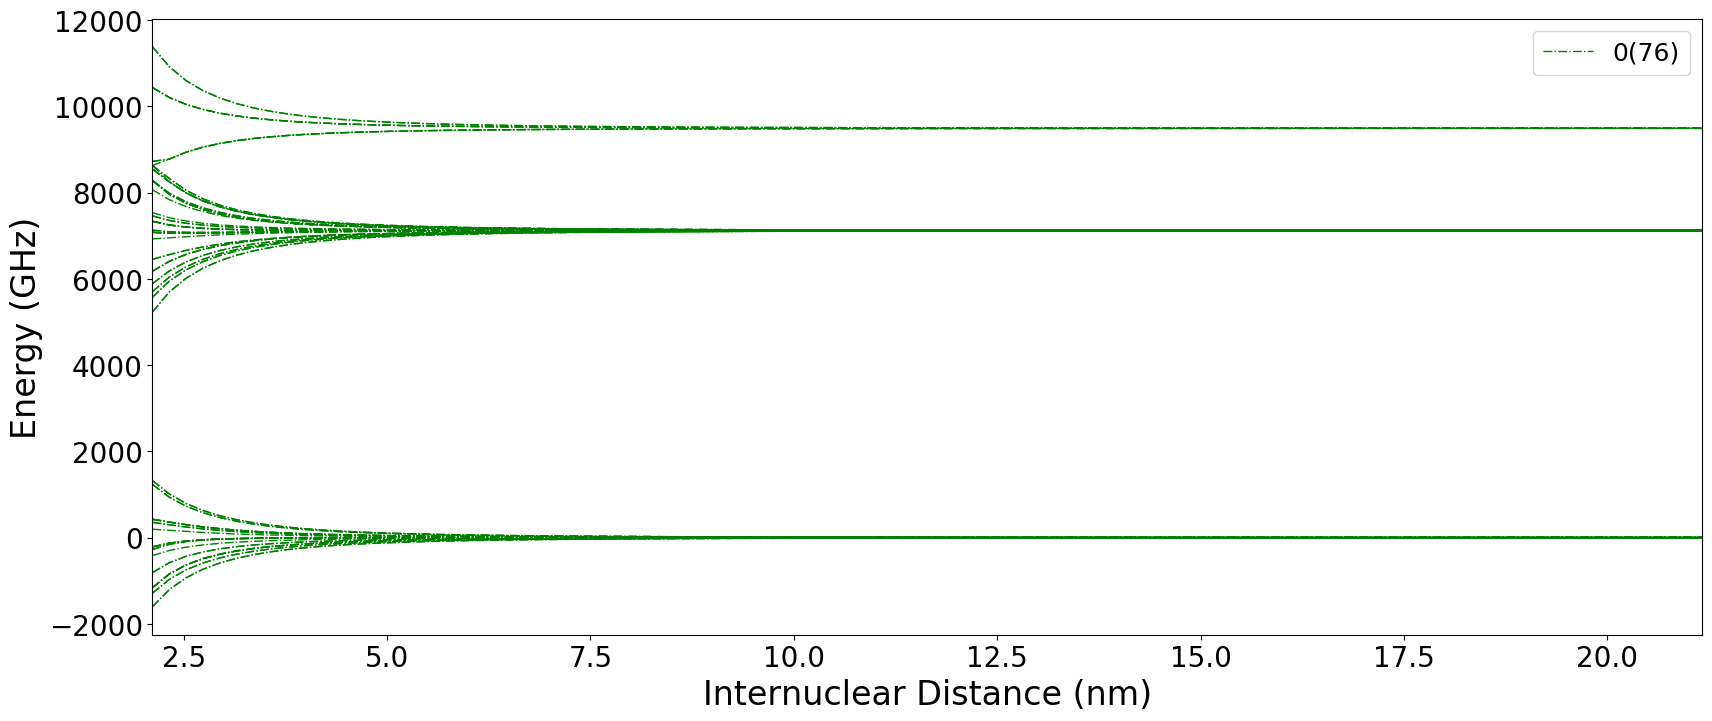

In [224]:
fig, ax = plt.subplots(figsize=(20,8))
gs = fig.add_gridspec(6,2)
yoffset = DeltaVal/mc.h
inc=1
#phiColors, _ = misc.getColors(len(phiBases)+1)#, cmStr='gnuplot')
phiColors=['g','c','b','purple', 'orange','r','k']
plotByGuCharacter=False
for label, base in mostlySymmetrizedBases.items():
    #if label not in ['0a', '0b']:
    #    continue
    color = phiColors[int(label[0])]
    linestyle = '-' if label[-1] == 'a' else '-.'
    for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
        ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoffset/1e9 , 
                color=color, linestyle=linestyle, linewidth=1, 
                label=label +"("+ str(len(base))+')' if datanum==0 else None)
        
leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
for text in leg.get_texts():
    text.set_color("k")
#ax.axhline(0,color='k',alpha=0.5)
#ax.text(80,-0.8, "D1 Line $(5P_{1/2})$\nDissociation Limit", fontsize=20, color='k')
#ax.set_ylim((-600,-540))
#ax.set_ylim(0,600)
ax.set_xlim(min(Rvals)*1e9,max(Rvals)*2e8)
#ax.grid(alpha=0.5)
ax.set_xlabel('Internuclear Distance (nm)',fontsize=24)
#ax.set_xticks(fontsize=20)
ax.set_ylabel('Energy (GHz)',fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=20)
#plt.savefig("Hyperfine_Splitting_Big_Picture.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

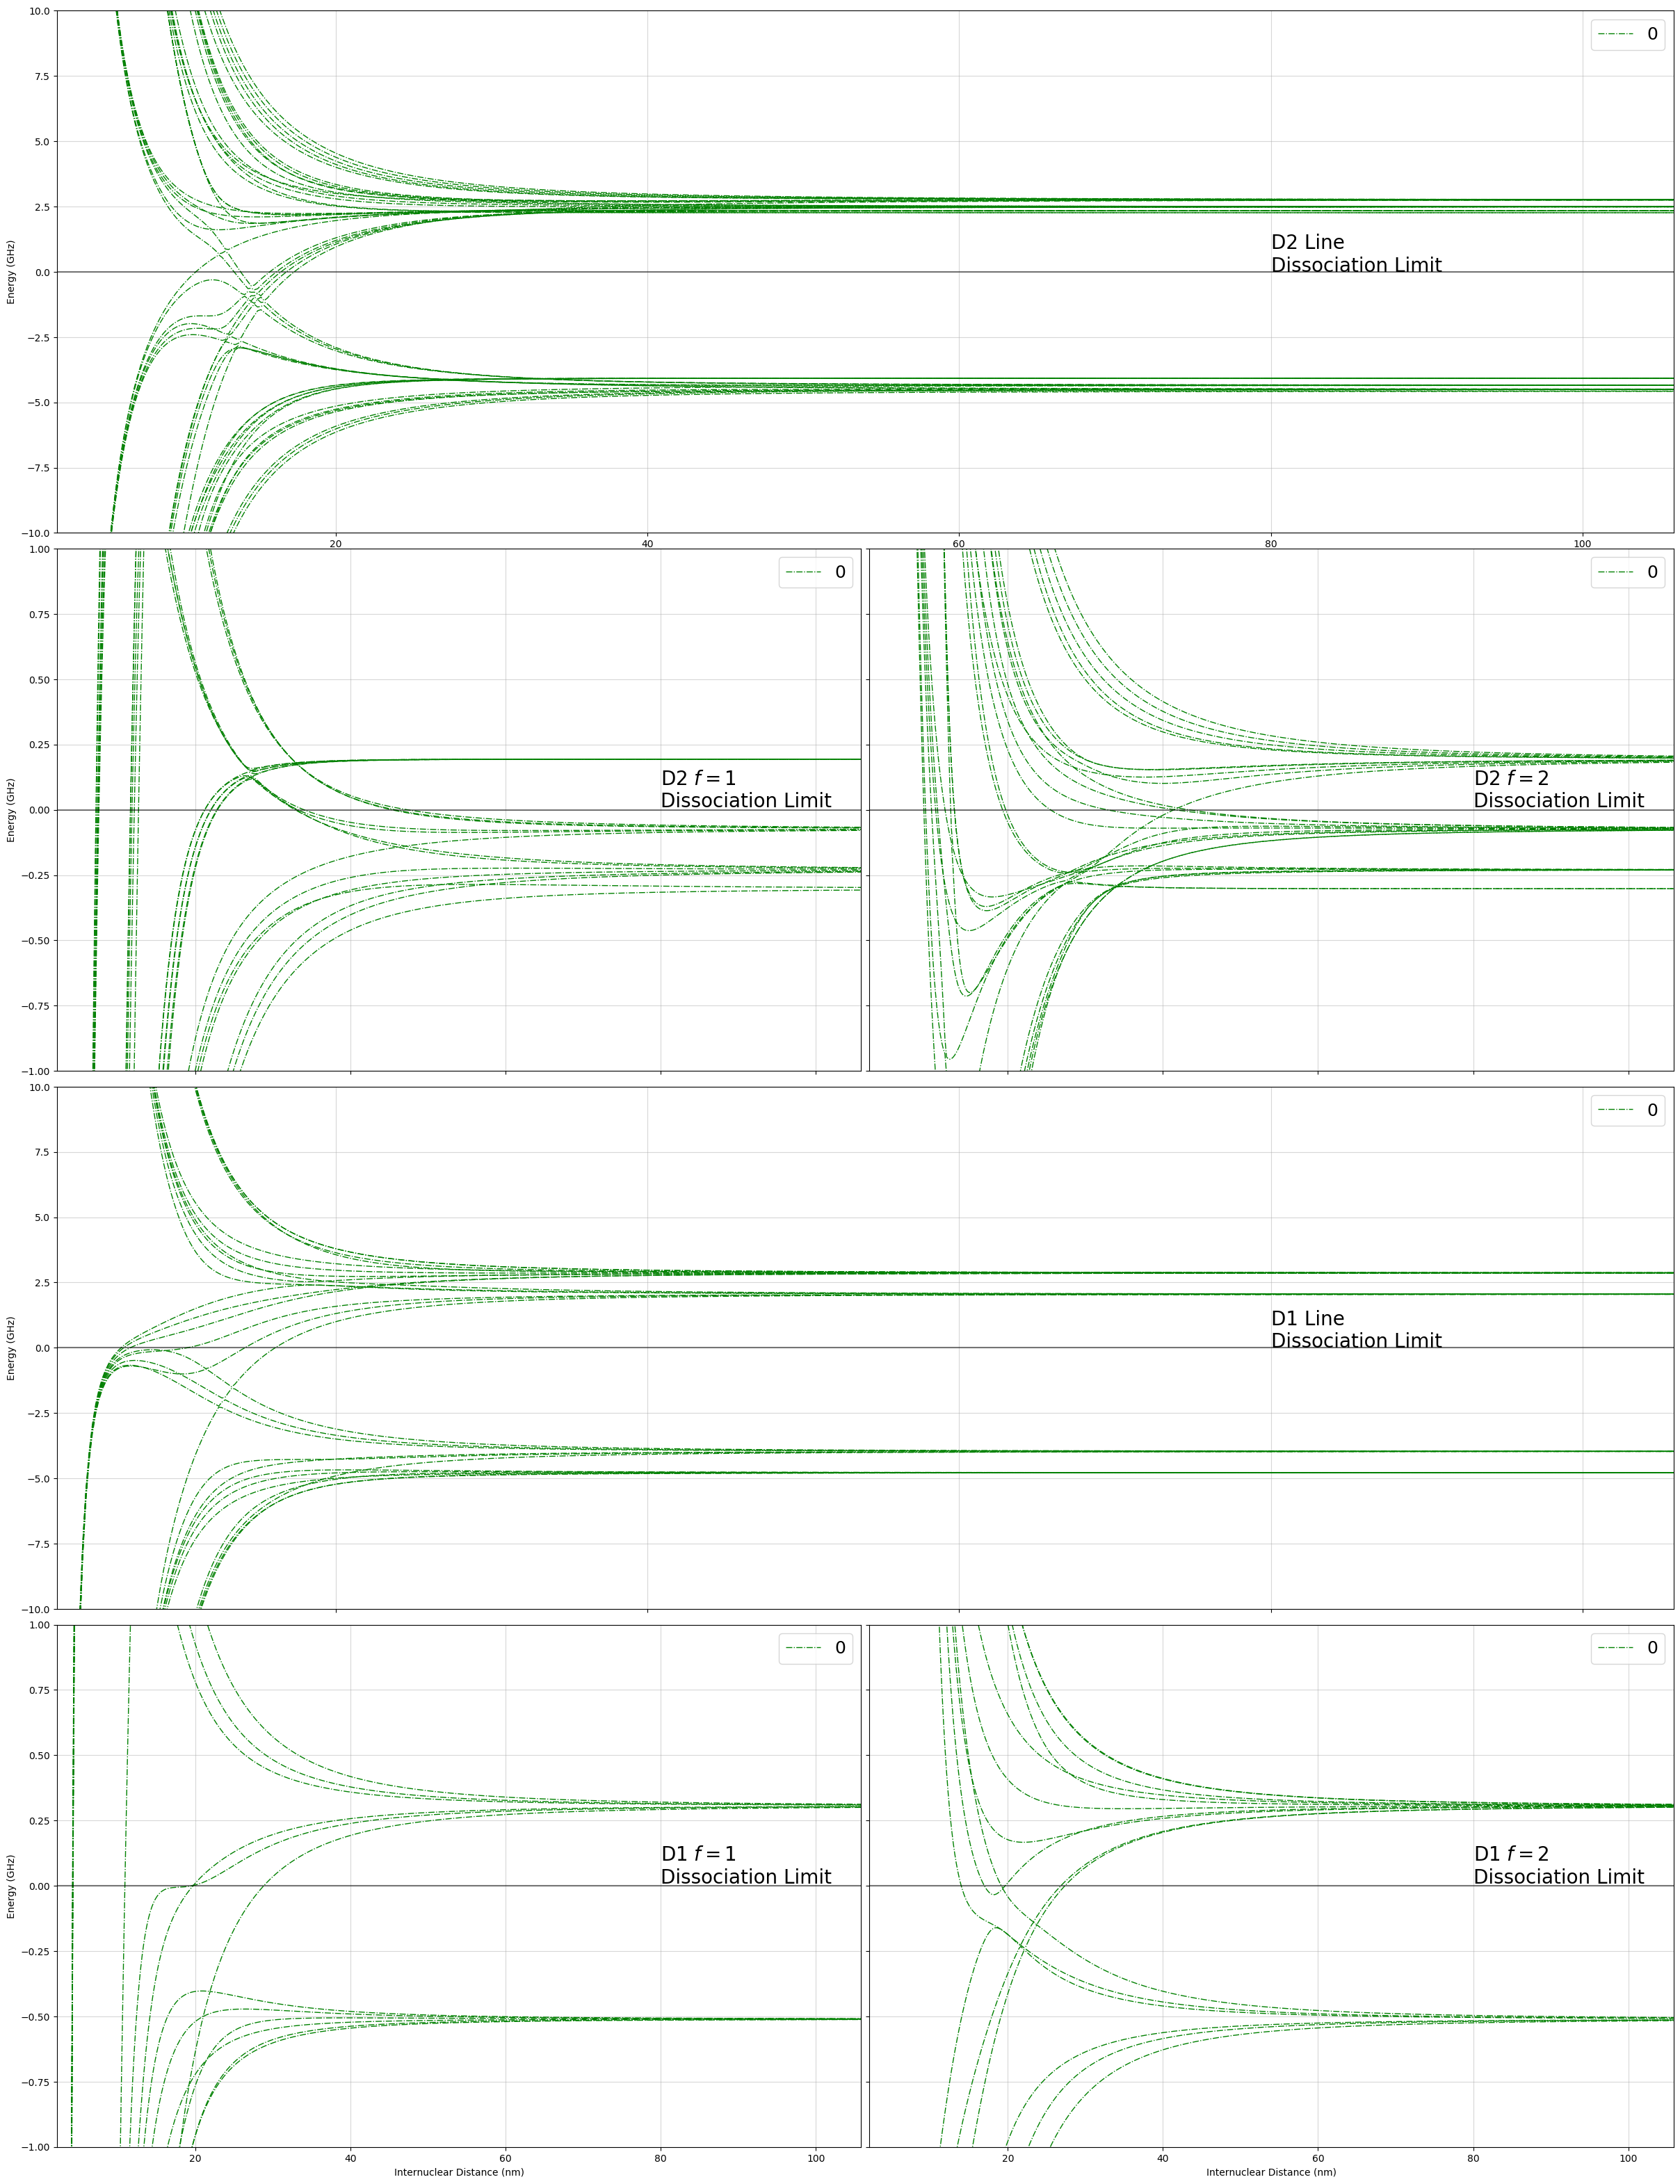

In [212]:
fig = plt.figure(figsize=(30,60))
gs = fig.add_gridspec(6,2)
axs = []
axs.append(fig.add_subplot(gs[0, :]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))
axs.append(fig.add_subplot(gs[2, :]))
axs.append(fig.add_subplot(gs[3, 0]))
axs.append(fig.add_subplot(gs[3, 1]))

fig.subplots_adjust(hspace=0.03, wspace=0.01)

titles = ["D2 Line",  
          r"D2 $f=1$",     r"D2 $f=2$",
          "D1 Line",  
          r"D1 $f=1$",     r"D1 $f=2$"]

allYlims = [(-10,10), 
            (-1,1),    (-1,1),
            (-10,10), 
            (-1,1),    (-1,1)]
yoffsets = np.array(
            [0,
            -mc.Rb87_Ground_ToF1,-mc.Rb87_Ground_ToF2,
            DeltaVal/mc.h,
            DeltaVal/mc.h-mc.Rb87_Ground_ToF1,DeltaVal/mc.h-mc.Rb87_Ground_ToF2])/1e9
inc=1
#phiColors, _ = misc.getColors(len(phiBases)+1)#, cmStr='gnuplot')
phiColors=['g','c','b','purple', 'orange','r']
plotByGuCharacter=False
for num, (ax, title, ylims, yoff) in enumerate(zip(axs[:], titles, allYlims, yoffsets)):
    for label, base in mostlySymmetrizedBases.items():
        color = phiColors[int(label[0])]
        linestyle = '-' if label[-1] == 'a' else '-.'
        for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff , color=color, linestyle=linestyle, linewidth=1, 
                    label=label if datanum==0 else None)
    leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
    for text in leg.get_texts():
        text.set_color("k")
    ax.axhline(0,color='k',alpha=0.5)
    ax.text(80,0.01, title + "\nDissociation Limit", fontsize=20, color='k')
    ax.set_ylim(*ylims)
    ax.set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
    ax.grid(alpha=0.5)
    if num != len(axs)-1 and num != len(axs)-2 and num != 0:
        ax.set_xticklabels([]);
    elif num != 0:
        ax.set_xlabel('Internuclear Distance (nm)')
    if num not in [0,1, 3,4]:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Energy (GHz)')
plt.savefig("Symmetrized_Hyperfine_Splitting_Big_Picture.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

#### Zoomed out D1 & D2

In [ ]:
fig = plt.figure(figsize=(30,60))
gs = fig.add_gridspec(6,2)
axs = []
axs.append(fig.add_subplot(gs[0, :]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))
axs.append(fig.add_subplot(gs[2, :]))
axs.append(fig.add_subplot(gs[3, 0]))
axs.append(fig.add_subplot(gs[3, 1]))

fig.subplots_adjust(hspace=0.03, wspace=0.01)

titles = ["D2 Line",  
          r"D2 $f=1$",     r"D2 $f=2$",
          "D1 Line",  
          r"D1 $f=1$",     r"D1 $f=2$"]

allYlims = [(-10,10), 
            (-1,1),    (-1,1),
            (-10,10), 
            (-1,1),    (-1,1)]
yoffsets = np.array(
            [0,
            -mc.Rb87_Ground_ToF1,-mc.Rb87_Ground_ToF2,
            DeltaVal/mc.h,
            DeltaVal/mc.h-mc.Rb87_Ground_ToF1,DeltaVal/mc.h-mc.Rb87_Ground_ToF2])/1e9
inc=1
#phiColors, _ = misc.getColors(len(phiBases)+1)#, cmStr='gnuplot')
phiColors=['g','c','b','purple', 'orange','r']
plotByGuCharacter=False
for num, (ax, title, ylims, yoff) in enumerate(zip(axs[:], titles, allYlims, yoffsets)):
    for label, base in mostlySymmetrizedBases.items():
        color = phiColors[int(label[0])]
        linestyle = '-' if label[-1] == 'a' else '-.'
        for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff , color=color, linestyle=linestyle, linewidth=1, 
                    label=label if datanum==0 else None)
    leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
    for text in leg.get_texts():
        text.set_color("k")
    ax.axhline(0,color='k',alpha=0.5)
    ax.text(80,0.01, title + "\nDissociation Limit", fontsize=20, color='k')
    ax.set_ylim(*ylims)
    ax.set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
    ax.grid(alpha=0.5)
    if num != len(axs)-1 and num != len(axs)-2 and num != 0:
        ax.set_xticklabels([]);
    elif num != 0:
        ax.set_xlabel('Internuclear Distance (nm)')
    if num not in [0,1, 3,4]:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Energy (GHz)')
plt.savefig("Symmetrized_Hyperfine_Splitting_Big_Picture.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

#### D1 Zoomed In

In [ ]:
fig = plt.figure(figsize=(30,35))
gs = fig.add_gridspec(4,2)
axs = []
for i1, i2 in zip([0,0,1,1,2,2,3,3], [0,1,0,1,0,1,0,1]):
    axs.append(fig.add_subplot(gs[i1,i2]))
fig.subplots_adjust(hspace=0.03, wspace=0.01)

titles = [
          r"D2 $f=1,f'=3$",r"D2 $f=2,f'=3$",
          r"D2 $f=1,f'=2$",r"D2 $f=2,f'=2$",
          r"D2 $f=1,f'=1$",r"D2 $f=2,f'=1$",
          r"D2 $f=1,f'=0$",r"D2 $f=2,f'=0$"]

allYlims = [
            (-0.1,0.1), (-0.1,0.1),
            (-0.1,0.1), (-0.1,0.1),
            (-0.1,0.1), (-0.1,0.1),
            (-0.1,0.1), (-0.1,0.1),]
gColor = 'r'
uColor = 'orange'
yoffsets = np.array(
            [-mc.Rb87_Ground_ToF1-mc.Rb87_5P32_ToF3,-mc.Rb87_Ground_ToF2-mc.Rb87_5P32_ToF3,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P32_ToF2,-mc.Rb87_Ground_ToF2-mc.Rb87_5P32_ToF2,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P32_ToF1,-mc.Rb87_Ground_ToF2-mc.Rb87_5P32_ToF1,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P32_ToF0,-mc.Rb87_Ground_ToF2-mc.Rb87_5P32_ToF0])/1e9

inc=1
#phiColors, _ = misc.getColors(len(phiBases)+1)#, cmStr='gnuplot')
phiColors=['g','c','b','purple', 'orange','r']
plotByGuCharacter=False
for num, (ax, title, ylims, yoff) in enumerate(zip(axs[:], titles, allYlims, yoffsets)):
    for label, base in mostlySymmetrizedBases.items():
        color = phiColors[int(label[0])]
        linestyle = '-' if label[-1] == 'a' else '-.'
        for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff , color=color, linestyle=linestyle, linewidth=1, 
                    label=label if datanum==0 else None)
        leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
    for text in leg.get_texts():
        text.set_color("k")
    ax.axhline(0,color='k',alpha=0.5)
    ax.text(80,0.01, title + "\nDissociation Limit", fontsize=20, color='k')
    ax.set_ylim(*ylims)
    ax.set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
    ax.grid(alpha=0.5)
    if num != len(axs)-1 and num != len(axs)-2 and num != 0:
        ax.set_xticklabels([]);
    elif num != 0:
        ax.set_xlabel('Internuclear Distance (nm)')
    if num % 2 == 1:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Energy (GHz)')
plt.savefig("Symmetrized_Hyperfine_Splitting_D2_Zoom.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
fig = plt.figure(figsize=(30,20))
gs = fig.add_gridspec(2,2)
axs = []
for i1, i2 in zip([0,0,1,1], [0,1,0,1]):
    axs.append(fig.add_subplot(gs[i1,i2]))
fig.subplots_adjust(hspace=0.025, wspace=0.01)

titles = [r"D1 $f=1,f'=2$",r"D1 $f=2,f'=2$",
          r"D1 $f=1,f'=1$",r"D1 $f=2,f'=1$"]

allYlims = np.array(
           [(-0.3,0.3),  (-0.3,0.3),
            (-0.3,0.3),  (-0.3,0.3)])
yoffsets = np.array(         
            [-mc.Rb87_Ground_ToF1-mc.Rb87_5P12_ToF2,-mc.Rb87_Ground_ToF2-mc.Rb87_5P12_ToF2,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P12_ToF1,-mc.Rb87_Ground_ToF2-mc.Rb87_5P12_ToF1])/1e9
yoffsets += DeltaVal/mc.h/1e9
inc=1
for num, (ax, title, ylims, yoff) in enumerate(zip(axs, titles, allYlims, yoffsets)):
    for label, base in mostlySymmetrizedBases.items():
        color = phiColors[int(label[0])]
        linestyle = '-' if label[-1] == 'a' else '-.'
        for datanum, mdata in enumerate(misc.transpose(energies[label])[::inc]):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff , color=color, linestyle=linestyle, linewidth=1, 
                    label=label if datanum==0 else None)
    leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
    for text in leg.get_texts():
        text.set_color("k")

    ax.axhline(0,color='k',alpha=0.5)
    ax.text(70,0.05, title + "\nDissociation Limit", fontsize=20, color='k')
    ax.set_ylim(*ylims)
    ax.set_xlim(0,100)
    ax.grid(alpha=1)
    if num != len(axs)-1 and num != len(axs)-2:
        ax.set_xticklabels([]);
    elif num != 0:
        ax.set_xlabel('Internuclear Distance (nm)')
    if num % 2 == 1:
        ax.set_yticklabels([]);
    else:
        ax.set_ylabel('Energy (GHz)')
plt.savefig("Symmetrized_Hyperfine_Splitting_D1_Zoom.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

# hyperfine w/ rotation

In [28]:
from sympy.physics.secondquant import KroneckerDelta as kd

In [29]:
def br(x):
    return 2*x+1

In [30]:
def coef_hfs(f_a, f_b, f, ell, 
             S, Lambda, Sigma, Omega, I, iota, phi, p, F,
             verbose=False):
    s_a = s_b = 1/2
    i_a = i_b = 3/2
    l_a = 0
    l_b = 1
    L = 1

    sign = int((-1)**(ell-phi-F))
    frac = float((1+(-1)**(1+ell+p)*(1-kd(Lambda,0)*kd(Sigma,0)*kd(iota,0)))
            /sp.sqrt(2-kd(Lambda,0)*kd(Sigma,0)))
    j_a = 1/2
    sumTerm = 0
    cgc3 = float(CG(f,-phi,F,phi,ell,0).doit())
    if cgc3 == 0:
        if verbose:
            print('CG(f,-phi,F,phi,ell,0)=0')
        return 0
    reasonsForZero = []
    for j_b in [1/2,3/2]:
        # no F=3 or F=1 states in the D1 manifold
        if (f_b == 3 or f_b == 0) and j_b == 1/2:
            continue
        
        for j in np.arange(abs(j_b-j_a), j_b+j_a+1,1):
            cgc1 = float(CG(j,Omega,I,iota,f,phi).doit())
            if cgc1 == 0:
                reasonsForZero.append(1)
                continue
            cgc2 = float(CG(L,Lambda,S,Sigma,j,Omega).doit())
            if cgc2 == 0:
                reasonsForZero.append(2)
                continue
            cgcs = cgc1*cgc2*cgc3
            breveTerms = float(np.sqrt(br(1/2)*br(j_b)*br(f_a)
                                 *br(f_b)*br(1)*br(S)*br(j)*br(I)))
            wig1 = float(wigner_9j(l_a, s_a, j_a,
                                   l_b, s_b, j_b, 
                                   L,     S, j))
            if wig1 == 0:
                reasonsForZero.append(3)
                continue
            wig2 = float(wigner_9j(j_a, i_a, f_a,
                                   j_b, i_b, f_b,
                                   j,   I, f))
            if wig2 == 0:
                reasonsForZero.append(4)
                continue;
            reasonsForZero.append(-1)
            sumTerm += breveTerms*cgcs*wig1*wig2
    res = sign*frac*sumTerm
    if res == 0 and verbose:
        print(reasonsForZero)
    if np.isnan(res):
        print('nan!',sign,frac,sumTerm)
    return res

In [31]:
def createCaseE_Basis(F, totalParity):
    IVal = 3/2
    SVal = 1/2
    LVal_e = 1
    jVal_g = 1/2
    caseE_BasisRef = []
    # states with different J have the same rotational energy but it's important for counting the right number of states.
    for jVal_e in np.arange(abs(SVal-LVal_e), SVal+LVal_e+1,1):
        for fVal_e in np.arange(abs(jVal_e-IVal), jVal_e+IVal+1,1):
            for fVal_g in np.arange(abs(jVal_g - IVal), jVal_g+IVal+1,1):
                for f in np.arange(abs(fVal_e-fVal_g),fVal_e+fVal_g+1,1, dtype=int):
                    # max f is 5.
                    for ell in np.arange(max([F-5,0]),F+6,1, dtype=int):
                        if (-1)**ell == totalParity:
                            if F in np.arange(abs(f-ell), f+ell+1,1):
                                state = multiplyableDict({"fa":fVal_g, "fb": fVal_e, "je":jVal_e,"f": f, "ell":ell, 'F':F})
                                if state not in caseE_BasisRef:
                                    caseE_BasisRef.append(state)                                    
    return caseE_BasisRef

In [32]:
def create_EtoA_Matrix(caseA_Basis, caseE_Basis, F):
    print('Creating E-to-A Conversion Matrix')
    res = np.zeros((len(caseA_Basis), len(caseE_Basis)))
    for aind, stateA in enumerate(caseA_Basis):            
        misc.reportProgress(aind, len(caseA_Basis))
        for eind, stateE in enumerate(caseE_Basis):
            p = 0 if (-1)**(F+1)>0 else 1
            res[aind,eind] = coef_hfs(stateE['fa'],stateE['fb'],stateE['f'],stateE['ell'],
                                      stateA['S'],
                                      stateA['Lambda'], stateA['Sigma'], stateA['Omega'], 
                                      stateA['i'], stateA['iota'], stateA['phi'], p, stateE['F'], )
    return res

In [33]:
def createRotationalCouplingMatrix(caseE_Basis):
    # creates the matrix in case E, needs to be transformed to case A basis to calculate properly.
    res = np.zeros((len(caseE_Basis),len(caseE_Basis)))
    for indE, stateE in enumerate(caseE_Basis):
        ell = stateE['ell']
        res[indE,indE] = ell*(ell+1)
    return res

In [34]:
def createBornOppenheimerBasisHFS(Lvals, Svals, Ivals, sigmavals, Fv, totalParity):
    # Normal Notaion is |L Lambda sigma S Sigma>, but I need to keep track of more than that for the splittings caused by other interactions.
    # Therefore this creates a very big basis which is probably unnecessary, but the size of the matrices isn't actually prohibitive in these 
    # calculations so it's okay to have degeneracies.
    #assert (type(Fv)==int and Fv>0)
    assert(type(Fv)==int)
    assert(totalParity == 1 or totalParity == -1)
    
    boBasisRef = []
    for sigma in sigmavals:
        for Lv in Lvals:
            for Lambda in np.arange(-Lv,Lv+1,1):
                for Sv in Svals:
                    for Sigma in np.arange(-Sv, Sv+1,1):
                        for i1 in Ivals:
                            for i2 in Ivals:
                                for Iv in np.arange(abs(i2-i1), i2+i1+1,1):
                                    for iota in np.arange(-Iv,Iv+1,1):
                                        # tells me whether l 
                                        thisParity = (-1)**(Lv+Sv+Iv - Fv)
                                        state = multiplyableDict({"L":Lv, "Lambda": Lambda, "sigma": sigma, "S":Sv, "Sigma":Sigma, "i":Iv, "iota":iota, "i1":i1, "i2":i2,
                                                                  "Omega":Sigma+Lambda, "phi": Sigma+Lambda+iota, 'F':Fv })
                                        if state not in boBasisRef and thisParity == totalParity:
                                            boBasisRef.append(state)
    boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["Omega"]) + 100 * ord(state["sigma"])))
    boBasisFancy = []
    for state in boBasisRef:
        spinT = 2*state["S"]+1
        omega = state["Omega"]
        parity = state["sigma"]
        LambdaSymbol = "\Sigma" if state["Lambda"]==0 else "\Pi"
        boBasisFancy.append(Latex(r"$^{"+str(spinT)+ "}" + LambdaSymbol + "_{"+ str(abs(omega)) + "," + parity + "}$"))        
    return boBasisRef, boBasisFancy

In [35]:
A_gs = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
A_12 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
A_32 = (mc.Rb87_5P32_ToF3-mc.Rb87_5P32_ToF0)/6

In [36]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [37]:
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = createLargerBasisRefs([0,1], [1/2], [3/2])
fsOperator = fsOp(jiBasis2Atom)
hfsOperator = hfsOp(fBasis2Atom, A_12, A_gs, mc.Rb87_5P32_ToF3,mc.Rb87_5P32_ToF2,mc.Rb87_5P32_ToF1,mc.Rb87_5P32_ToF0)
lsiToJiop = lsiToJi(lsiBasis,jiBasis)
jiToFOp = jiTof(jiBasis, fBasis)
fv = 51
boBasisDict_g, boBasisLatex_g = createBornOppenheimerBasisHFS([1],[0,1], [3/2], ['g'], fv, 1)
boBasisDict_u, boBasisLatex_u = createBornOppenheimerBasisHFS([1],[0,1], [3/2], ['u'], fv, 1)
boBasisDict_full, boBasisLatex_full = createBornOppenheimerBasisHFS([1],[0,1], [3/2], ['g', 'u'], fv, 1)

NameError: name 'createLargerBasisRefs' is not defined

In [38]:
len(boBasisDict_full)

NameError: name 'boBasisDict_full' is not defined

In [39]:
# Full basis 
numPhi=6
phiBases = [[] for _ in range(numPhi)]
for phi in range(numPhi):
    for state in boBasisDict_full:
        if math.isclose(abs(state['phi']),phi):
            phiBases[phi].append(state)

NameError: name 'boBasisDict_full' is not defined

In [40]:
# LIMITED Basis, not considering degenerate negative phi states
numPhi=6
phiBases = [[] for _ in range(numPhi)]
for phi in range(7):
    for state in boBasisDict_full:
        if state['phi']==phi:
            phiBases[phi].append(state)

NameError: name 'boBasisDict_full' is not defined

In [41]:
[len(b) for b in phiBases]

In [42]:
sum([len(b) for b in phiBases])

In [79]:
H_fs_phi = [[] for _ in phiBases]
H_hfs_phi = [[] for _ in phiBases]
for phiV, phiBase in enumerate(phiBases):
    IPython.display.clear_output(wait=True)
    print('Working on Phi ' + str(phiV) +". " + str(len(phiBase)) + " states")
    
    fsStates = []
    hfsStates = []
    boBasisDict = phiBase
    print('Converting BO states to FS and HFS bases')
    for num, state in enumerate(boBasisDict):
        misc.reportProgress(num, len(boBasisDict))
        sigma = g if state["sigma"] == "g" else u
        I, iota, i1, i2 = [state[k] for k in ["i","iota","i1","i2"]]
        mpstate, indvCont, lsiBasisStates, jiBasisStates = BohrOppenheimerToAtomic( (state["L"], state["Lambda"], 1, 0),
                                                                                   (state["S"], state["Omega"] - state["Lambda"], 1/2, 1/2),
                                                                                   (I, iota, i1, i2), sigma, lsiBasis, basisChange=lsiToJiop )
        hfsState, indvCont, lsiBasisStates, fBasisStates = BohrOppenheimerToAtomic( (state["L"], state["Lambda"], 1, 0),
                                                                                   (state["S"], state["Omega"] - state["Lambda"], 1/2, 1/2), 
                                                                                   (I, iota, i1, i2), sigma, lsiBasis, basisChange=jiToFOp@lsiToJiop )
        if np.isnan(mpstate[0]):
            print("???")
            continue
        fsStates.append(mpstate);
        hfsStates.append(hfsState)
    print('Complete\nCalcualting FS Energies')
    H_fs_phi[phiV] = createCouplingMatrix( fsStates, fsOperator, offset=-1/2)#, boBasis=boBasisDict )
    print('Complete\nCalcualting HFS Energies')
    H_hfs_phi[phiV] = createCouplingMatrix( hfsStates, hfsOperator, offset=0)#, boBasis=boBasisDict )
    print('Complete')

Working on Phi 5. 0 states
Converting BO states to FS and HFS bases
Complete
Calcualting FS Energies
Complete
Calcualting HFS Energies
Complete


In [81]:
import scipy.linalg

In [82]:
allFsPhiE = scipy.linalg.block_diag(*H_fs_phi)
allHfsPhiE = scipy.linalg.block_diag(*H_hfs_phi)

In [84]:
Fvals = [0]
etoaMatrices = [[] for _ in Fvals]
for num, Fval in enumerate(Fvals):
    print('F:', Fval)
    base_E_basis = createCaseE_Basis(Fval, 1)+createCaseE_Basis(Fval, -1)
    etoaMatrices[num] = create_EtoA_Matrix(boBasisDict_full, base_E_basis, Fval);

F: 0
Creating E-to-A Conversion Matrix


In [327]:
Fval = 2
base_E_basis = createCaseE_Basis(Fval, 1)+createCaseE_Basis(Fval, -1)
etoaF2 = create_EtoA_Matrix(boBasisDict_full, base_E_basis, Fval);

Creating E-to-A Conversion Matrix


In [328]:
Fval = 3
base_E_basis = createCaseE_Basis(Fval, 1)+createCaseE_Basis(Fval, -1)
etoaF3 = create_EtoA_Matrix(boBasisDict_full, base_E_basis, Fval);

Creating E-to-A Conversion Matrix


In [333]:
etoaMatrices[2] = etoaF2
etoaMatrices[3] = etoaF3

In [ ]:
Fvals = [0,1,2]
etoaMatrices.append([])
newFVal = 2
base_E_basis = createCaseE_Basis(newFVal, 1)+createCaseE_Basis(newFVal, -1)
etoaMatrices[-1] = create_EtoA_Matrix(boBasisDict_full, base_E_basis, newFVal);

In [806]:
base_E_basis = createCaseE_Basis(0, 1)
etoa = create_EtoA_Matrix(boBasisDict_full, base_E_basis, newFVal);

Creating E-to-A Conversion Matrix


In [807]:
indexes = []
for eind, stateE in enumerate(base_E_basis):
    misc.reportProgress(eind, len(base_E_basis))
    hasProj = False
    for stateA in boBasisDict_full:
        cv = coef_hfs(stateE['fa'],stateE['fb'],stateE['f'],stateE['ell'], 
                       stateA['S'], stateA['Lambda'], stateA['Sigma'], stateA['Omega'], stateA['i'], stateA['iota'], stateA['phi'], p, stateE['F'])
        if cv != 0:
            hasProj = True
    if not hasProj:
        indexes.append(eind)

In [828]:
stateE = base_E_basis[4]
coefs = []
indexes = []
print(stateE)
for aind, stateA in enumerate(boBasisDict_full):
    cv = coef_hfs(stateE['fa'],stateE['fb'],stateE['f'],stateE['ell'], 
                   stateA['S'], stateA['Lambda'], stateA['Sigma'], stateA['Omega'], stateA['i'], stateA['iota'], stateA['phi'], p, stateE['F'])
    if cv != 0:
        coefs.append(cv)
        indexes.append(aind)
        print(stateA)

{'fa': 2.0, 'fb': 2.0, 'je': 0.5, 'f': 0, 'ell': 0, 'F': 0}
{'L': 1, 'Lambda': 0, 'sigma': 'g', 'S': 0, 'Sigma': 0, 'i': 1.0, 'iota': 0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}
{'L': 1, 'Lambda': 0, 'sigma': 'g', 'S': 1, 'Sigma': 0, 'i': 0.0, 'iota': -0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}
{'L': 1, 'Lambda': 0, 'sigma': 'g', 'S': 1, 'Sigma': 0, 'i': 2.0, 'iota': 0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}
{'L': 1, 'Lambda': 0, 'sigma': 'u', 'S': 0, 'Sigma': 0, 'i': 1.0, 'iota': 0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}
{'L': 1, 'Lambda': 0, 'sigma': 'u', 'S': 1, 'Sigma': 0, 'i': 0.0, 'iota': -0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}
{'L': 1, 'Lambda': 0, 'sigma': 'u', 'S': 1, 'Sigma': 0, 'i': 2.0, 'iota': 0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}


In [829]:
print(sum([val**2 for val in coefs]))

1.233333333333333


In [811]:
print(etoa.shape)
ide = etoa@etoa.T
ide2 = etoa.T@etoa
print(ide.shape, ide2.shape)

(384, 19)
(384, 384) (19, 19)


In [ ]:
Rvals = np.linspace( 1*20*mc.a0, 100*20*mc.a0, 5000 )
colors = ['y','r','b','g']
Fvals = [0,1,2,3]
superdata = [[] for _ in Fvals]
for Fvalnum, (Fval, color) in enumerate(zip(Fvals, colors)):
    data = superdata[Fvalnum]
    base_E_basis = createCaseE_Basis(Fval, 1)+createCaseE_Basis(Fval, -1)
    RCM = createRotationalCouplingMatrix(base_E_basis)*mc.Rb87_M*1e-9**2/(mc.hbar**2)
    print(RCM.shape,np.array(etoaMatrices[Fvalnum]).shape)    
    #etoa = create_EtoA_Matrix(boBasisDict_full, base_E_basis, Fval);
    rotationalEnergy = etoaMatrices[Fvalnum]@RCM@etoaMatrices[Fvalnum].conj().T
    print("Diagonalizing Energy at all R.")
    for rnum, rv in enumerate(Rvals):
        misc.reportProgress(rnum, len(Rvals))
        t1 = createBOMatrix2(C_3_val, rv, *boBasisDict_full).astype(float)
        t2 = allFsPhiE * 2 * DeltaVal / 3
        t3 = allHfsPhiE * mc.h
        rmatrix = t1+t2+t3+rotationalEnergy
        data.append(sorted(np.real(np.linalg.eigvalsh(rmatrix))))
        #eigVals, eigVectors = np.linalg.eigh(rmatrix)

In [ ]:
fig = plt.figure(figsize=(30,20))
gs = fig.add_gridspec(2,2)
axs = []
for i1, i2 in zip([0,0,1,1], [0,1,0,1]):
    axs.append(fig.add_subplot(gs[i1,i2]))
fig.subplots_adjust(hspace=0.025, wspace=0.01)

titles = [r"D1 $f=1,f'=2$",r"D1 $f=2,f'=2$",
          r"D1 $f=1,f'=1$",r"D1 $f=2,f'=1$"]

allYlims = np.array(
           [(-0.3,0.3),  (-0.3,0.3),
            (-0.3,0.3),  (-0.3,0.3)])
yoffsets = np.array(         
            [-mc.Rb87_Ground_ToF1-mc.Rb87_5P12_ToF2,-mc.Rb87_Ground_ToF2-mc.Rb87_5P12_ToF2,
             -mc.Rb87_Ground_ToF1-mc.Rb87_5P12_ToF1,-mc.Rb87_Ground_ToF2-mc.Rb87_5P12_ToF1])/1e9
yoffsets += DeltaVal/mc.h/1e9
inc=1
colors, _ = misc.getColors(len(superdata)+1)
for num, (ax, title, ylims, yoff) in enumerate(zip(axs, titles, allYlims, yoffsets)):
    for data, color in zip(superdata, colors):
        for datanum, mdata in enumerate(misc.transpose(data)):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h + yoff , color=color, linestyle='-', linewidth=1)
    #leg = ax.legend(fontsize=18, ncol=3, loc='upper right')
    for text in leg.get_texts():
        text.set_color("k")

    ax.axhline(0,color='k',alpha=0.5)
    ax.text(70,0.05, title + "\nDissociation Limit", fontsize=20, color='k')
    ax.set_ylim(*ylims)
    ax.set_xlim(0,100)
    ax.grid(alpha=1)
    if num != len(axs)-1 and num != len(axs)-2:
        ax.set_xticklabels([]);
    elif num != 0:
        ax.set_xlabel('Internuclear Distance (nm)')
    if num % 2 == 1:
        ax.set_yticklabels([]);
    else:
        ax.set_ylabel('Energy (GHz)')
#plt.savefig("Hyperfine_Splitting_D1_Zoom.png", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)

In [ ]:
fig, axs = plt.subplots(3,2,figsize=(30,15))
for fvalnum, (Fval, color) in enumerate(zip(Fvals, colors)):
    data = superdata[Fvalnum]
    for ax in axs.flatten():
        #ax.axhline(-0.0729113, alpha=0.2,color='r')
        #ax.axhline(-0.2298518, alpha=0.2,color='r')
        #ax.axhline(-0.30207388, alpha=0.2,color='r')
        #ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        #ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
        for mdata in misc.transpose(data):
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, color=color, linestyle='-')
        ax.set_xlabel('Inter-nuclear distance (nm)')
        ax.set_ylabel('Energy (GHz)')
        ax.grid(alpha=0.1)
        ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

    axs[0,0].set_title('Full Range')
    axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
    #axs[0,0].legend(ncol=5,fontsize=14)s
    axs[1,0].set_title('Zoom $5P_{3/2}$')
    axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
    axs[1,0].set_ylim(-1000, 500)
    axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
    axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
    axs[0,1].set_ylim(-0.35, 0.25)
    axs[1,1].set_title('Zoom $5P_{1/2}$')
    axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
    axs[1,1].set_ylim(-8000, -6000);
    axs[2,0].set_xlim(1.41,1.42)
    axs[2,0].set_ylim(-3170,-3160)
    axs[2,1].set_xlim(min(Rvals)*1e9, max(Rvals)*1e9)
    #plt.savefig('Movre-Pischler-Super-Rotating.png', dpi=200)

In [ ]:
Rvals = np.linspace( 1*20*mc.a0, 100*20*mc.a0, 1000 )

energies = [np.zeros((len(Rvals),len(phiBase))) for phiBase in phiBases]
guCharacters = [np.zeros((len(Rvals),len(phiBase))) for phiBase in phiBases]
phiCharacter = [np.zeros((len(Rvals),len(phiBase))) for phiBase in phiBases]
pCharacter = [np.zeros((len(Rvals),len(phiBase))) for phiBase in phiBases]

for phi, base in enumerate(phiBases):
    if len(base) == 0:
        continue
    IPython.display.clear_output(wait=True)
    print('\nPhiVal:',phi)
    print('Calcualting Eigenvalues at every R')    
    boBasisDict = base
    for num, rv in enumerate(Rvals):
        misc.reportProgress(num, len(Rvals))
        rmatrix = createBOMatrix2(C_3_val, rv, *boBasisDict).astype(float) + H_fs_phi[phi] * 2 * DeltaVal / 3 + H_hfs_phi[phi] * mc.h
        eigVals, eigVectors = np.linalg.eigh(rmatrix)
        guCharacterIndvR  = np.zeros(len(boBasisDict))
        pCharIndvR = np.zeros(len(boBasisDict))
        for vnum, eigVec in enumerate(misc.transpose(eigVectors)):
            for stateCoef, state in zip(eigVec, boBasisDict):
                pCharIndvR[vnum] += stateCoef**2*(-1)**state['i']
                if state['sigma']=='u':
                    guCharacterIndvR[vnum] += stateCoef**2
                else:
                    assert(state['sigma']=='g')
        tups = zip(eigVals, eigVectors, guCharacterIndvR);
        tups = sorted(tups, key=lambda v: v[0]/mc.h + v[2])
        eigVals, eigVectors, guCharacterIndvR = zip(*tups)
        energies[phi][num] = eigVals
        guCharacters[phi][num] = guCharacterIndvR
        pCharacter[phi][num] = pCharIndvR

$$
v_{th} = \sqrt{\frac{3k_B T}{m}}
$$

In [194]:
T = 1000e-6
v_th = np.sqrt((3*mc.k_B*T)/mc.Rb87_M)
print('velocity: ' + misc.round_sig_str(v_th) + ' m/s')
print('distance traveled during lifetime: ' + misc.round_sig_str(v_th*mc.Rb87_D1_Lifetime*1e9) + ' nm')

velocity: 0.536 m/s
distance traveled during lifetime: 14.8 nm


### testing fine structure result from paul

In [830]:
import sympy as sp

In [831]:
def getMatrix1(Jv):
    matrix = np.zeros((6,6))
    Norm = 1/sp.sqrt(6*(2*Jv+1))
    matrix = sp.Matrix(matrix)
    matrix[:,0] = [  2*Jv,   4*Jv,   2*Jv+2,    -2*Jv-2,  2*Jv+2,  0]
    matrix[:,1] = [ -2*Jv-2,-4*Jv-4, 2*Jv,      -2*Jv,    2*Jv,    0]
    matrix[2] = [  4*Jv,  -2*Jv,   4*Jv+4,     Jv+1,   -Jv-1,    0]
    matrix[3] = [ -4*Jv-4, 2*Jv+2, 4*Jv,       Jv,     -Jv,      0]
    matrix[4] = [ 0,       0,      0,         -3*Jv+3, -3*Jv+3, -6*Jv-12]
    matrix[5] = [ 0,       0,      0,          3*Jv+6,  3*Jv+6, -6*Jv+6]
    if Jv==0:
        matrix[0] = 0
        matrix[2] = 0
        matrix[4] = 0
        matrix[5] = 0
        matrix[:,2] = 0
        matrix[:,3] = 0
        matrix[:,4] = 0
        matrix[:,5] = 0
    if Jv == 1:
        matrix[4] = 0
        matrix[:,5] = 0
    for ri in range(matrix.rows):
        for ci in range(matrix.cols):
            val = matrix[ri,ci]
            matrix[ri,ci] = np.sign(val.subs({Jv:10}))*sp.sqrt(sp.Abs(val))
    return (matrix*Norm).T

In [832]:
Jv = sp.symbols('J',positive=True)
Jv = Jv+1
res = getMatrix1(Jv)

In [833]:
def getMatrix2(Jv):
    matrix = np.zeros((6,6))
    matrix = sp.Matrix(matrix)
    Cv = (2*Jv+3)*(2*Jv-1)
    Dv = (2*Jv+3)*(2*Jv+1)
    Ev = 4*Jv**2-1
    matrix[0] = [ sp.S(1)/3, -sp.S(2)/3, 0, 0, 0, 0 ]
    matrix[1] = [ 0, 0, (-1)**Jv/3,   -(-1)**Jv/3,  (-1)**Jv/3, 0 ]
    matrix[2] = [ 0, 0, (-1)**Jv*2/3,  (-1)**Jv/6, -(-1)**Jv/6, 0]
    matrix[3] = [    Jv*(Jv-1) /Ev,      Jv*(Jv-1)   /(2*Ev), 0,  Jv*(Jv-1)/Ev,     Jv*(Jv-1)/Ev,       (Jv+1)*(Jv+2)/(2*Ev) ]
    matrix[4] = [ -2*Jv*(Jv+1) /(3*Cv), -Jv*(Jv+1)   /(3*Cv), 0,         -3/(2*Cv),        -3/(2*Cv), 3*(Jv-1)*(Jv+2)/Cv ]
    matrix[5] = [ (Jv+1)*(Jv+2)/Dv,     (Jv+1)*(Jv+2)/(2*Dv), 0, -Jv*(Jv+2)/Dv,    -Jv*(Jv+2)/Dv,           Jv*(Jv-1)/(2*Dv)]
    if Jv == 0:
        matrix[1] = 0
        matrix[2] = 0
        matrix[3] = 0
        matrix[4] = 0 
        matrix[:,2] = 0
        matrix[:,3] = 0
        matrix[:,4] = 0
        matrix[:,5] = 0
    if Jv == 1:
        matrix[3] = 0
        matrix[:,5] = 0
    
    for ri in range(matrix.rows):
        for ci in range(matrix.cols):
            val = matrix[ri,ci]
            matrix[ri,ci] = np.sign(val.subs({Jv:10}))*sp.sqrt(sp.Abs(val))
    return matrix.T

In [834]:
res = getMatrix2(Jv)

In [ ]:
(res.T*res).subs({Jv:2})

In [836]:
def HRotOverB_case_e_1(Jv):
    Hr = sp.Matrix(np.zeros((6,6)))
    el = Jv-1
    Hr[0,0] = el*(el+1)
    el = Jv+1
    Hr[1,1] = el*(el+1)
    el = Jv-1
    Hr[2,2] = el*(el+1)
    el = Jv+1
    Hr[3,3] = el*(el+1)
    el = Jv-1
    Hr[4,4] = el*(el+1)
    el = Jv+1
    Hr[5,5] = el*(el+1)
    return Hr

In [837]:
def HRotOverB_case_e_2(Jv):
    Hr = sp.Matrix(np.zeros((6,6)))
    el = Jv
    sp.assuming()
    Hr[0,0] = el*(el+1)
    el = Jv
    Hr[1,1] = el*(el+1)
    el = Jv
    Hr[2,2] = el*(el+1)
    el = Jv-2
    Hr[3,3] = el*(el+1)
    el = Jv
    Hr[4,4] = el*(el+1)
    el = Jv+2
    Hr[5,5] = el*(el+1)
    return Hr

In [838]:
Jv = sp.symbols('J', real=True, positive=True)
S_ea = getMatrix1(Jv+1)
Hr = HRotOverB_case_e_1(Jv+1)
res = sp.simplify(S_ea.T*Hr*S_ea)

In [ ]:
display(res)
display(res.subs({Jv:10}))

In [840]:
Jv = sp.symbols('J', real=True, positive=True)
S_ea = getMatrix2(Jv+1)
Hr = HRotOverB_case_e_2(Jv+1)
res = sp.simplify(S_ea.T*Hr*S_ea)

In [ ]:
(S_ea.T@S_ea).subs({Jv:5}).evalf()

In [ ]:
#display(res)
display(res.subs({Jv:4}))
display(res.subs({Jv:4}).evalf())

In [843]:
np.sqrt(2*(4*(4+1)-2))

In [844]:
Jv = 3
S_ea = getMatrix2(Jv)
#print(S_ea**2)
#print(S_ea)
Hr = HRotOverB_case_e_2(Jv)
#print(Hr)
print(S_ea.T)
print(Hr@S_ea)

#print(S_ea.T@Hr@S_ea)

Matrix([[sqrt(3)/3, 0, 0, 0.414039335605413, -0.421637021355784, 0.563436169819011], [-sqrt(6)/3, 0, 0, 0.292770021884560, -0.298142396999972, 0.398409536444798], [0, -0.577350269189626, -0.816496580927726, 0, 0, 0], [0, 0.577350269189626, -0.408248290463863, 0.414039335605413, -0.182574185835055, -0.487950036474267], [0, -0.577350269189626, 0.408248290463863, 0.414039335605413, -0.182574185835055, -0.487950036474267], [0, 0, 0, 0.534522483824849, 0.816496580927726, 0.218217890235992]])
Matrix([[4*sqrt(3), -4*sqrt(6), 0, 0, 0, 0], [0, 0, -6.92820323027551, 6.92820323027551, -6.92820323027551, 0], [0, 0, -9.79795897113271, -4.89897948556636, 4.89897948556636, 0], [0.828078671210825, 0.585540043769120, 0, 0.828078671210825, 0.828078671210825, 1.06904496764970], [-5.05964425626941, -3.57770876399966, 0, -2.19089023002066, -2.19089023002066, 9.79795897113271], [16.9030850945703, 11.9522860933439, 0, -14.6385010942280, -14.6385010942280, 6.54653670707977]])


In [845]:
Jv=3
(Jv-2)*(Jv-1)*np.sqrt(Jv*(Jv-1)/(4*Jv**2-1))

#### work space

In [ ]:
indexes = []
for eind, stateE in enumerate(base_E_basis):
    misc.reportProgress(eind, len(base_E_basis))
    hasProj = False
    for stateA in boBasisDict_full:
        cv = coef_hfs(stateE['fa'],stateE['fb'],stateE['f'],stateE['ell'], 
                       stateA['S'], stateA['Lambda'], stateA['Sigma'], stateA['Omega'], stateA['i'], stateA['iota'], stateA['phi'], p, stateE['F'])
        if cv != 0:
            hasProj = True
    if not hasProj:
        indexes.append(eind)

In [803]:
stateE = base_E_basis[-1]
print(stateE)
for stateA in boBasisDict_full:
    cv = coef_hfs( stateE['fa'],stateE['fb'],stateE['f'],stateE['ell'], 
                   stateA['S'], stateA['Lambda'], stateA['Sigma'], stateA['Omega'], stateA['i'], stateA['iota'], stateA['phi'], p, stateE['F'] )
    if cv != 0:
        print(stateA)

{'fa': 2.0, 'fb': 3.0, 'je': 1.5, 'f': 4, 'ell': 4, 'F': 0}
{'L': 1, 'Lambda': 0, 'sigma': 'g', 'S': 0, 'Sigma': 0, 'i': 3.0, 'iota': 0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}
{'L': 1, 'Lambda': 0, 'sigma': 'g', 'S': 1, 'Sigma': 0, 'i': 2.0, 'iota': 0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}
{'L': 1, 'Lambda': 0, 'sigma': 'u', 'S': 0, 'Sigma': 0, 'i': 3.0, 'iota': 0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}
{'L': 1, 'Lambda': 0, 'sigma': 'u', 'S': 1, 'Sigma': 0, 'i': 2.0, 'iota': 0.0, 'i1': 1.5, 'i2': 1.5, 'Omega': 0, 'phi': 0.0}


In [786]:
for ind in indexes:
    print(base_E_basis[ind])

{'fa': 1.0, 'fb': 3.0, 'je': 1.5, 'f': 2, 'ell': 2, 'F': 0}
{'fa': 1.0, 'fb': 3.0, 'je': 1.5, 'f': 4, 'ell': 4, 'F': 0}
{'fa': 2.0, 'fb': 3.0, 'je': 1.5, 'f': 2, 'ell': 2, 'F': 0}
{'fa': 2.0, 'fb': 3.0, 'je': 1.5, 'f': 4, 'ell': 4, 'F': 0}
